# Package for Report

In [265]:
library(tidyverse)
library(lmtest)
library(fpp2)
library(lmtest)
library(gridExtra)
library(fUnitRoots)
library(tseries)
library(portes)

In [266]:
filter  <- dplyr::filter ## 이거 안해주면 충돌....

In [267]:
options(warn=-1) 

In [268]:
options(repr.plot.res=200,repr.plot.height=5,repr.plot.width=10)

# mcopper

## (1)

변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.

In [270]:
data("mcopper")

* 주기가 12인 1960 ~ 2007년 데이터 임을 확인

In [271]:
glimpse(mcopper)

 Time-Series [1:564] from 1960 to 2007: 255 260 249 258 244 ...


In [272]:
z <- mcopper
t <- 1:length(mcopper)
data1 <- tibble(t=t,z=z)

### Solution

#### 시도표

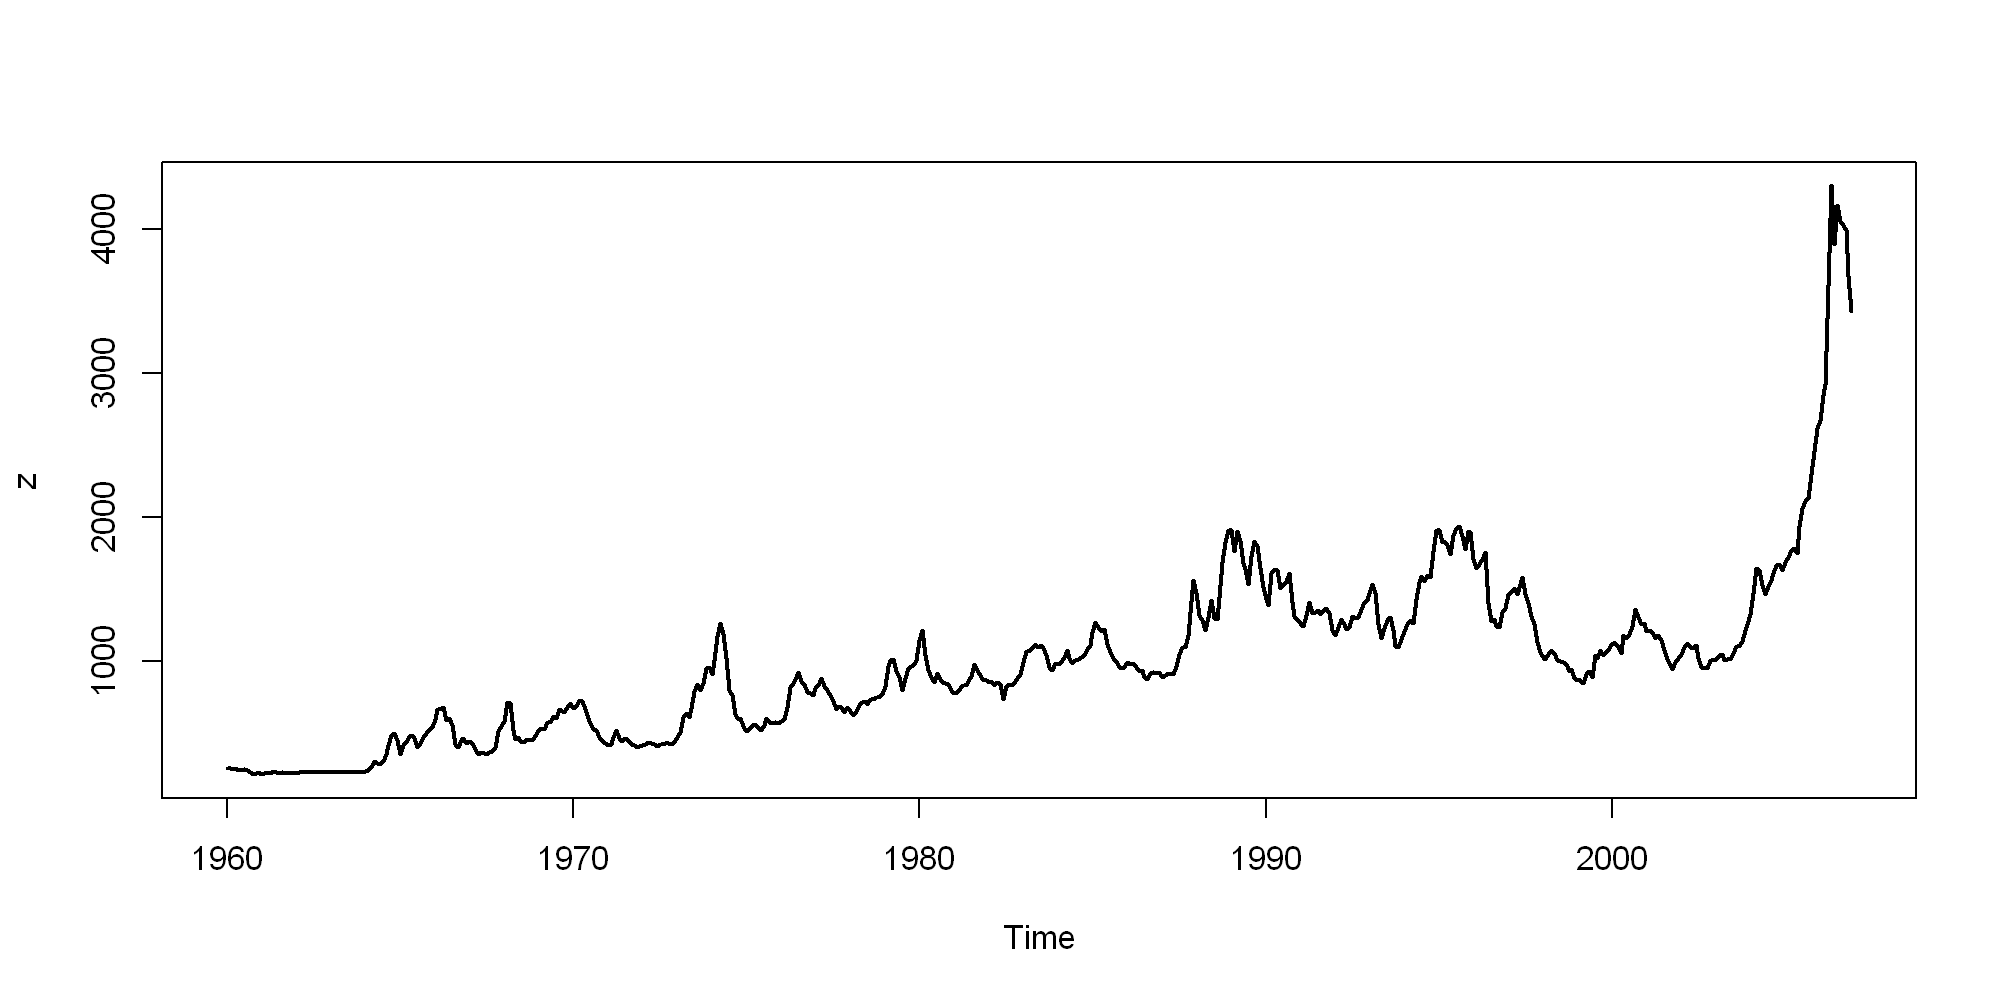

In [273]:
plot(z,lwd=2)

* 시도표를 그려본 결과 `2000년대 이후` 관측값이 급격하게 증가하는 경향을 보인다.

* 또한 `1973~1975`, `1990` 등에서 증감폭이 일정하지 않은 이분산성이 존재한다고 판단된다.

* 따라서 적절한 변수변환을 통해 이분산성을 완화할 필요가 있다.

* `로그변환`, `sqrt 변환`, `Boxcox` 변환을 통해 변수변환을 수행한 뒤 비교해보자.

#### 변수변환

In [274]:
data1 <- data1 %>% mutate(ln_z = log(z),
                 sqrt_z = sqrt(z),
                 boxcox_z = BoxCox(z,lambda= BoxCox.lambda(z)))

In [275]:
gather_d =data1 %>% 
            gather(key="type",value="value",-t) %>% filter(!type %in%  "z")

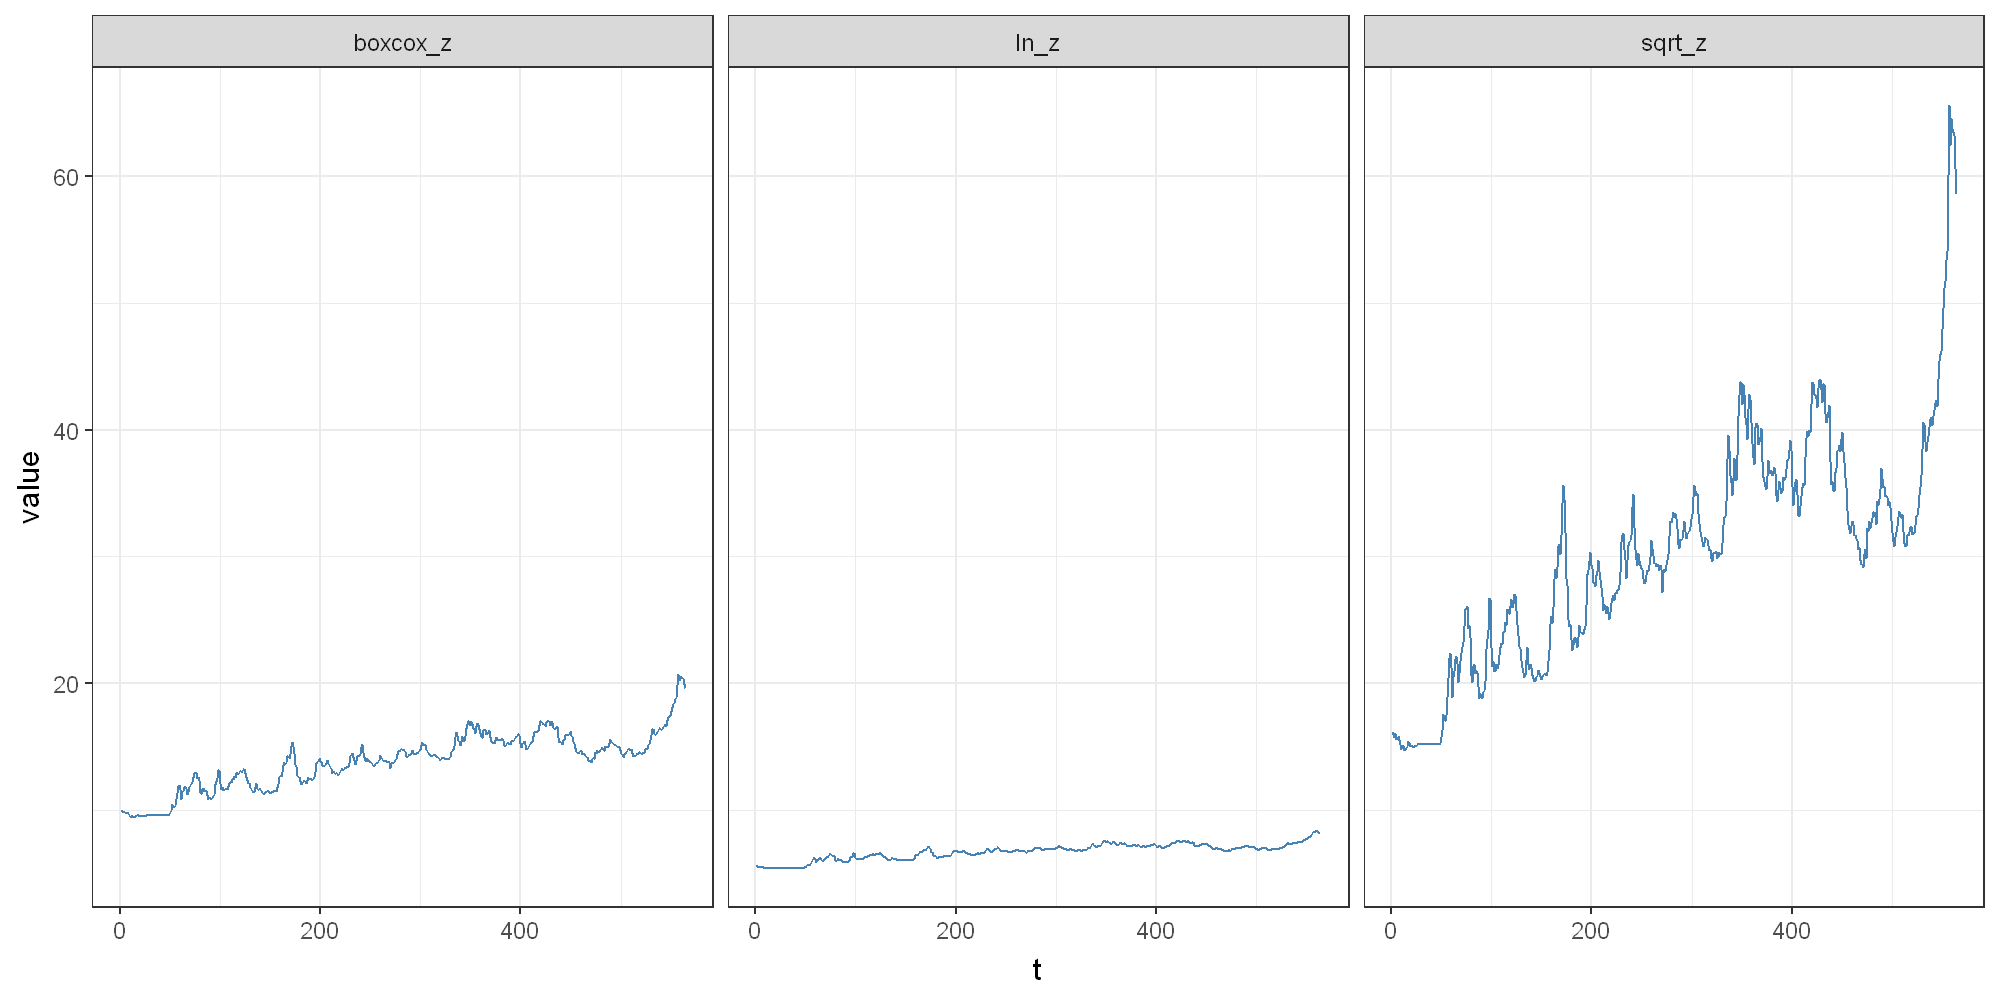

In [276]:
gather_d  %>% ggplot(aes(x=t,y=value)) +
                geom_line(col="steelblue") +
                facet_wrap(type~.) + theme_bw()

* 변환결과 로그변환 한 값들이 가장 안정적인 형태를 보이고 있다.

* 따라서 변수변환으로 로그변환을 선택하겠다.

## (2)

auto.arima 를 이용하여 예측 모형을 적합하여라. (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

### Solution

In [277]:
#?auto.arima

In [278]:
auto.arima(data1$ln_z,trace=F,ic="aic") ## trace는 진행과정을 report할건지 아닌지

Series: data1$ln_z 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02

* `AIC` 값을 기준으로 하여 모형을 적합한 결과 best model로 `ARIMA(0,1,1)`이 산출되었다.

* 추정된 `MA(1) coefficents`는 `0.3756`으로 추정되었으며, 표준오차값이 매우 작은 것으로 보아 추정된 계수가 유의하다고 판단된다.

## (3)

(2)번 모형을 제외한 다른 후보 모형을 선택하여 적합하여라. . (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

### Solution

#### 시도표, ACF, PACF

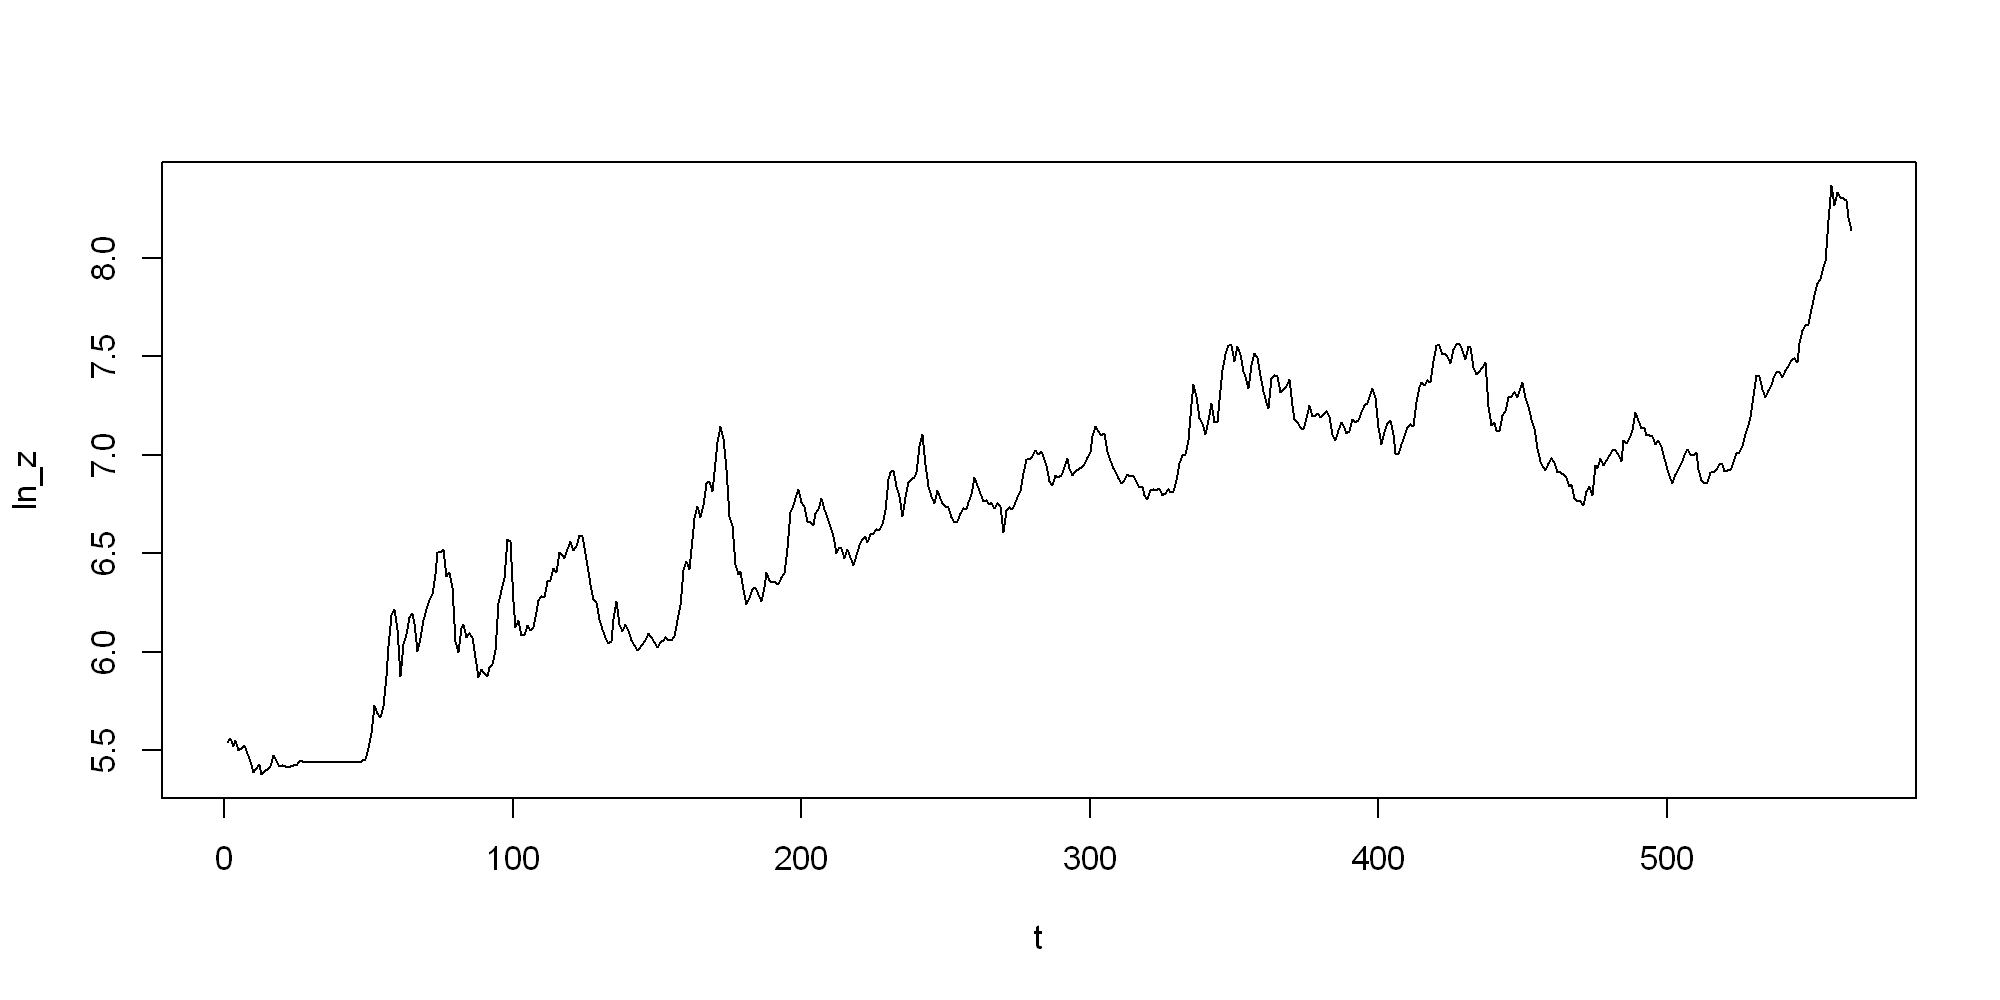

In [279]:
plot(data1 %>% select(1,3),type="l")

* 시도표를 그려본 결과 데이터의 추세성분과 절편이 존재하는 것 같다.

In [280]:
t.test(data1$ln_z)


	One Sample t-test

data:  data1$ln_z
t = 258.99, df = 563, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 6.679482 6.781572
sample estimates:
mean of x 
 6.730527 


* `t-test` 검정결과도 평균이 0 이라는 귀무가설을 기각하였다.

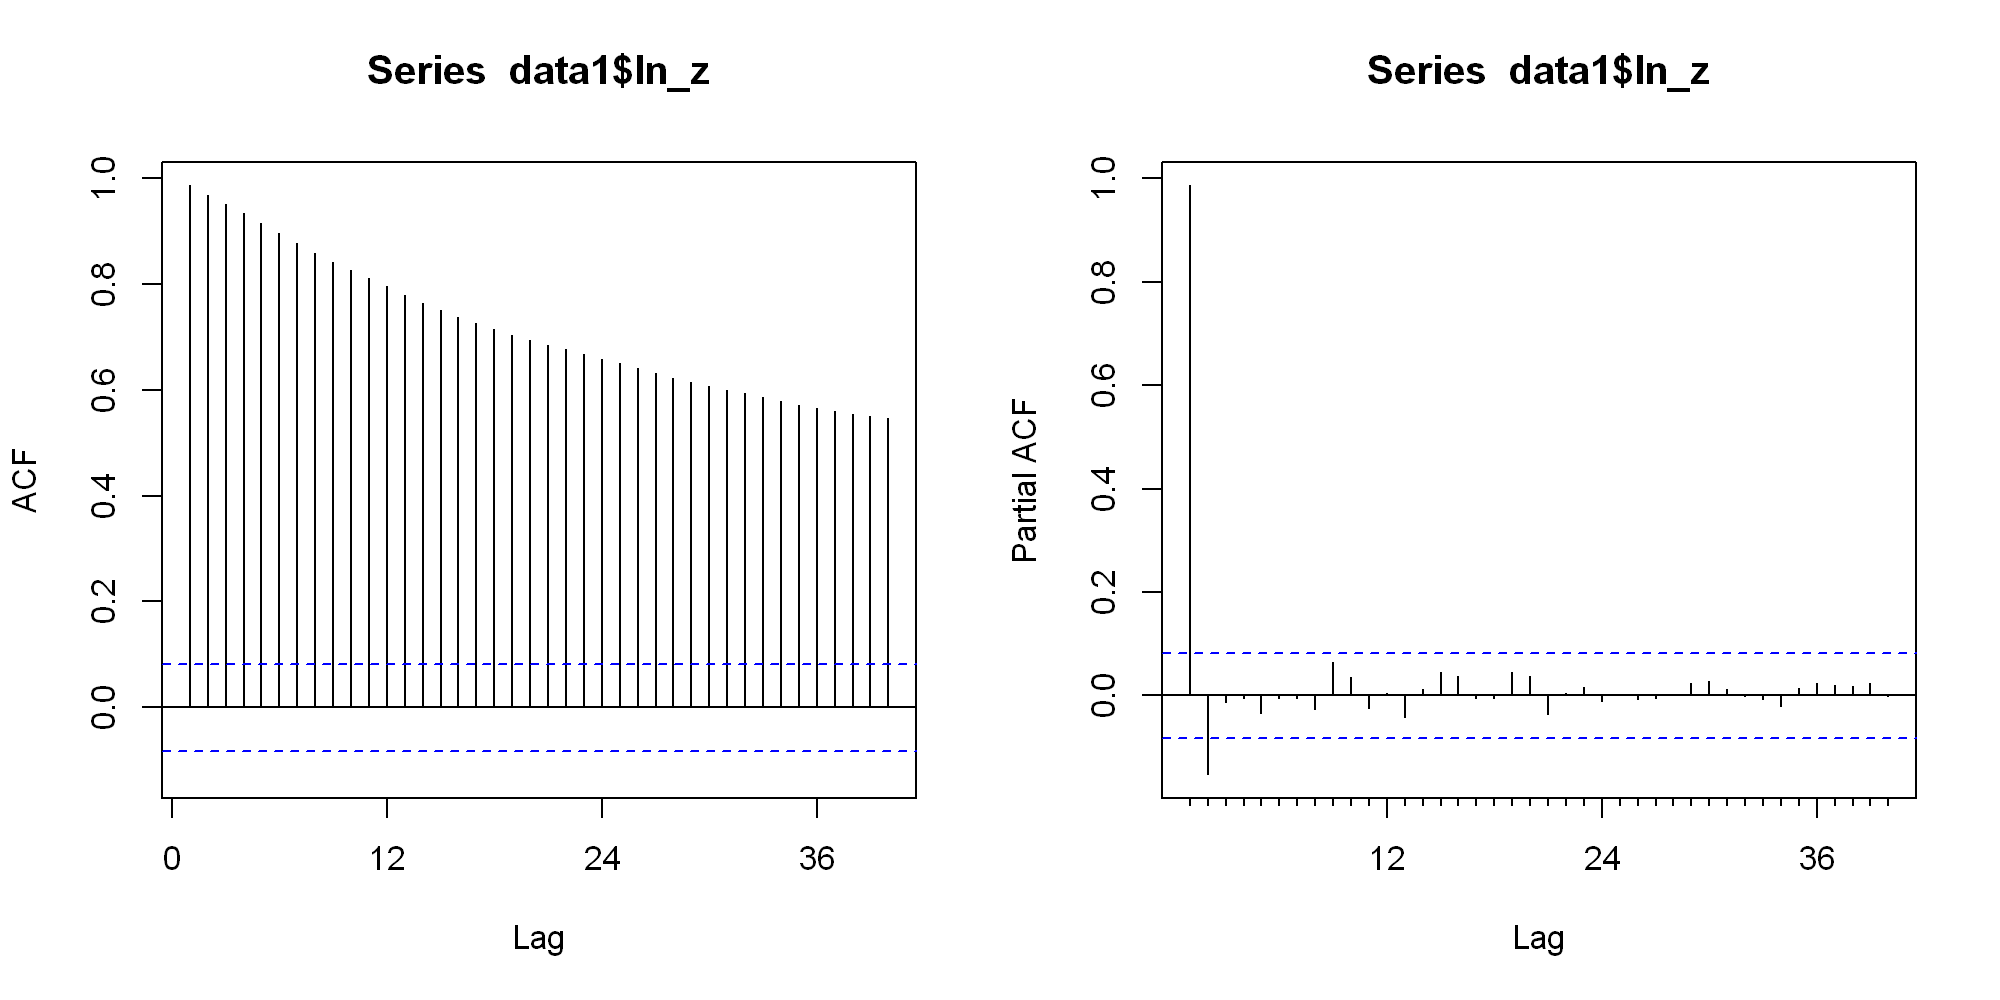

In [281]:
par(mfrow=c(1,2))
Acf(data1$ln_z,lag.max = 40); Pacf(data1$ln_z,lag.max=40)

*  `ACF` 값을 보아 확률적 추세가 있다고 의심된다.

* `PACF` 값은 `lag2` 에서 절단점을 가진다.

#### 단위근 검정

In [25]:
adfTest(data1$ln_z,lags=0,type="ct")
adfTest(data1$ln_z,lags=1,type="ct")
adfTest(data1$ln_z,lags=2,type="ct")


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -2.3142
  P VALUE:
    0.4453 

Description:
 Fri Dec 10 13:09:50 2021 by user: rkdcj



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -3.4068
  P VALUE:
    0.05227 

Description:
 Fri Dec 10 13:09:50 2021 by user: rkdcj



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -2.9847
  P VALUE:
    0.1615 

Description:
 Fri Dec 10 13:09:50 2021 by user: rkdcj


* 실제 단위근 검정결과 `lag 1 ~ 3` 까지 단위근이 존재한다고 판단된다. (ACF 도표를 보았을 때 lag3 이후에도 단위근이 존재한다고 판단된다.)

* 따라서 데이터를 차분할 필요가 있다고 판단

#### 차분 후 시도표, ACF, PACF 값 확인

In [282]:
data1["diff_lnz"] <- c(0,diff(data1$ln_z))

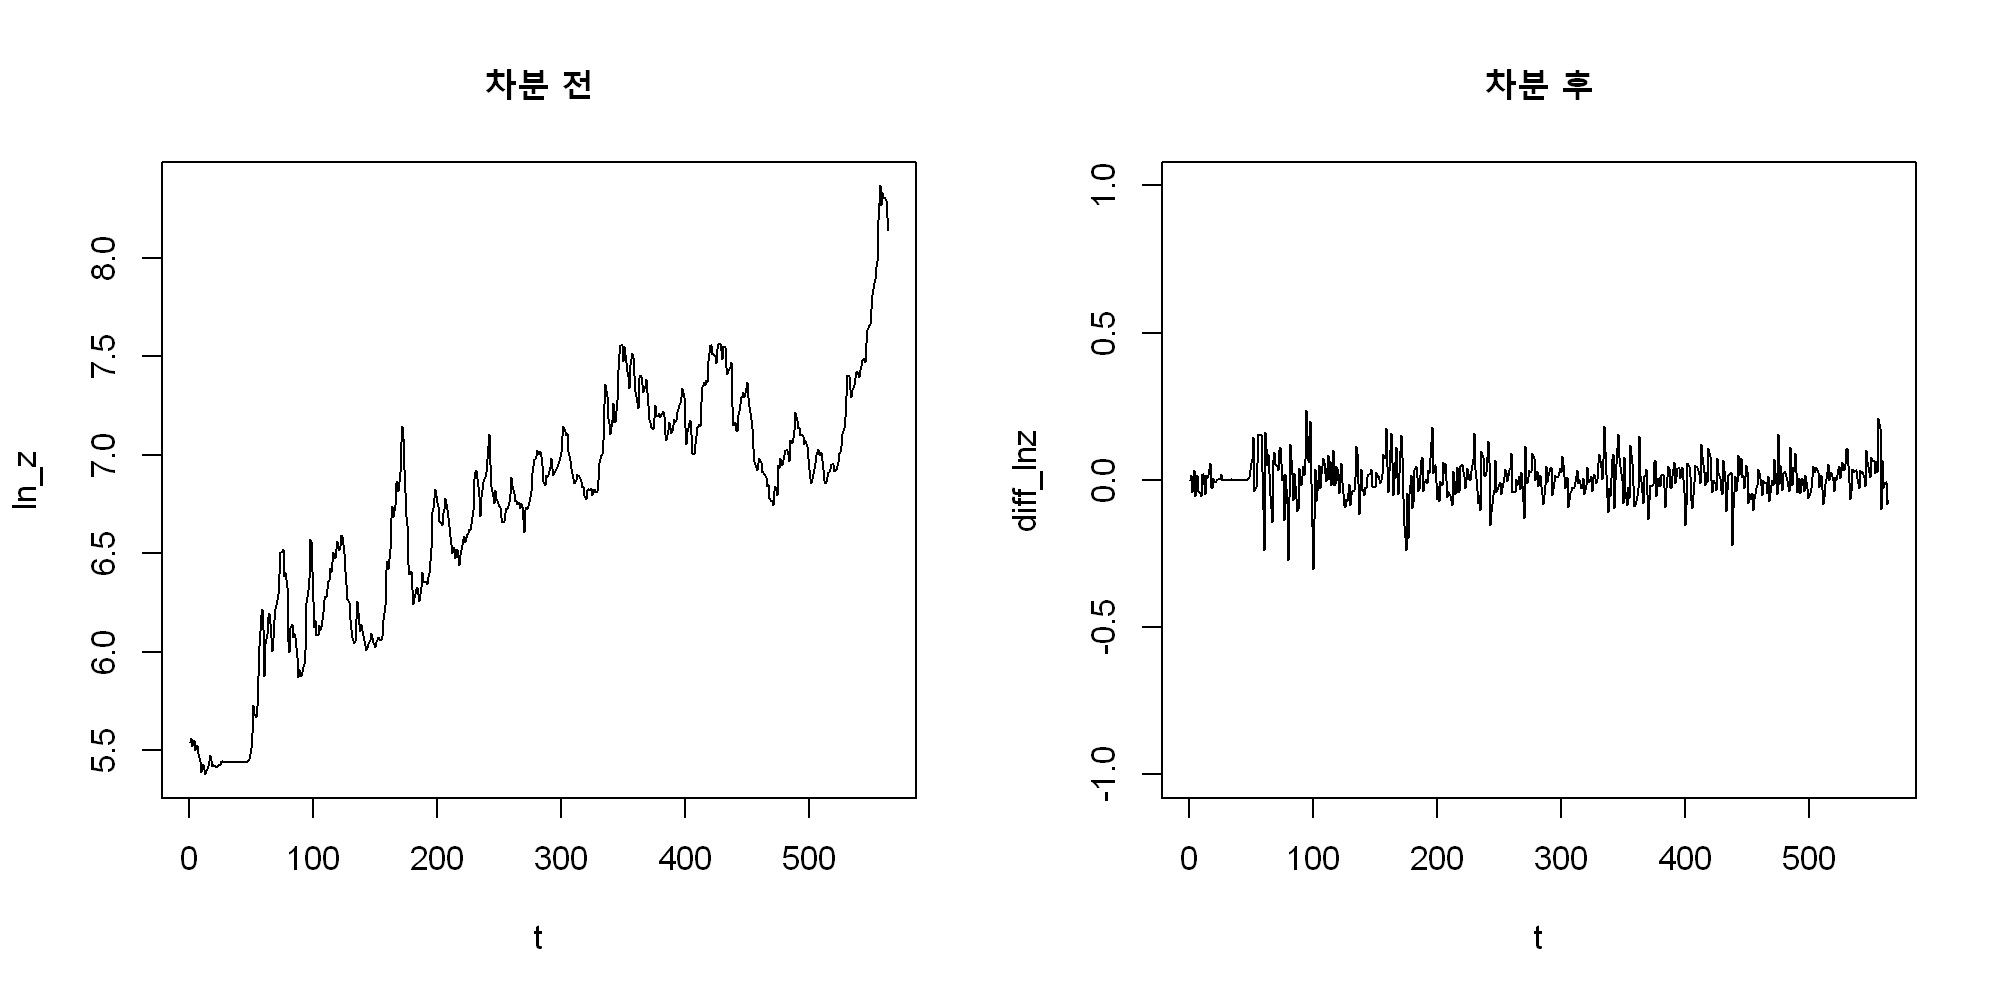

In [283]:
par(mfrow=c(1,2))
plot(data1 %>% select(t,ln_z),type="l",main="차분 전")
plot(data1 %>% select(t,diff_lnz),type="l",ylim=c(-1,1),main="차분 후")

* 시도표 확인 결과 차분한 데이터가 기존보다 안정적이며 등분산성을 만족해 보인다.

In [284]:
t.test(data1$diff_lnz)


	One Sample t-test

data:  data1$diff_lnz
t = 1.7066, df = 563, p-value = 0.08846
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.0006959209  0.0099156285
sample estimates:
  mean of x 
0.004609854 


* 또한 `t-test`결과 평균이 0이라는 귀무가설을 채택하였다.

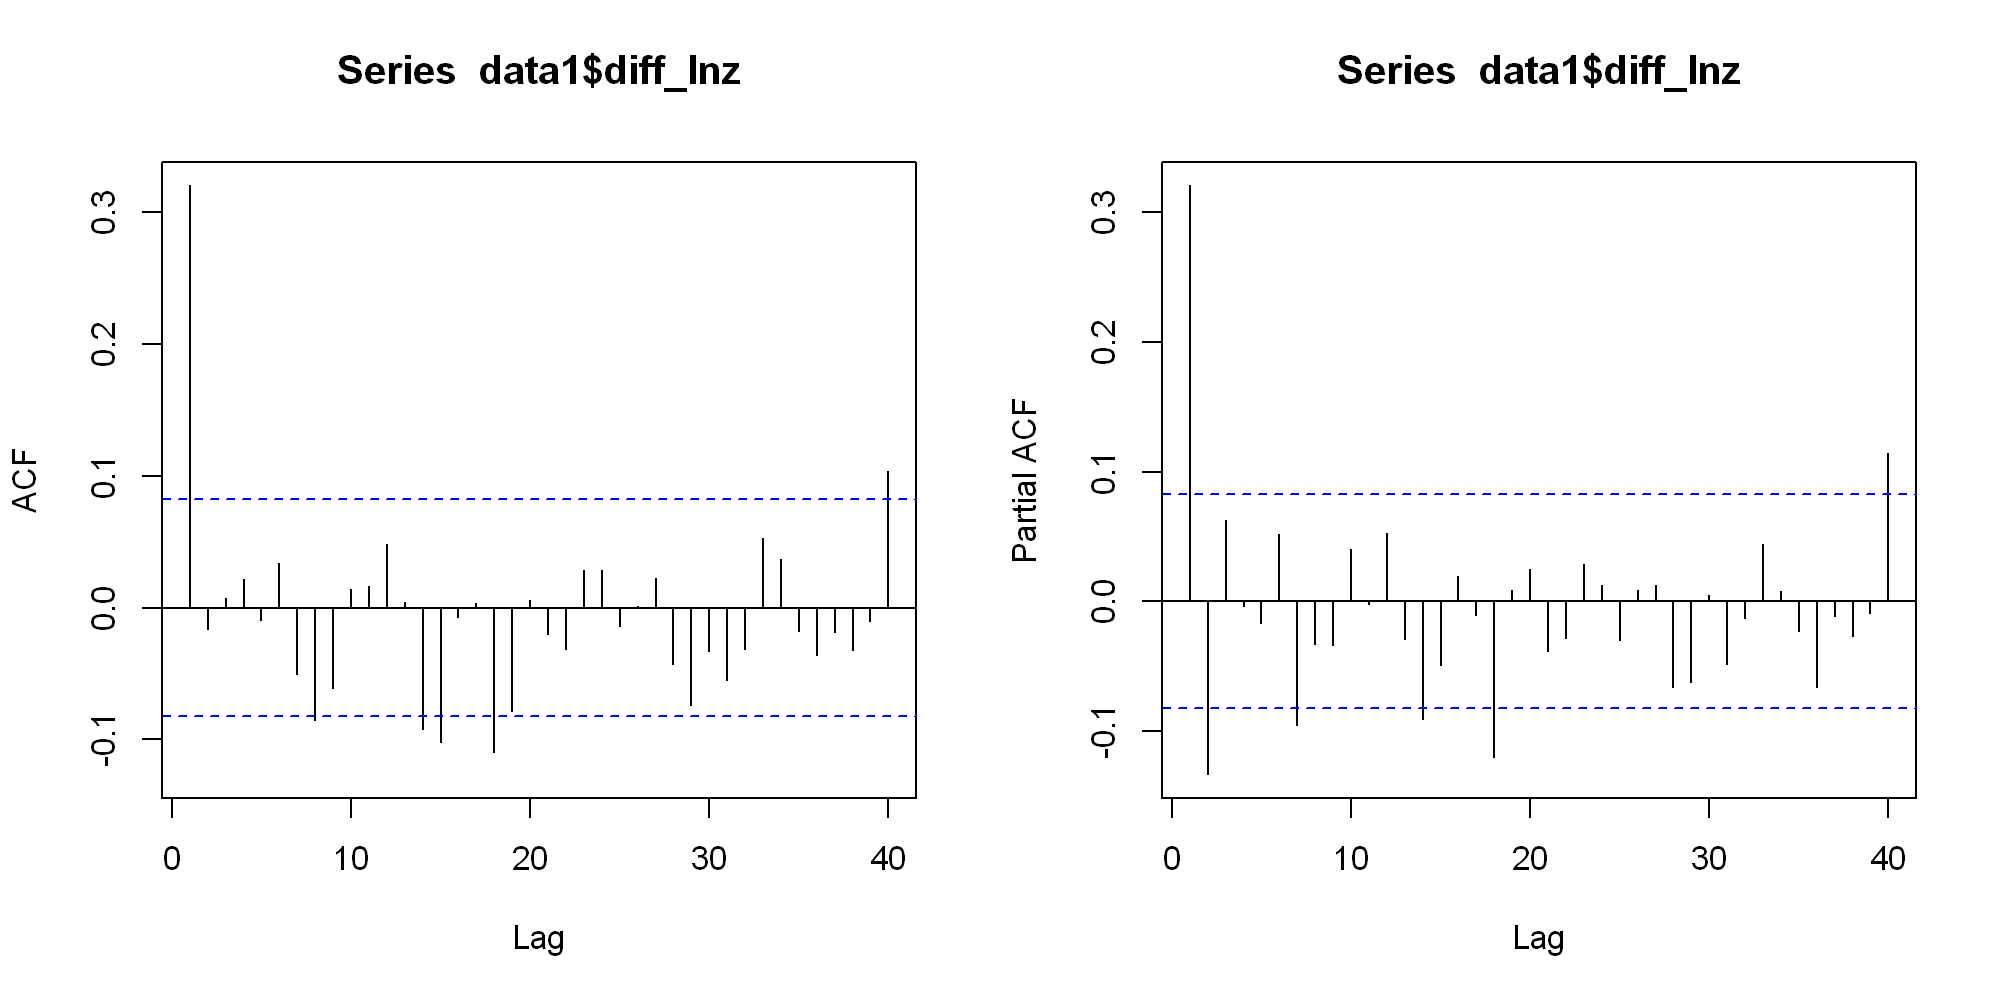

In [285]:
par(mfrow=c(1,2))
Acf(data1$diff_lnz,lag.max=40);Pacf(data1$diff_lnz,lag.max=40)

* ACF 도표를 보면 lag 1, 15~20 그리고 lag 40 에서 유의한 값들을 보인다.

* PACF 도표를 보면 lag 1, 2, 40에서 유의한 값들을 보인다.

* 시계열에서 예측시 자료의 패턴이 미래에도 지속된다는 가정하에 있기 때문에 `lag 5` 이후로는 고려하지 않겠다.

* 따라서 선택할 모형으로 `ARIMA(0,1,1)` 또는 `ARIMA(2,1,0)`을 고려해 볼 수 있다.

* 앞선 모형이`ARIMA(0,1,1)` 모형이므로 `ARIMA(2,1,0)` 모형을 적합시키겠다.

#### 로그변환 + 차분 :  ARIMA(2,1,0) 모형

In [286]:
fit1 <- arima(data1$ln_z,order=c(2,1,0))
fit1


Call:
arima(x = data1$ln_z, order = c(2, 1, 0))

Coefficients:
         ar1      ar2
      0.3661  -0.1295
s.e.  0.0418   0.0418

sigma^2 estimated as 0.003639:  log likelihood = 781.99,  aic = -1557.98

* 추정된 ar coefficients는 0.3661,-0.1295 로 표준오차를 보았을 때 유의하다고 판단된다.

## (4)

(2), (3)번 모형 중 어떤 모형일 더 적절한지 설명하여라.

### Solution

In [287]:
fit <- arima(data1$ln_z,order=c(0,1,1))
fit


Call:
arima(x = data1$ln_z, order = c(0, 1, 1))

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

In [288]:
fit1


Call:
arima(x = data1$ln_z, order = c(2, 1, 0))

Coefficients:
         ar1      ar2
      0.3661  -0.1295
s.e.  0.0418   0.0418

sigma^2 estimated as 0.003639:  log likelihood = 781.99,  aic = -1557.98

In [289]:
mse <- rep(c(fit$sigma2,fit1$sigma2))
aic  <- rep(c(fit$aic,fit1$aic))
label <- rep(c("ARIMA(0,1,1)","ARIMA(2,1,0)"))

In [290]:
summary_table <- tibble(label,mse,aic) %>% gather(key="var",value="value",-label)

In [291]:
summary_table

label,var,value
<chr>,<chr>,<dbl>
"ARIMA(0,1,1)",mse,3.627847e-03
"ARIMA(2,1,0)",mse,3.638888e-03
"ARIMA(0,1,1)",aic,-1.561685e+03
"ARIMA(2,1,0)",aic,-1.557982e+03


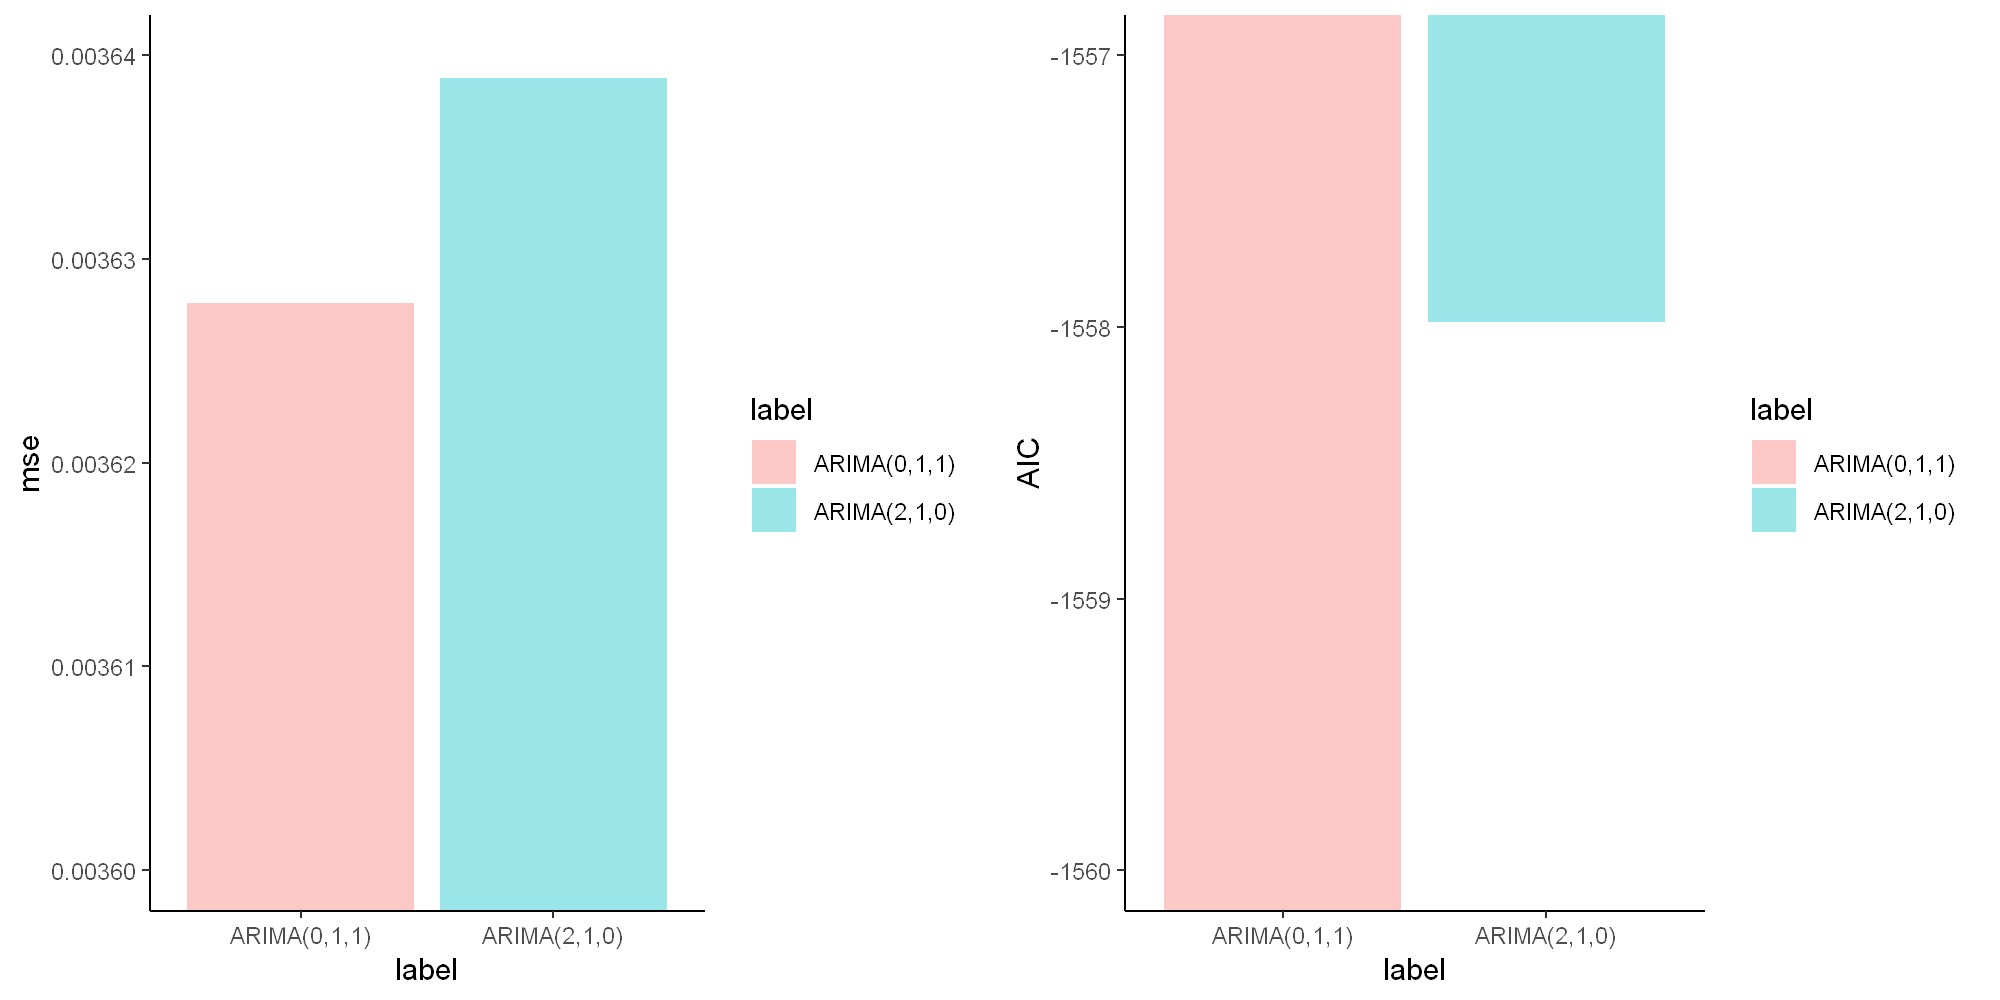

In [292]:
g1 <- summary_table %>% filter(var %in% c("mse"))  %>% 
  ggplot() +
  geom_bar(aes(x=label,y=value,fill=label),stat="identity",alpha=0.4) +
  theme_classic() +
  coord_cartesian(ylim=c(0.0036,0.00364))+
  labs(y="mse")
g2 <- summary_table %>% filter(var %in% c("aic"))  %>% 
  ggplot() +
  geom_bar(aes(x=label,y=value,fill=label),stat="identity",alpha=0.4) +
  theme_classic() +
  coord_cartesian(ylim=c(-1560,-1557)) +
  labs(y="AIC")

grid.arrange(g1, g2, ncol=2)

* 결과를 보았을 때 `MSE`와 `AIC`가 `ARIMA(0,1,1)`이 더 낮아 최종모형으로 `ARIMA(0,1,1)`이 가장 적절한 것 같다. 

* 즉 (2) 번 모형이 더 적절한 모형이다.

## (5)

(4) 에서 선택한 모형을 이용하여 잔차검정을 시행하여라.

### Solution

#### 잔차 정규성,  등분산성 검증

In [293]:
resid1 <- resid(fit)
data1["resid"] <- resid1

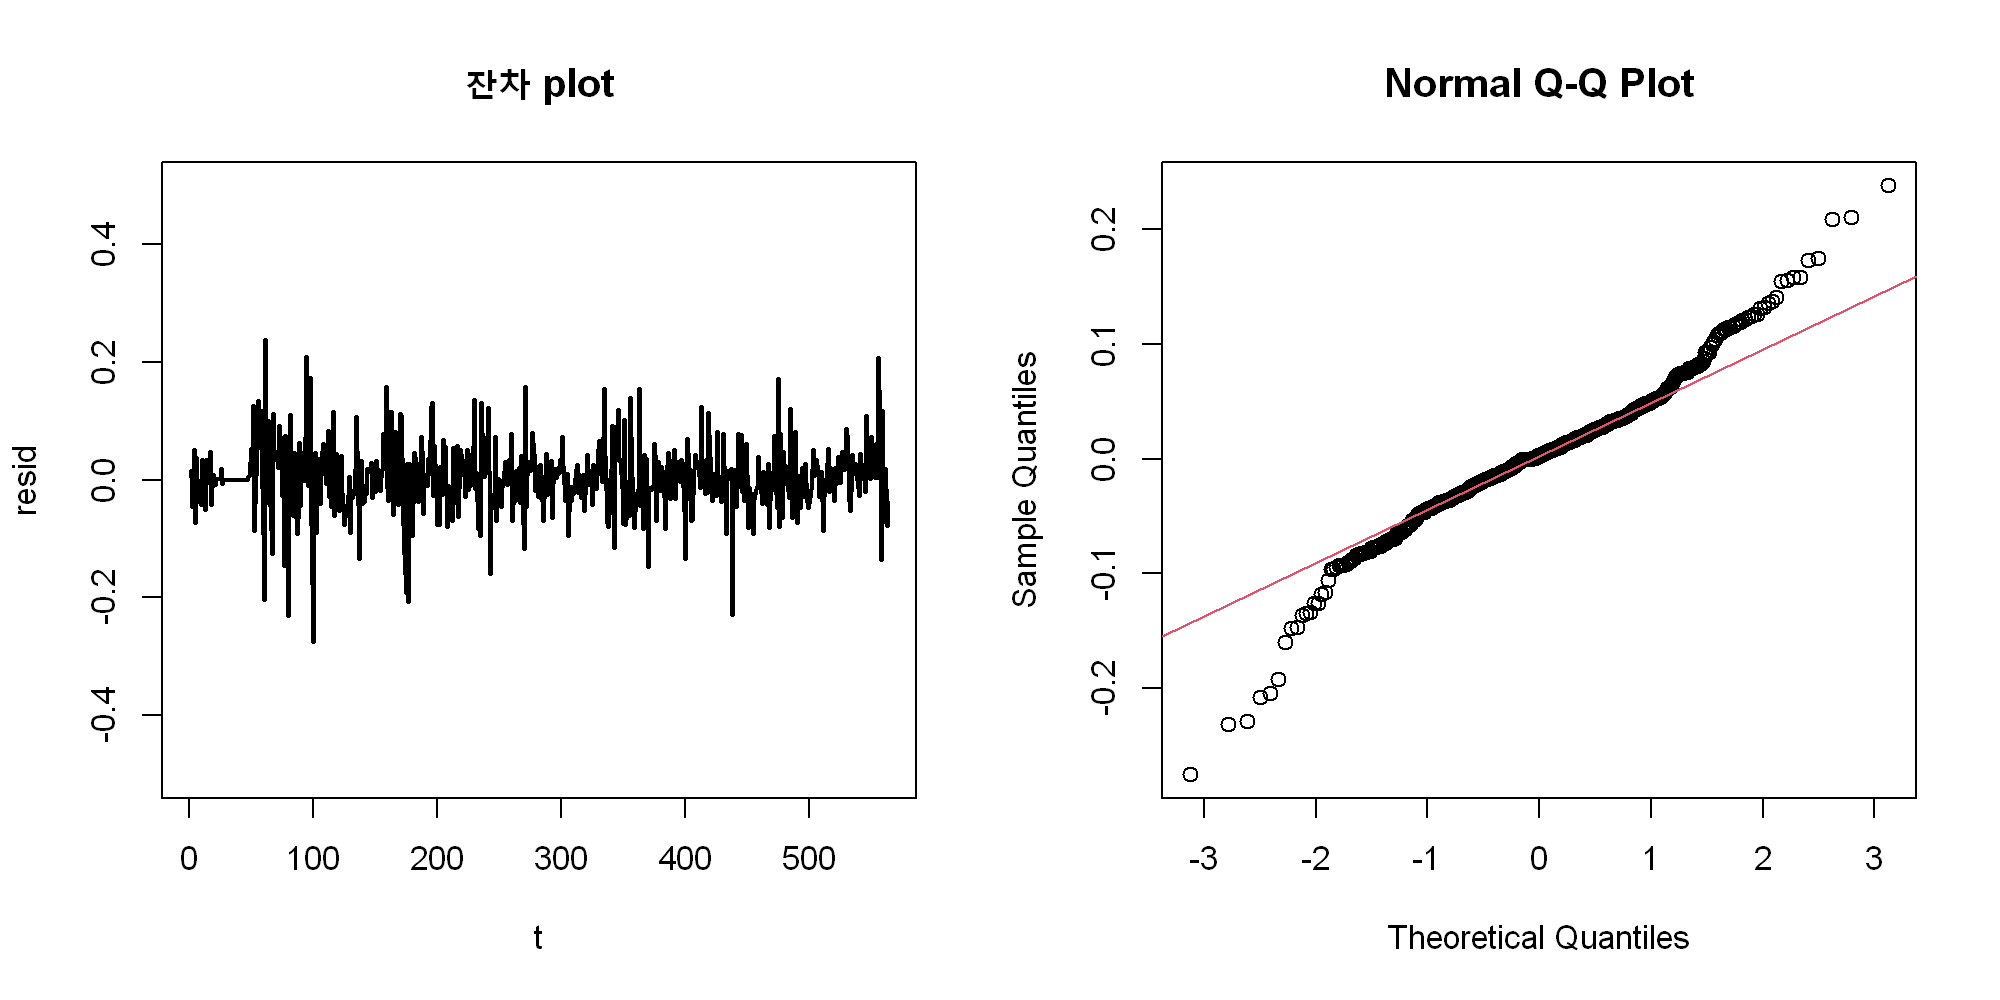

In [294]:
par(mfrow=c(1,2))
plot(data1 %>% select(t,resid),main="잔차 plot",lwd=2,type="l",ylim=c(-0.5,0.5))
qqnorm(resid1)
qqline(resid1,col=2)

* 잔차 plot을 그려본 결과 등분산성 가정은 위배되지 않는 것처럼 보이나 정규성 가정이 의심된다.

In [295]:
shapiro.test(data1$resid)  ##H0 : normal distribution
jarque.bera.test(data1$resid)  ##JB test H0: normal


	Shapiro-Wilk normality test

data:  data1$resid
W = 0.96372, p-value = 1.406e-10



	Jarque Bera Test

data:  data1$resid
X-squared = 156.13, df = 2, p-value < 2.2e-16


* 실제 검정결과 잔차의 정규성 가정이 위반되었다.

#### 잔차의 ACF, PACF 

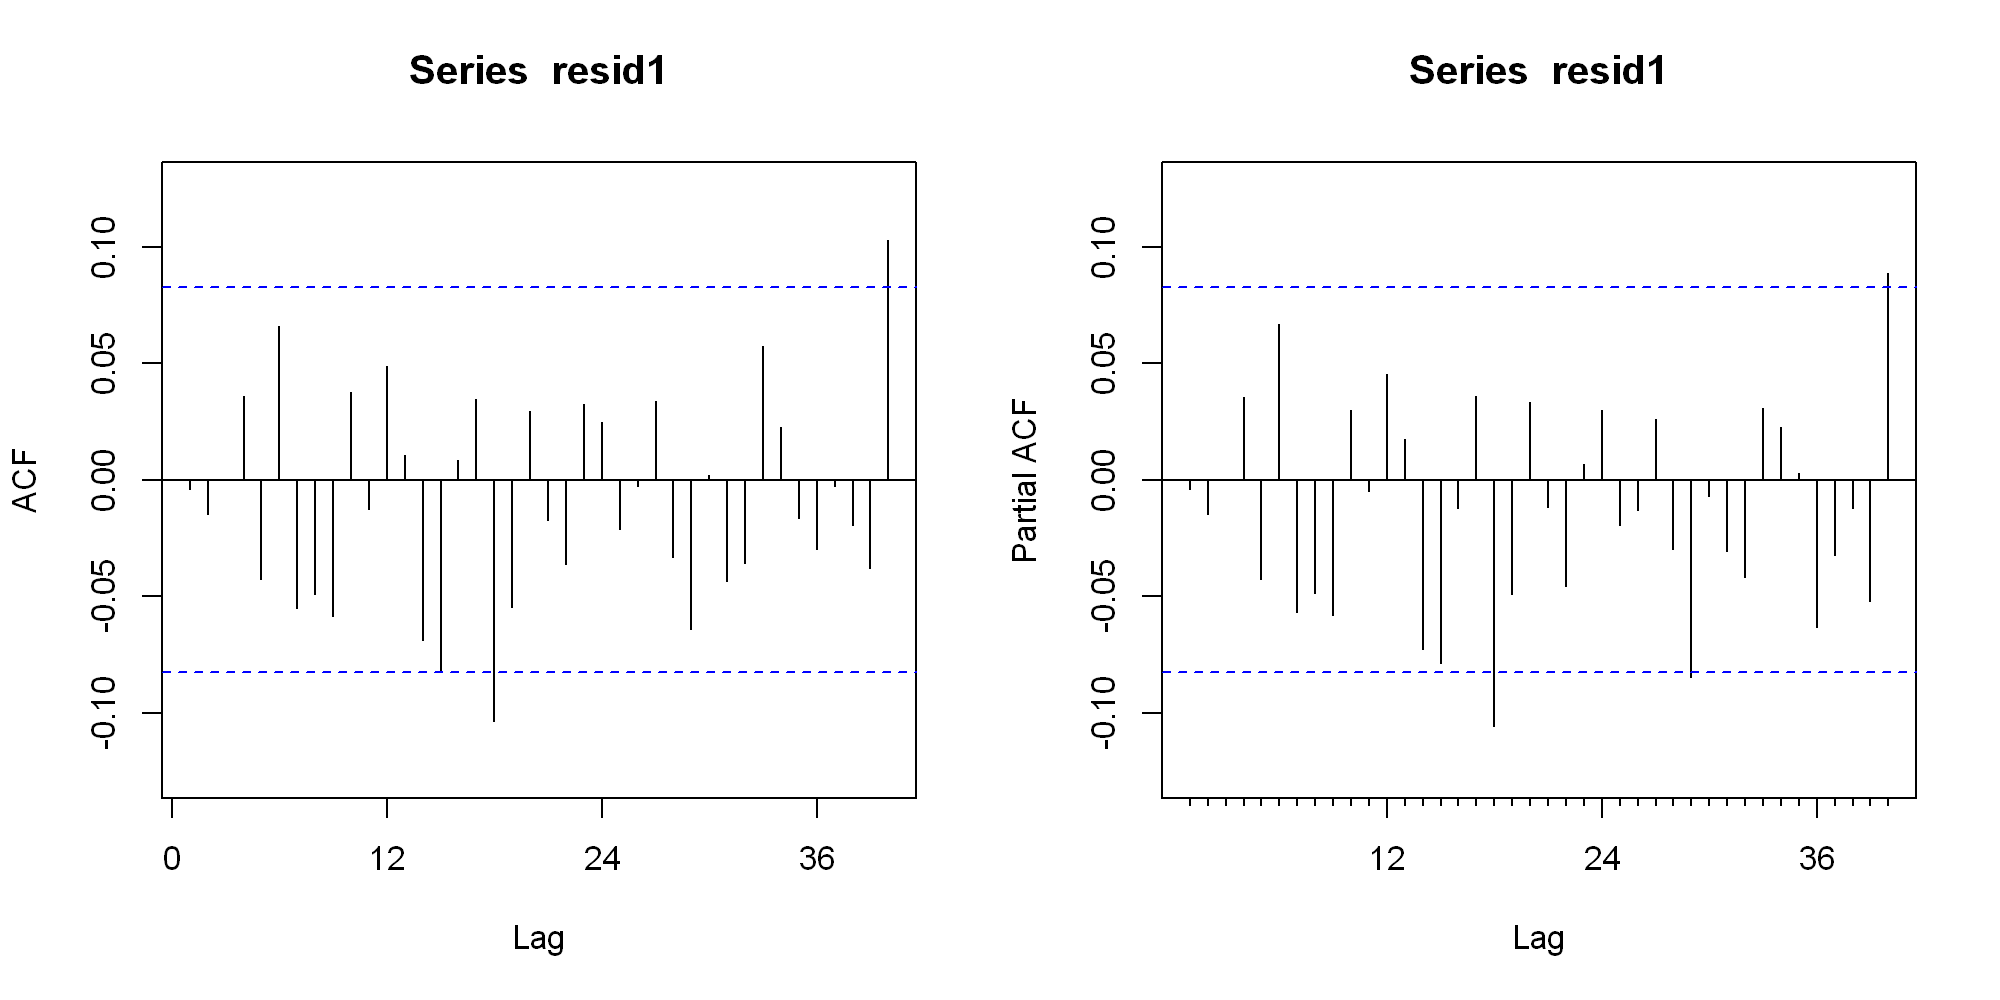

In [296]:
par(mfrow=c(1,2))
Acf(resid1,lag.max=40);Pacf(resid1,lag.max=40)

In [297]:
LjungBox(fit,lags=seq(6,24,6))

,lags,statistic,df,p-value
,6,4.389073,5,0.49486084
,12,11.774747,11,0.38081082
,18,25.513977,17,0.08378234
,24,29.716259,23,0.15772145


* ACF, PACF 값을 보아하니 시차가 큰 지점에서는 잔차의 자기상관성이 존재함을 보인다.

* lag 6을 기점으로 포트만 검정결과 해당 지점들에서의 자기상관성은 유의하지 않았다.

## (6)

 2007년과 2008년 데이터를 예측하여라.

### Solution

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2007,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651
2008,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651,8.127651


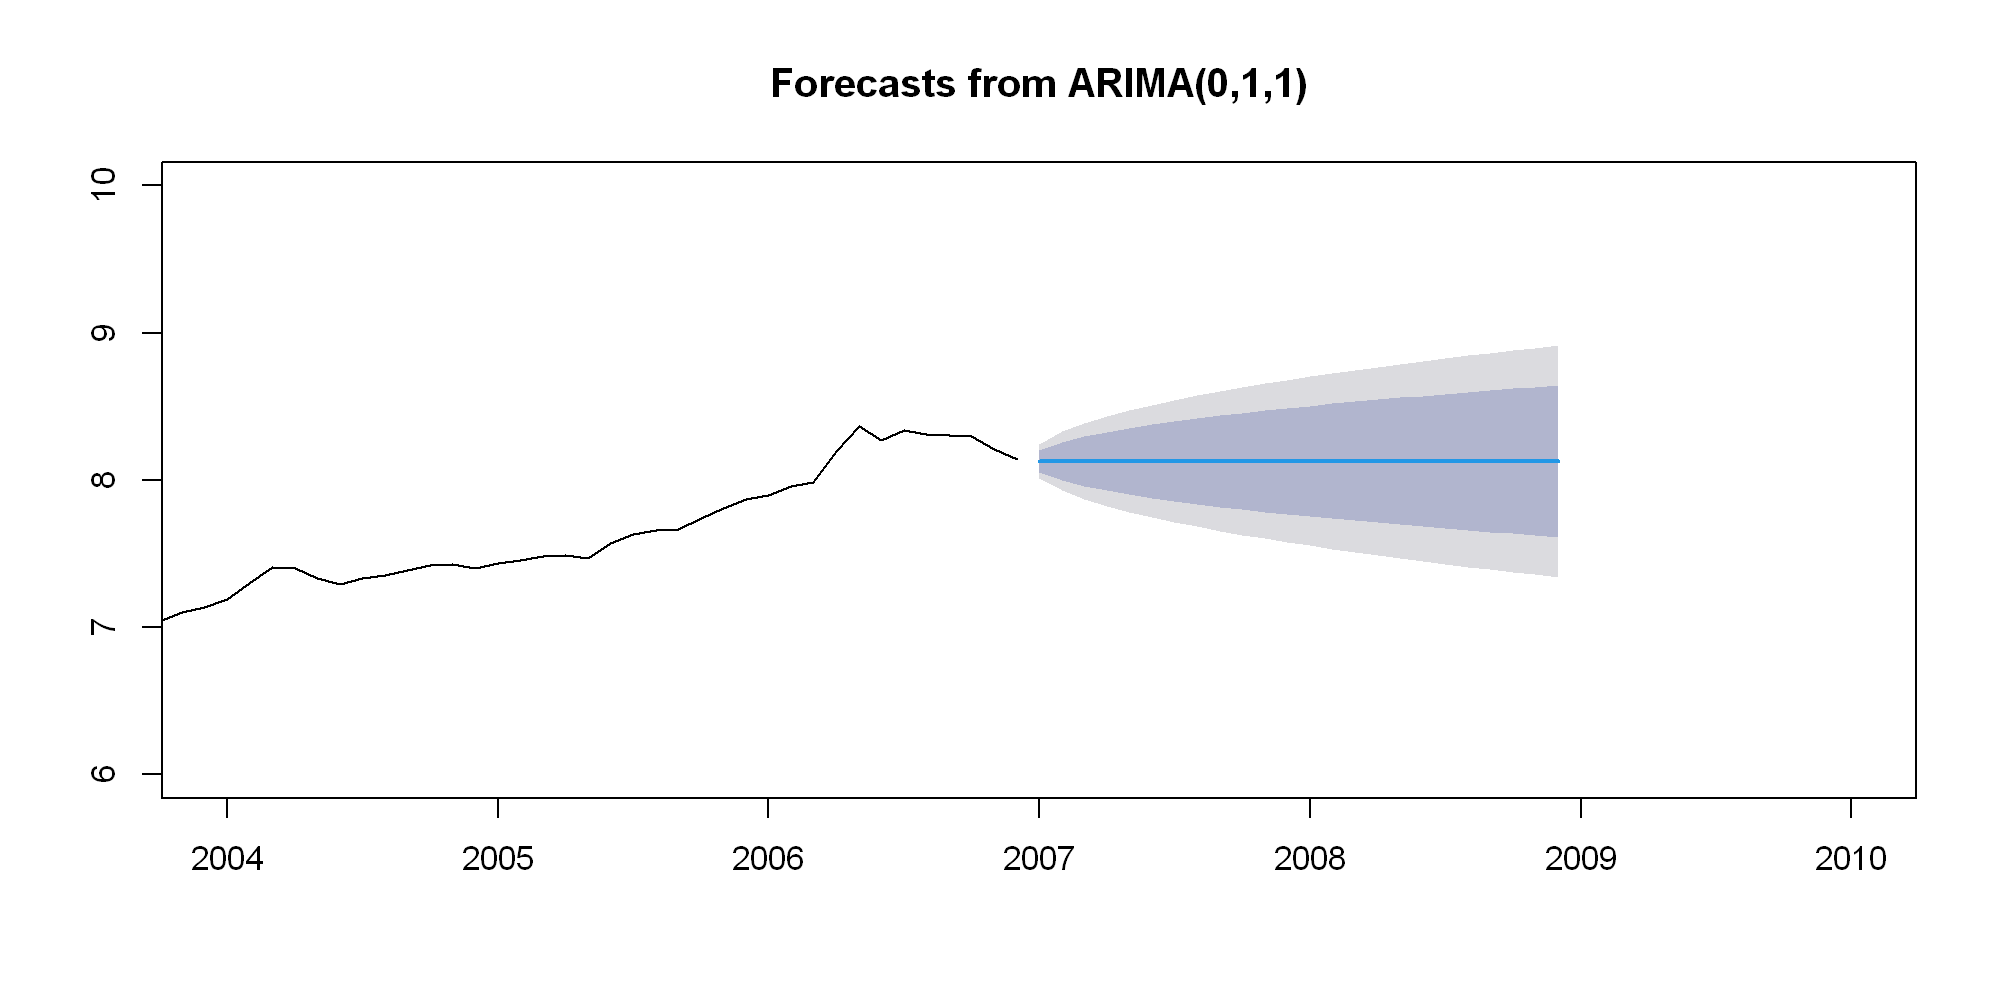

In [298]:
predict <- forecast(fit,h=24)
plot(predict,xlim=c(2004,2010),ylim=c(6,10))
predict$mean

* 예측값의 경우 특정한 값 = `8.127651` 으로 유지되는 경향을 보였다.

* 또한 시간이 지날수록 신뢰구간의 폭이 넓어짐을 확인하였다. 즉, 이로서 시계열자료의 불확실성은 시간의 흐름에 따라 커짐을 알 수 있었다.

***

# hsales

## (1)

변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.

### Solution

#### 시도표

* 주기가 12인 1973 ~ 1996 데이터임을 확인

In [299]:
glimpse(hsales)

 Time-Series [1:275] from 1973 to 1996: 55 60 68 63 65 61 54 52 46 42 ...


In [300]:
z <- hsales
t <- 1:length(z)
data2 <- tibble(t=t,z=z)

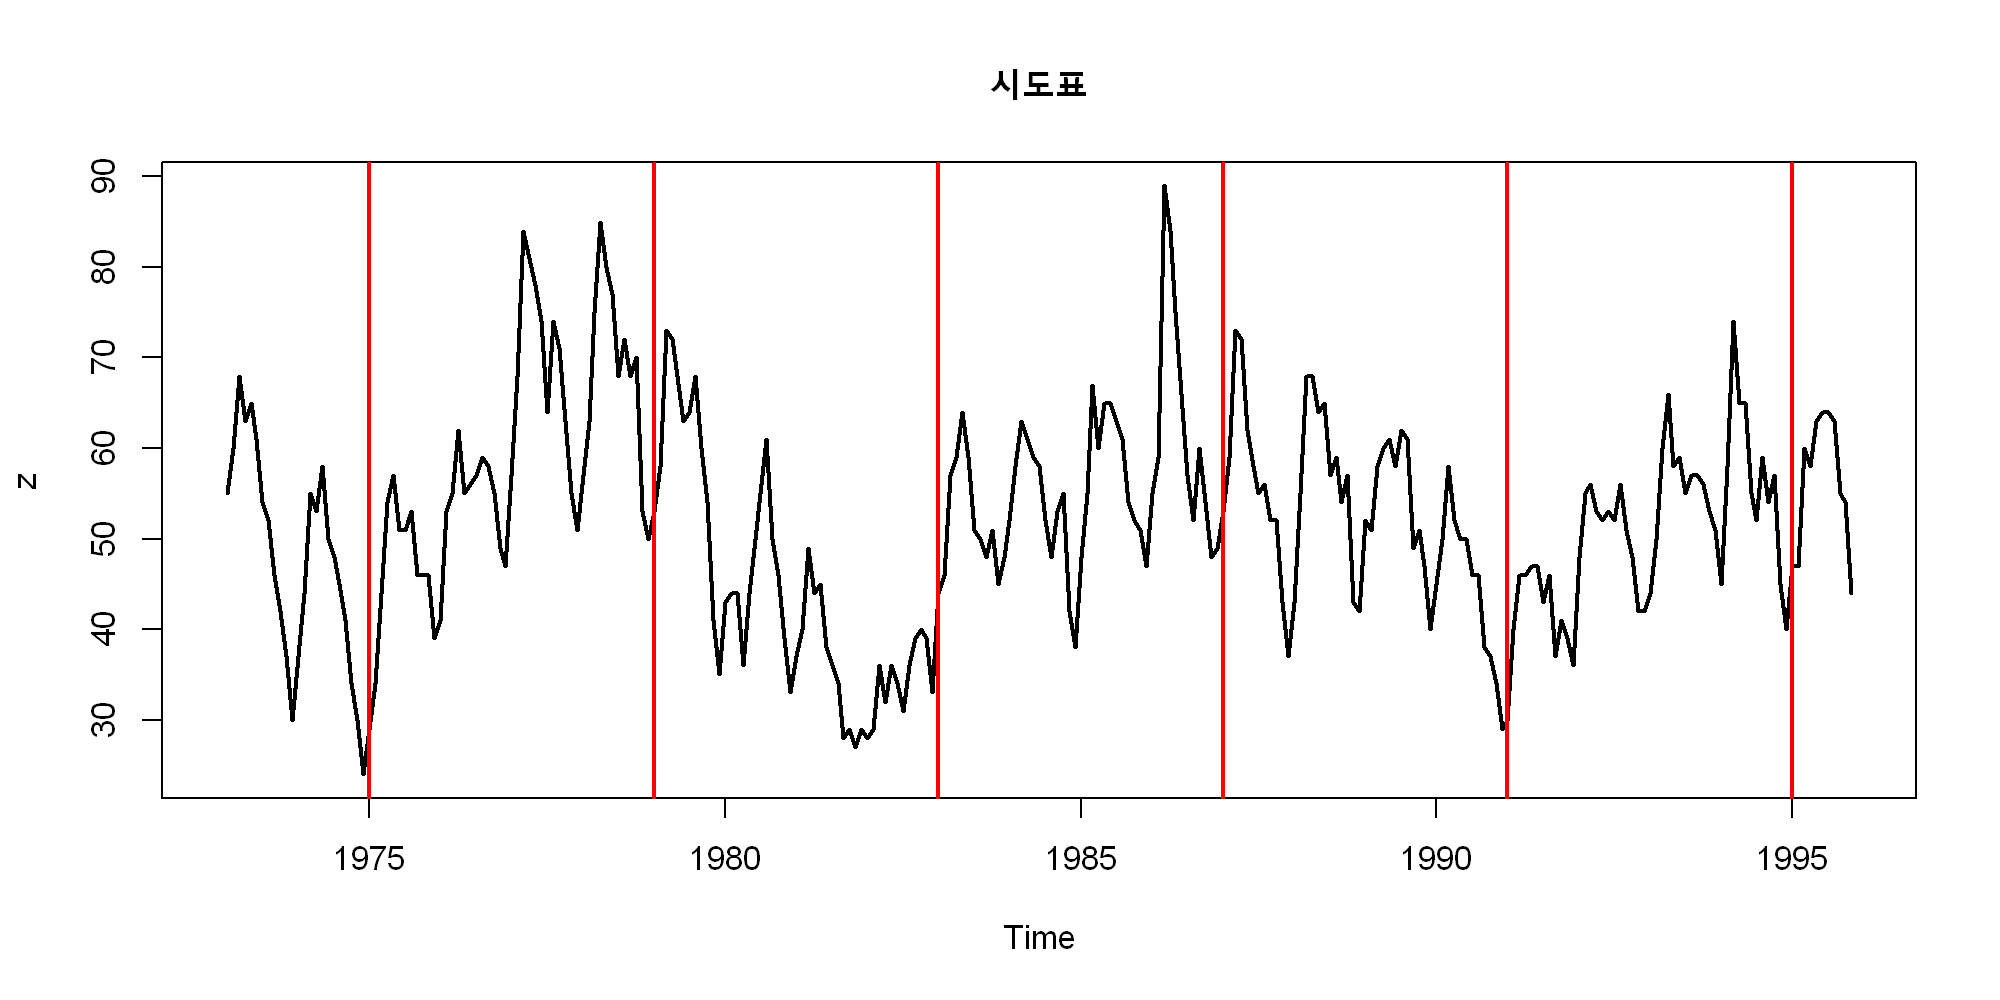

In [301]:
plot(z,lwd=2,main="시도표")
abline(v=seq(1975,1996,4),lwd=2,col="red")

* 변수변환이 필요한 것 같다. 미묘하게 계절성분이 관측됨과 동시에 이분산성도 관측되기 때문이다.

#### 변수변환

In [302]:
data2 <- data2 %>% mutate(ln_z = log(z),
                 sqrt_z = sqrt(z),
                 boxcox_z = BoxCox(z,lambda= BoxCox.lambda(z)))

In [303]:
gather_d =data2 %>% 
            gather(key="type",value="value",-t) %>% filter(!type %in%  "z")

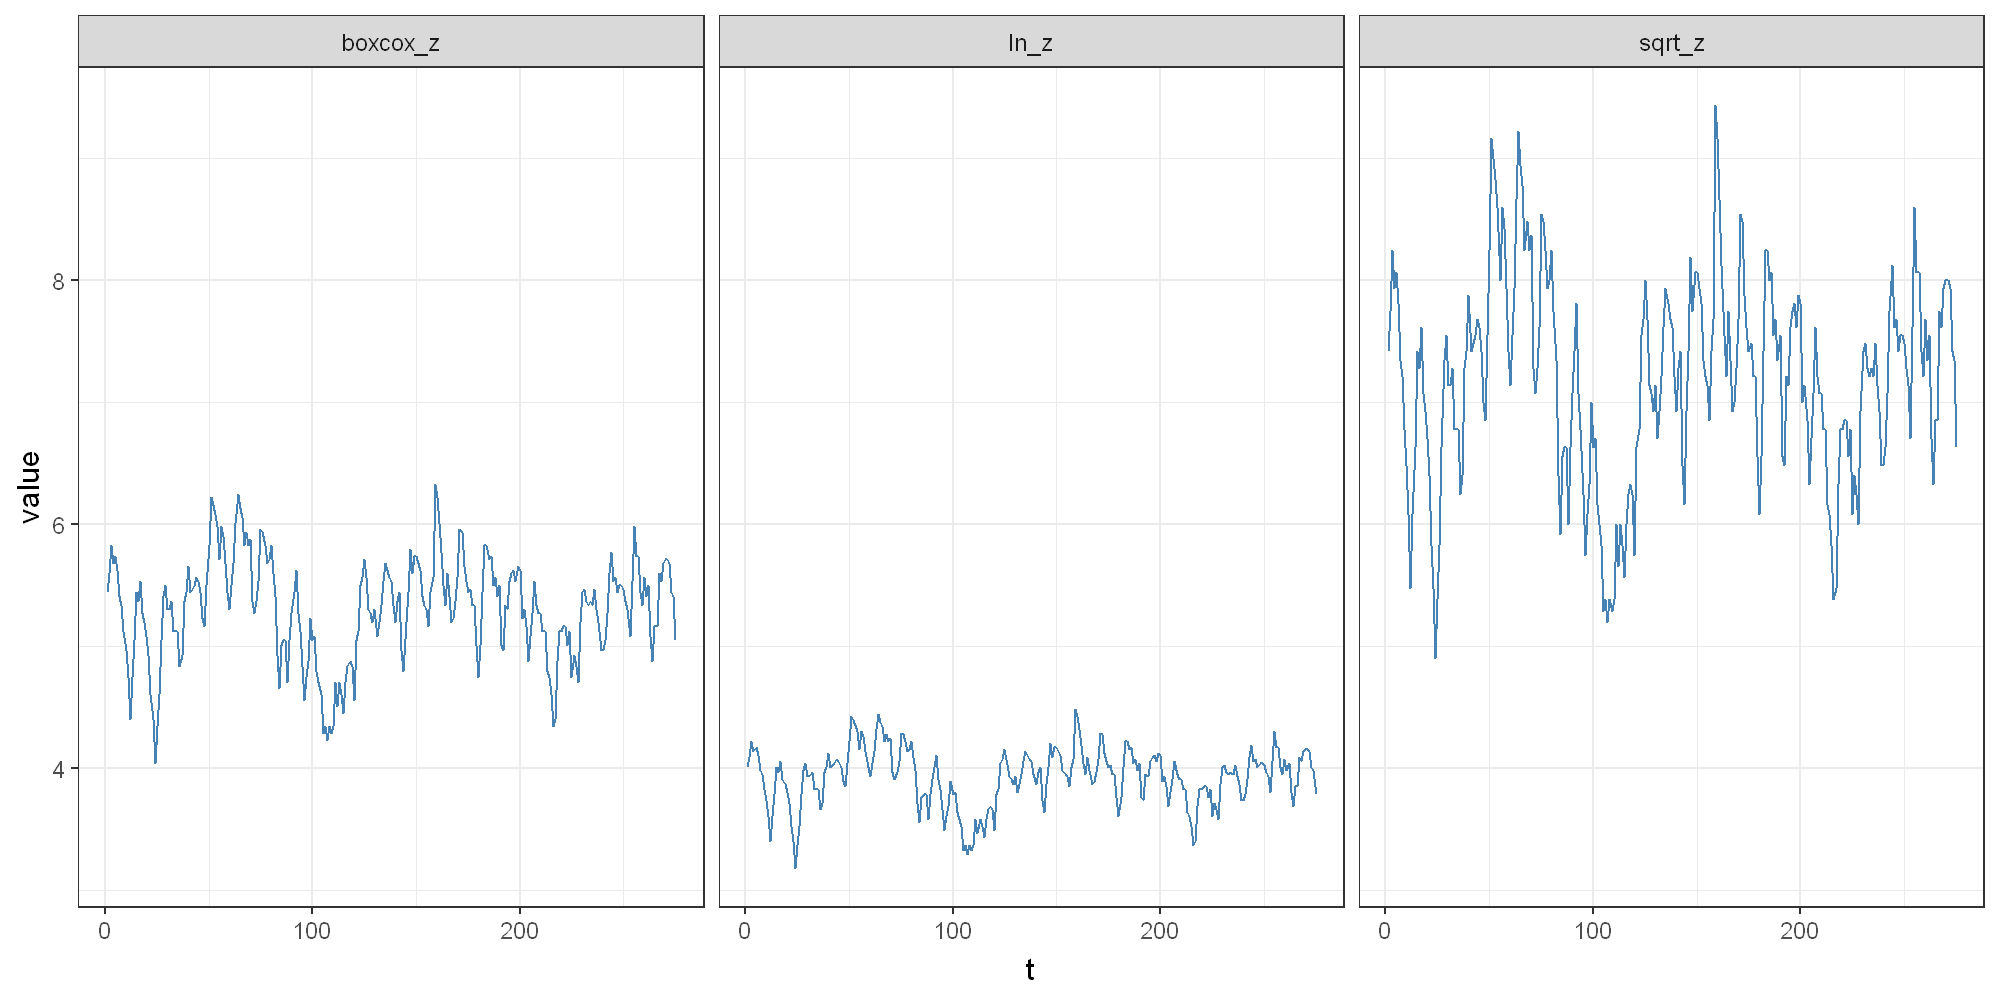

In [304]:
gather_d  %>% ggplot(aes(x=t,y=value)) +
                geom_line(col="steelblue") +
                facet_wrap(type~.) + theme_bw()

* 변환 결과로 보았을 때 로그변환을 한 경우가 가장 적절한 변환이 이루어진 것 같다. 따라서 로그변환을 선택하겠다.

## (2)

데이터가 정상시계열인가? 아니면 적절한 차분을 통해 정상시계열로 변환하여라.

### Solution

#### 로그 변환 후 시도표

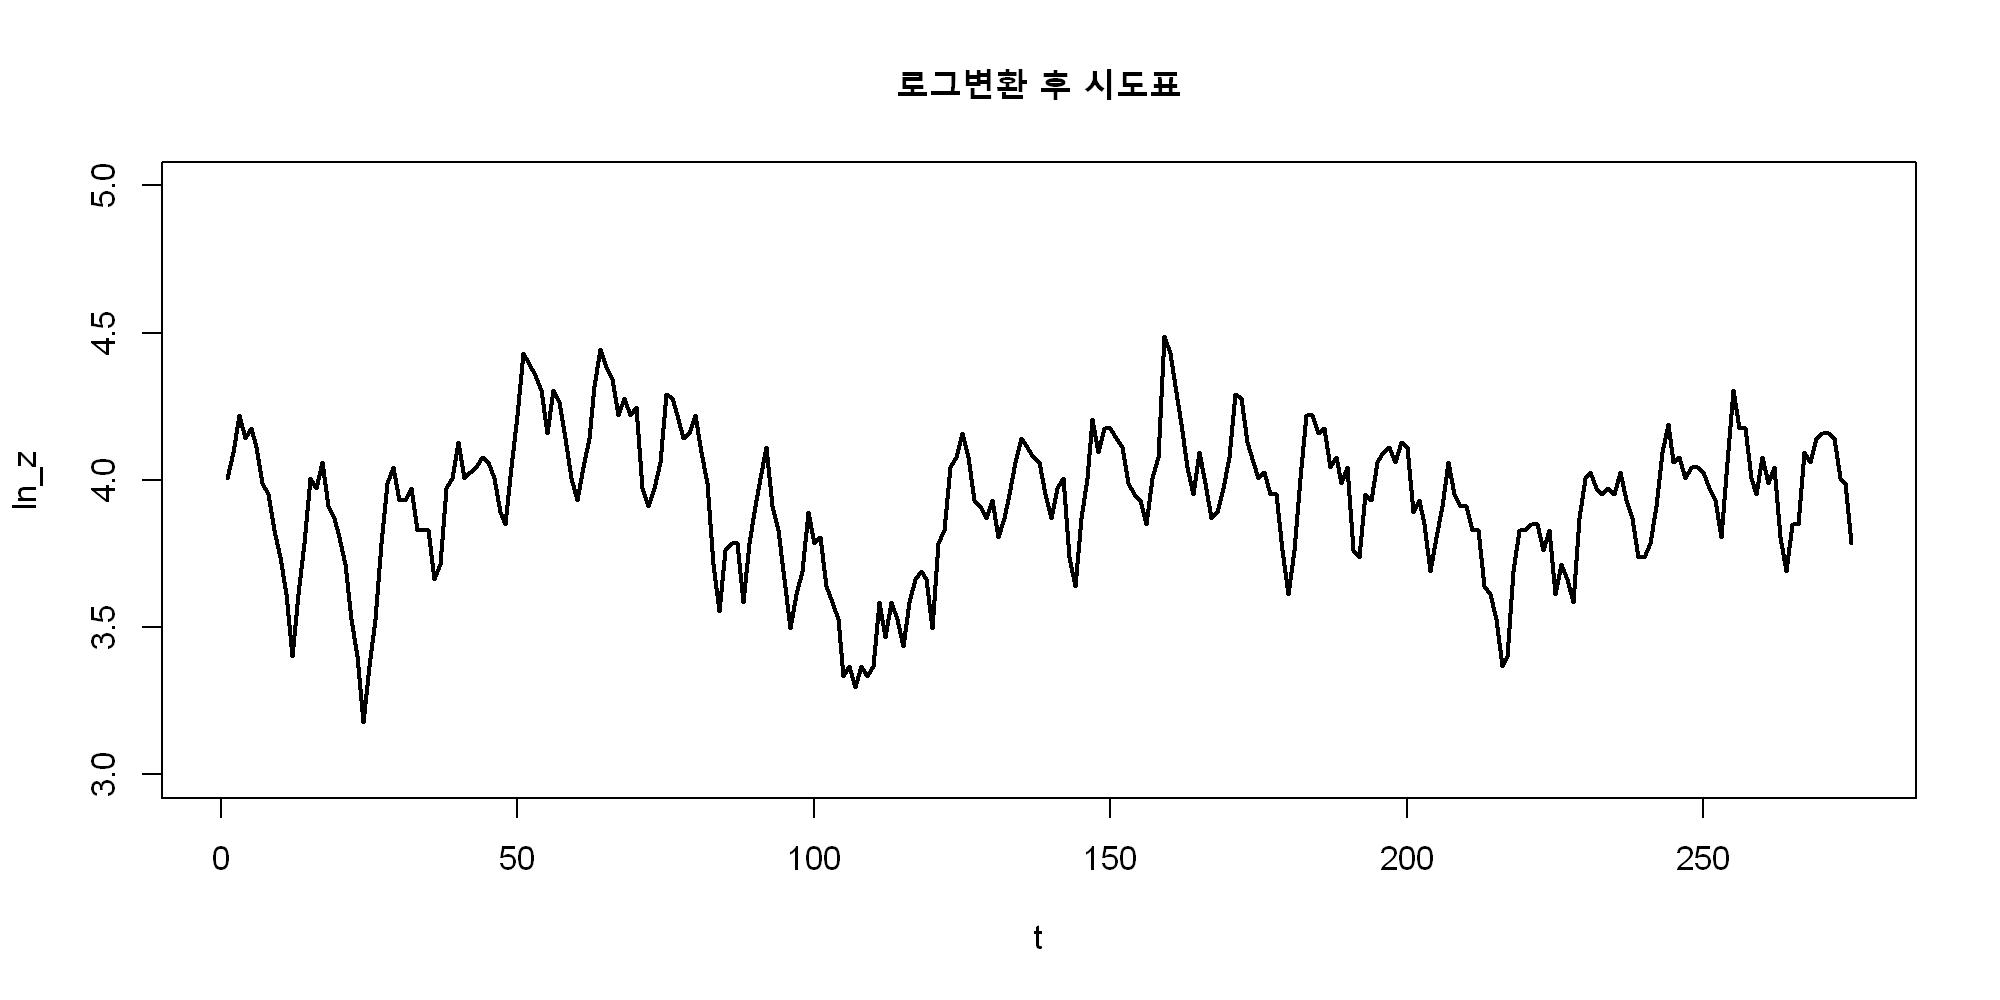

In [305]:
plot(data2 %>% select(t,ln_z),type="l",main="로그변환 후 시도표",lwd=2,ylim=c(3,5))

#### 로그 변환 후 ACF, PACF

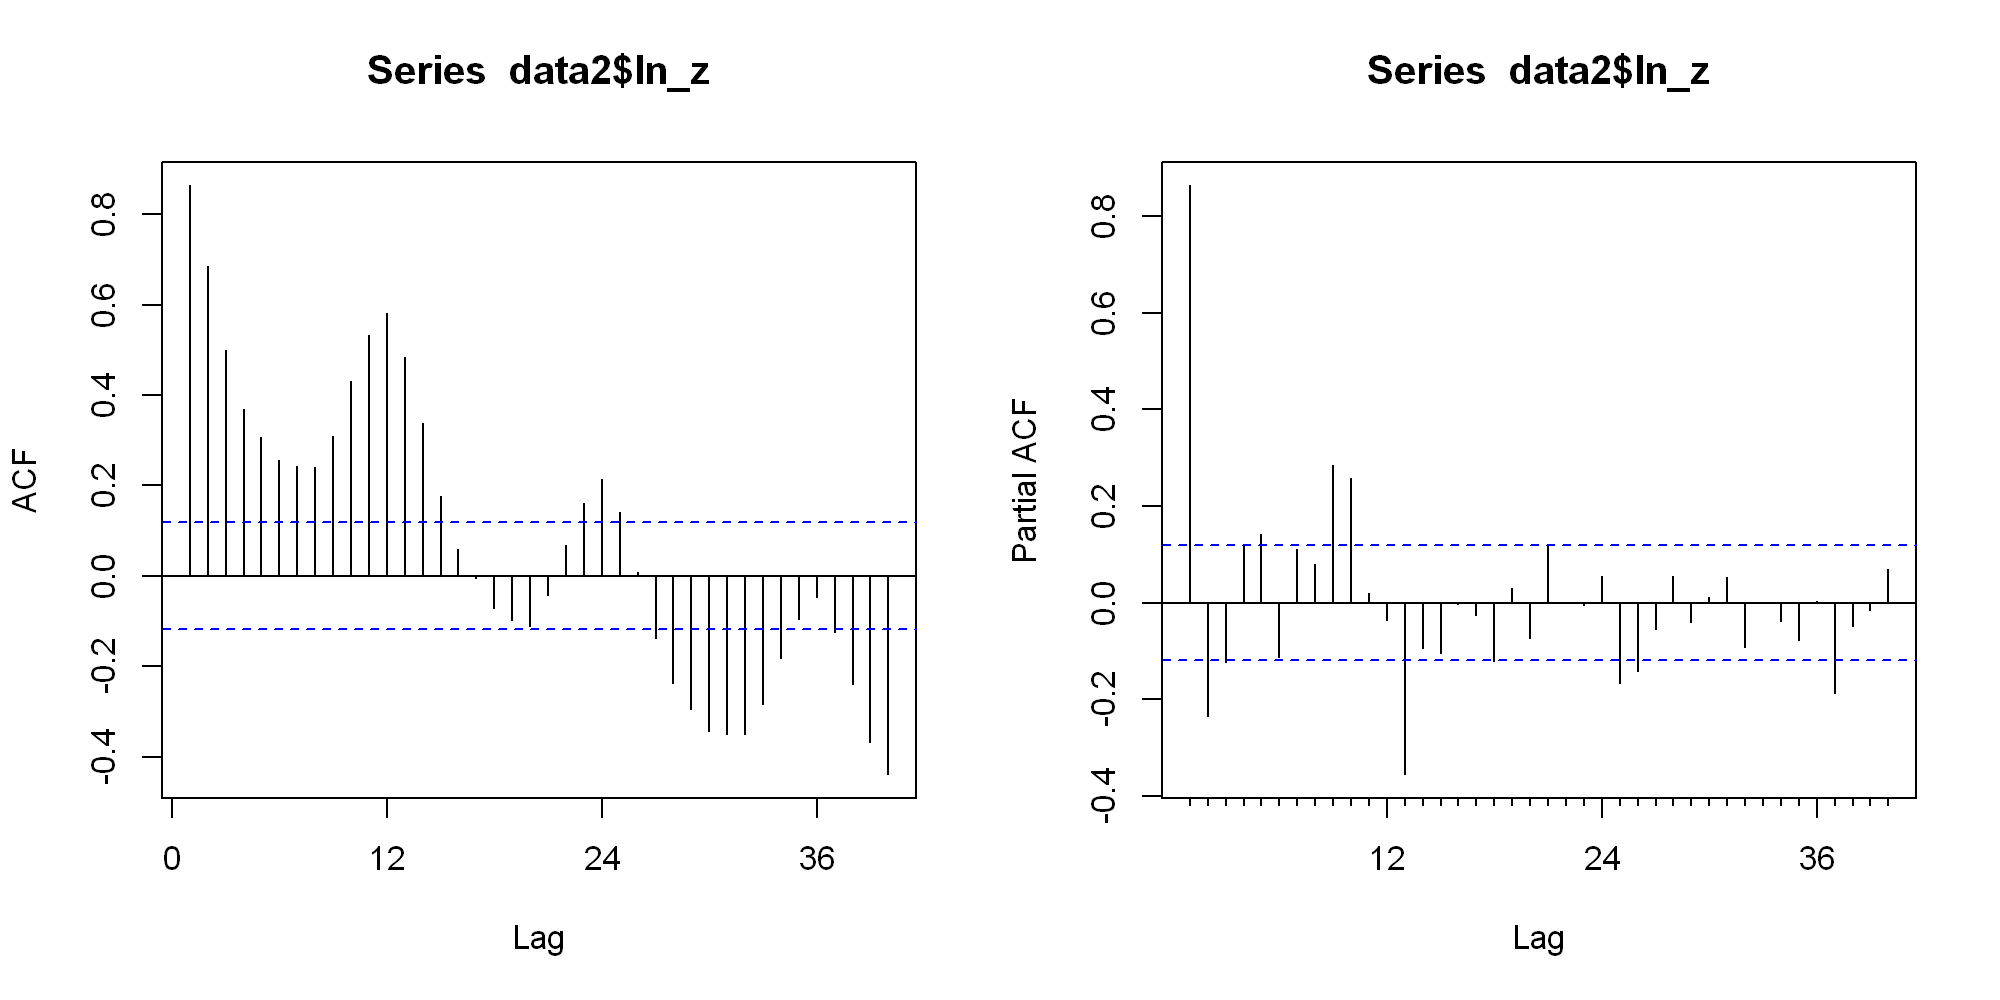

In [306]:
par(mfrow=c(1,2))
Acf(data2$ln_z,lag.max=40);Pacf(data2$ln_z,lag.max=40)

* 변환후 Acf, Pacf 도표를 보았을 때 확률적 추세 및 확률적 계절성분을 가지고 있다고 판단된다.

* 따라서 차분을 시행 후 다시 확인해보겠다.

#### 로그변환 + 1차 차분

In [307]:
data2  <- data2 %>% 
            mutate(diff_lnz = c(0,diff(ln_z)))

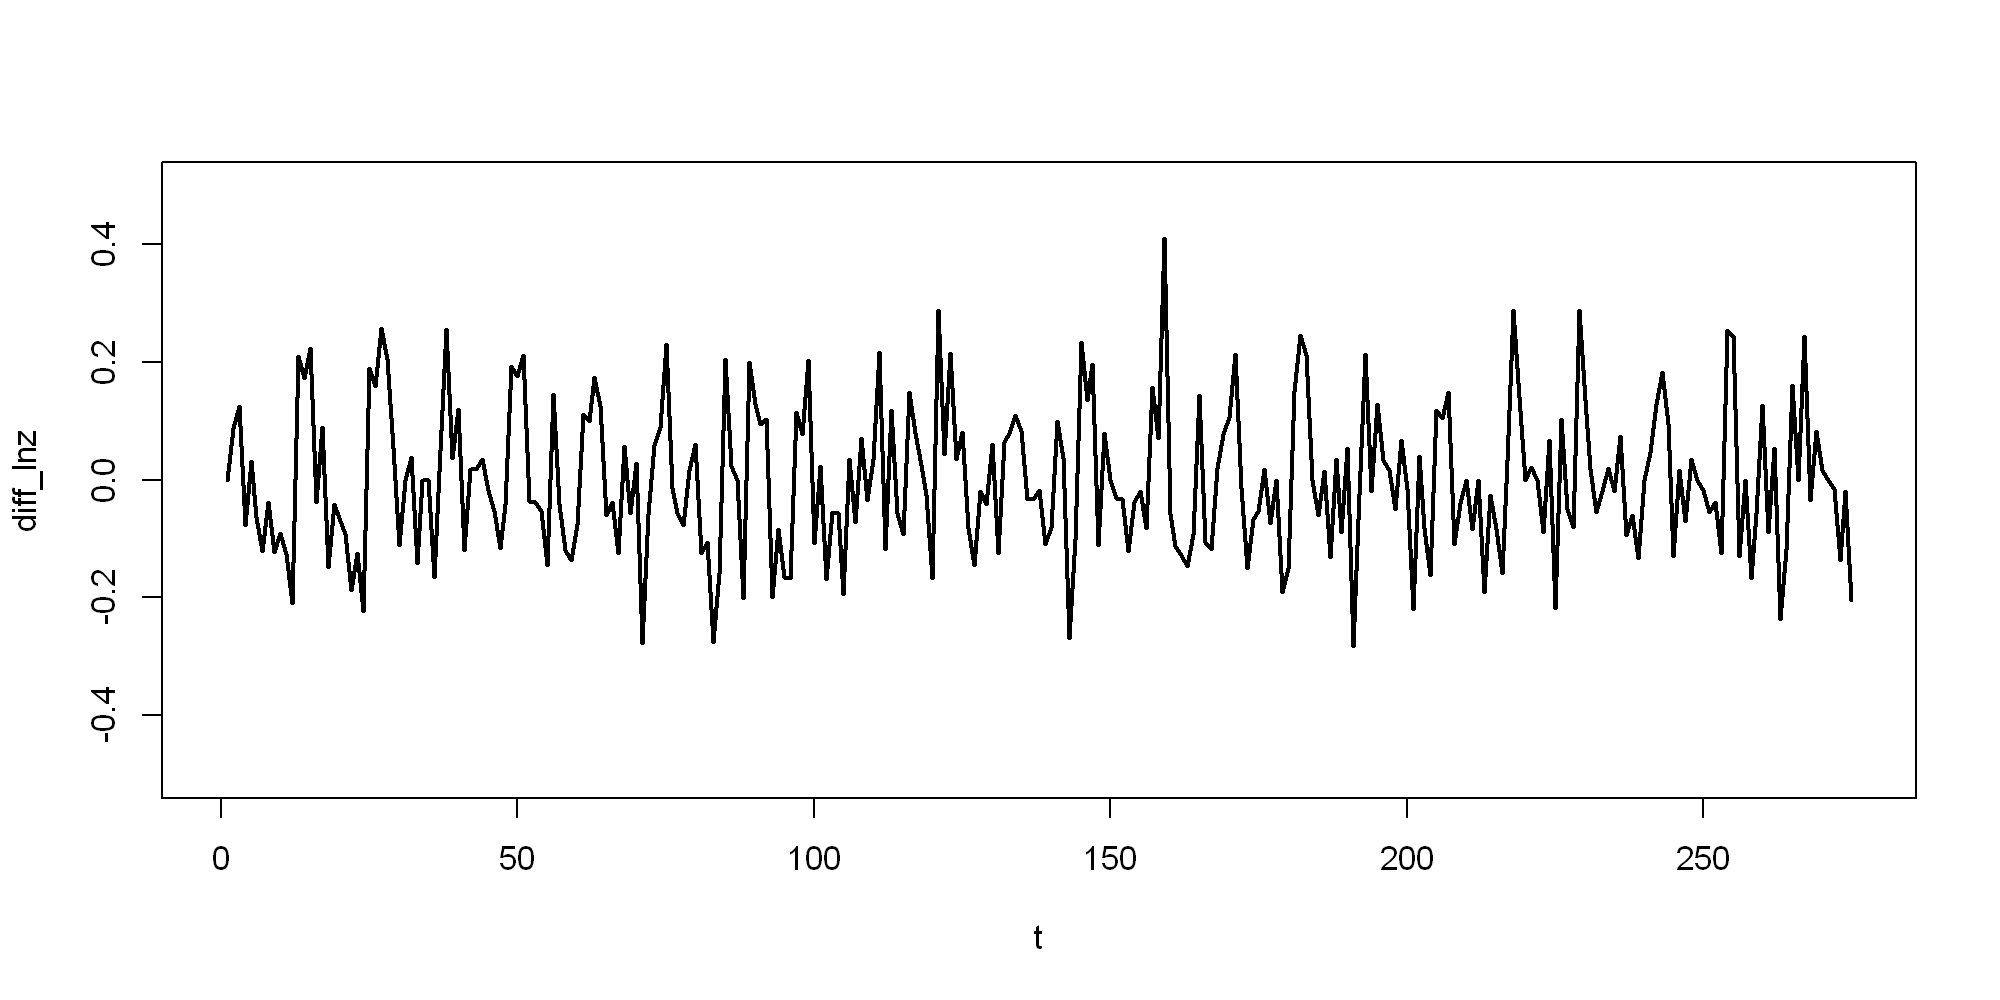

In [308]:
plot(data2 %>% select(t,diff_lnz),type="l",lwd=2,ylim=c(-0.5,0.5))

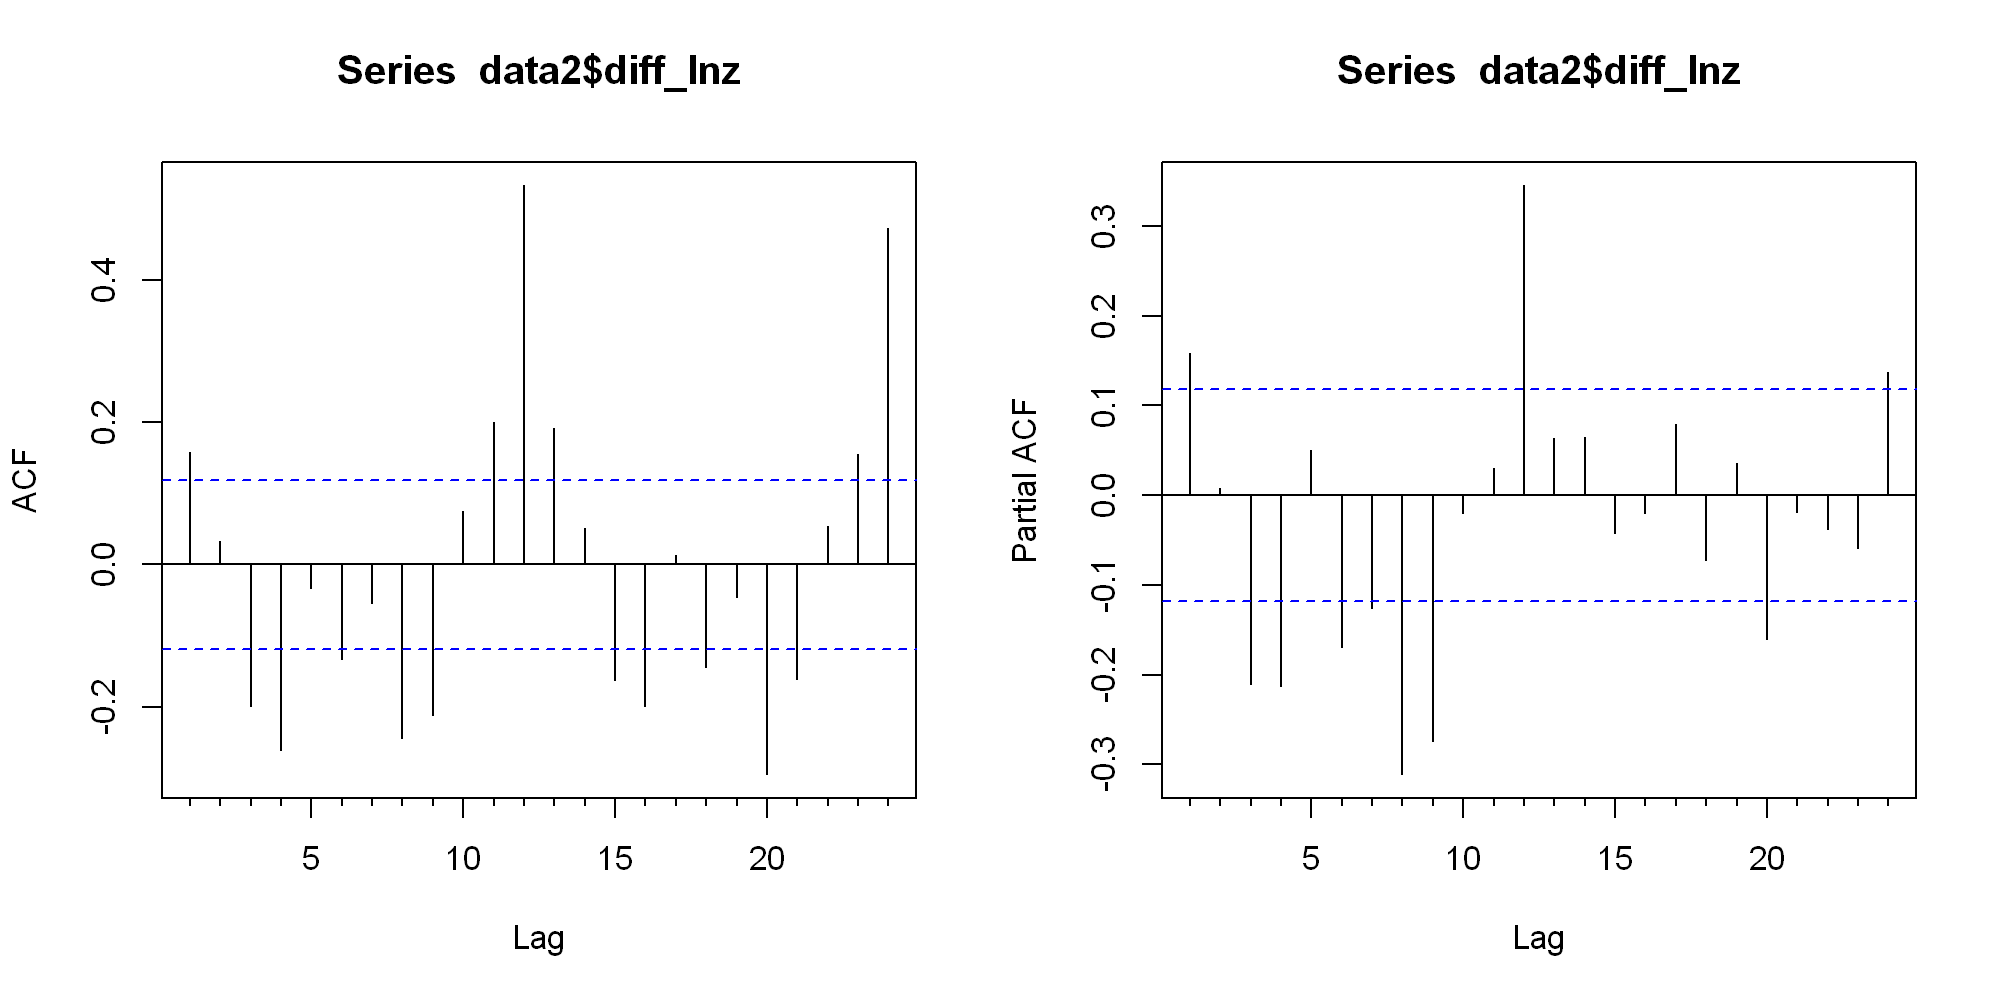

In [67]:
par(mfrow=c(1,2))
Acf(data2$diff_lnz); Pacf(data2$diff_lnz)

* acf와 pacf 값을 살펴본 결과 여전히 확률적 계절성분이 존재하는 것처럼 보인다.

* 따라서 계절차분을 통해 다시 한번 검토

#### 로그변환 + 1차 차분 + 계절 차분

In [309]:
data2 <- data2 %>% 
                 mutate(diff_lnz_s =c(rep(0,12),diff(diff_lnz,12)))

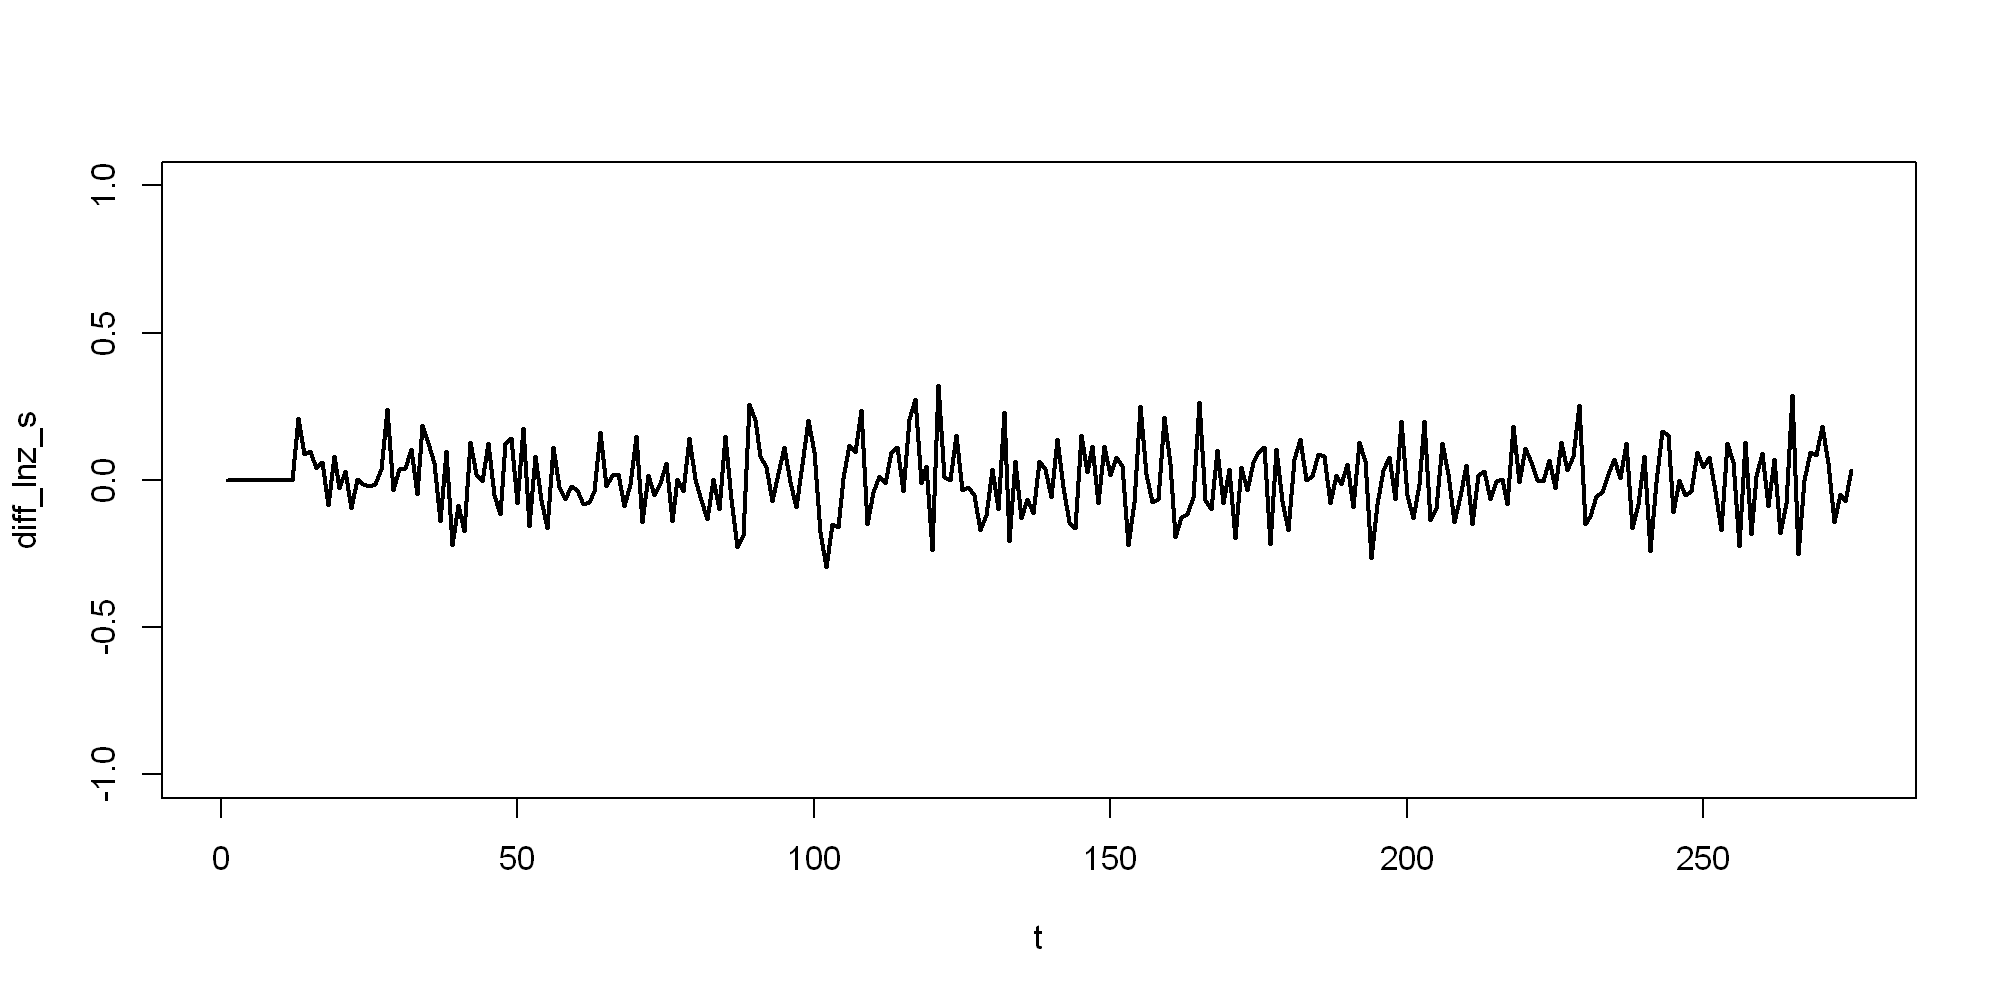

In [312]:
plot(data2 %>% select(t,diff_lnz_s),type="l",lwd=2,ylim=c(-1,1))

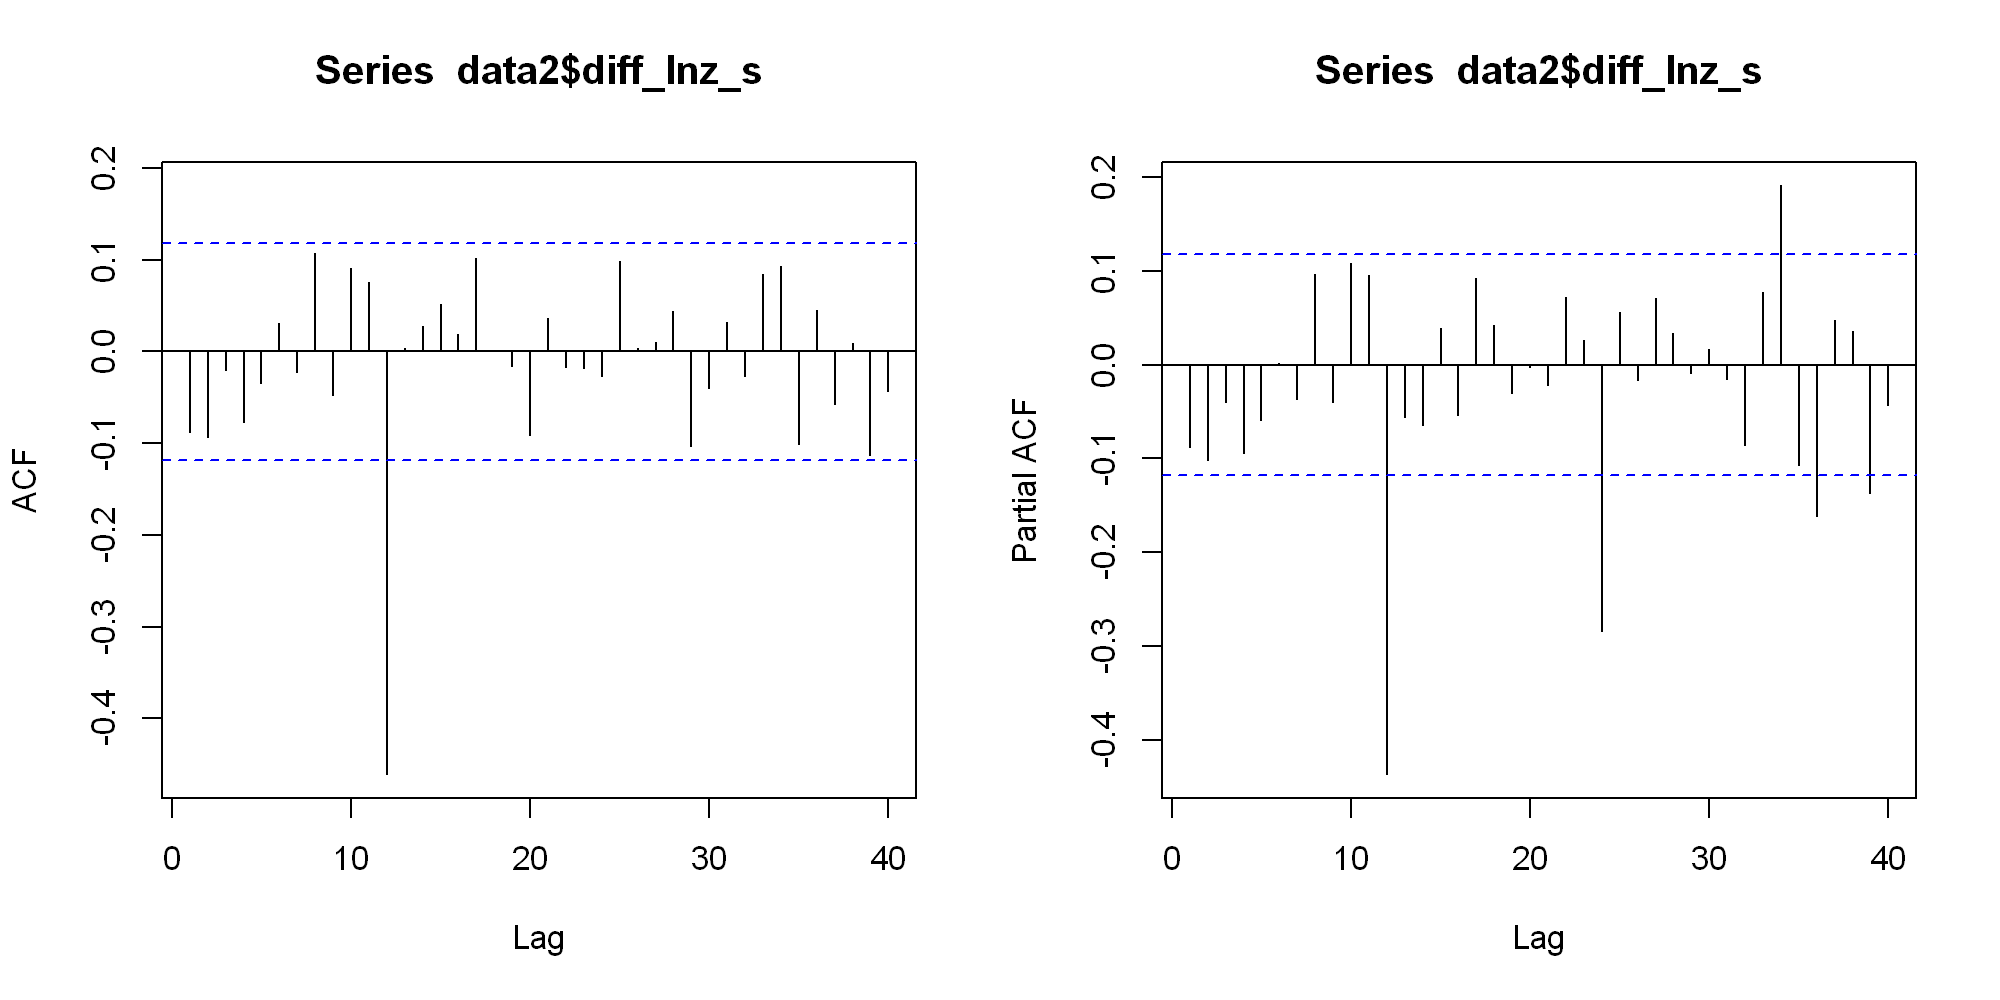

In [313]:
par(mfrow=c(1,2))
Acf(data2$diff_lnz_s,lag.max=40); Pacf(data2$diff_lnz_s,lag.max=40)

In [314]:
adfTest(data2$diff_lnz_s,lags=0,type="c")
adfTest(data2$diff_lnz_s,lags=1,type="c")
adfTest(data2$diff_lnz_s,lags=2,type="c")


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -18.0098
  P VALUE:
    0.01 

Description:
 Fri Dec 10 14:18:19 2021 by user: rkdcj



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -13.4235
  P VALUE:
    0.01 

Description:
 Fri Dec 10 14:18:19 2021 by user: rkdcj



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -10.7704
  P VALUE:
    0.01 

Description:
 Fri Dec 10 14:18:19 2021 by user: rkdcj


* 시도표를 보아 차분한 데이터가 등분산성이라고 판단된다.

* ACF, PACF 값을 보아도 정상시계열인 계절형 ARMA 모형을 고려할 수 있을 것 같다.

* 또한 단위근 검정결과 귀무가설을 기각하지 못해 단위근이 존재하지 않는다고 판단된다.

* 따라서 **"로그변환과 1차차분 및 계절 차분을 통한 데이터를 정상시계열이라고"** 정의하겠다.

## (3)

모형을 식별하여라. (2개 이상의 모형 고려)(형태 : ARIMA(p.d.q)(P,D,Q)s)

### Solution

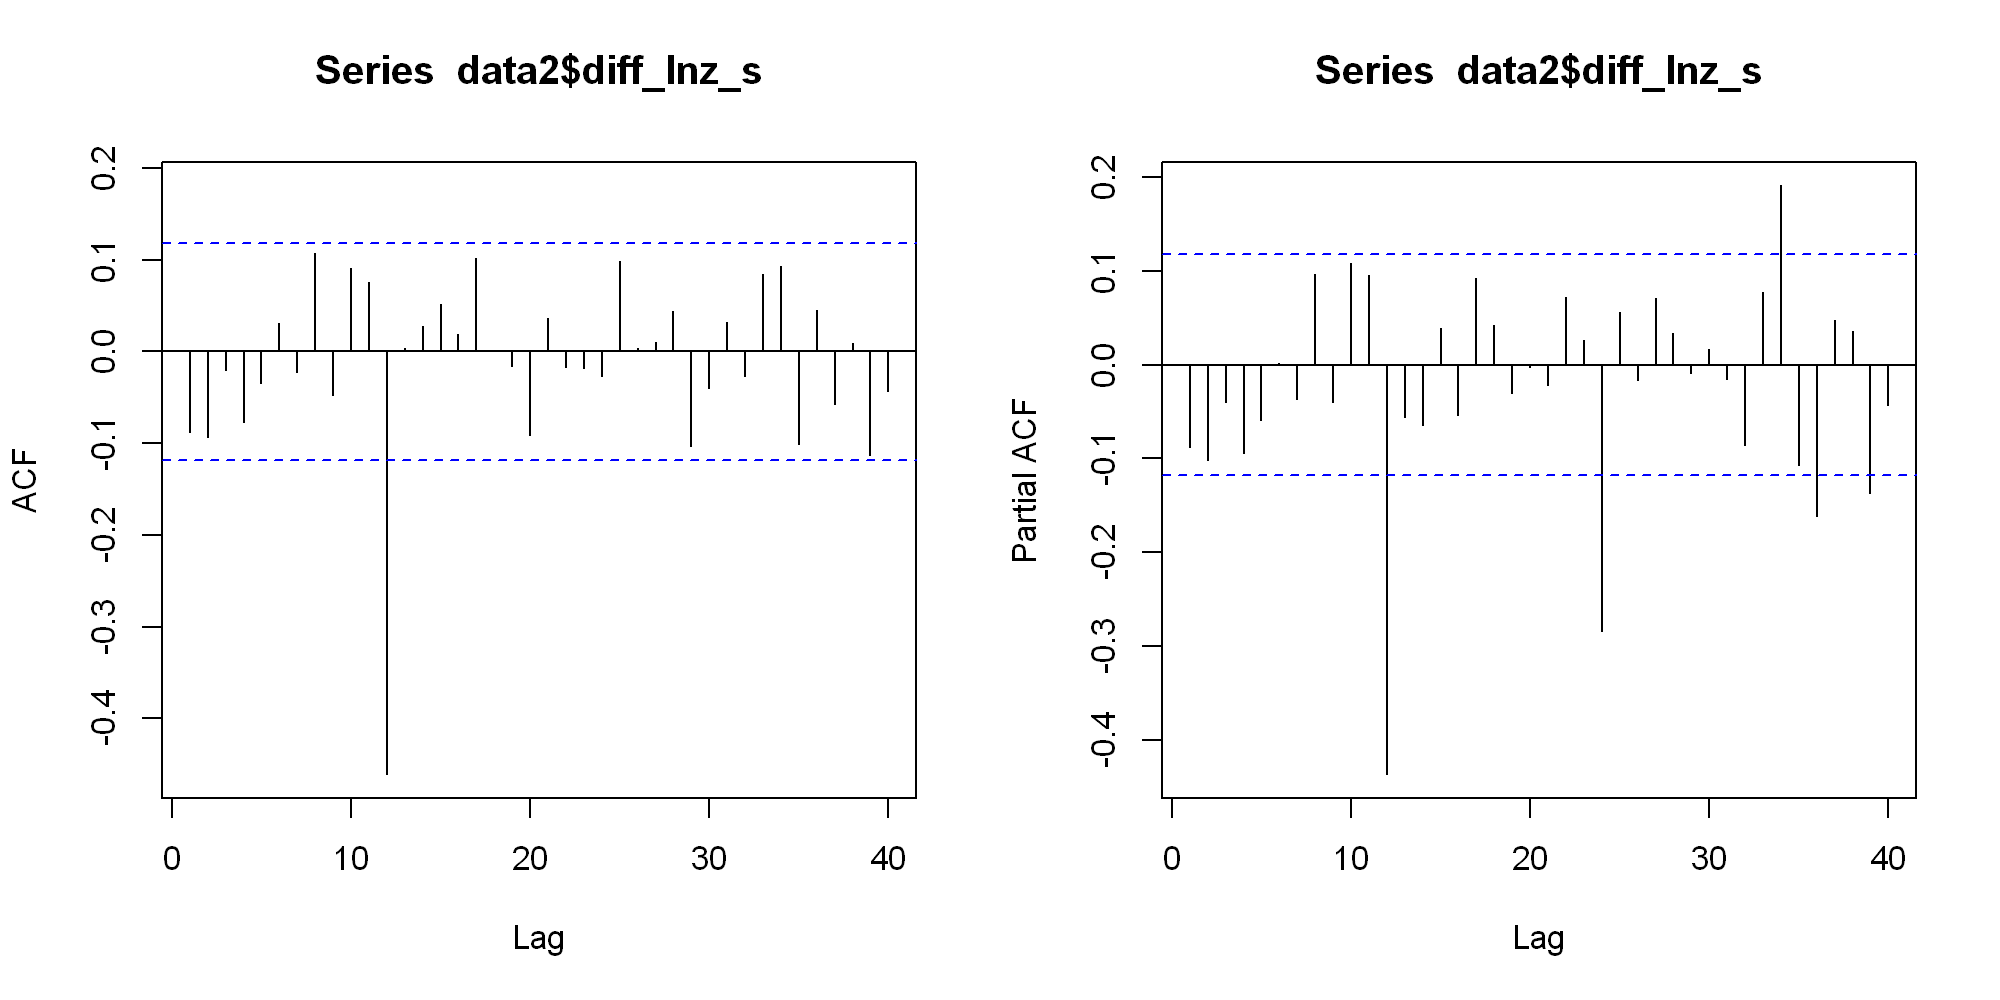

In [315]:
par(mfrow=c(1,2))
Acf(data2$diff_lnz_s,lag.max=40); Pacf(data2$diff_lnz_s,lag.max=40)

* 로그변환과 1차 차분 및 계절 차분을 거친 데이터를 보았을 때

* acf와 pacf를 보아 2가지의 모형을 고려할 수 있다.

* acf값 기준`SMA(1)`모형과 pacf값 기준 `SAR(2)`,`SAR(3)` 모형을 고려할 수 있다.

* `SAR(3)` 까지는 모형이 너무 복잡해져 과적합 문제가 의심되므로 고려하지 않겠다.

* 따라서 주기가 12인 **ARMIA(0, 1, 0)(0, 1, 1)와  ARMIA(0, 1, 0)(2, 1, 0)** 로 모형을 생각해보겠다.

## (4)

(3)에서 고려한 모형을 적합하여라.

### Solution

#### SMA(1) 

In [316]:
sma1_fit <- arima(data2$diff_lnz_s,order=c(0,1,0),
                                    seasonal = list(order=c(0,1,1), period=12))

In [317]:
sma1_fit


Call:
arima(x = data2$diff_lnz_s, order = c(0, 1, 0), seasonal = list(order = c(0, 
    1, 1), period = 12))

Coefficients:
         sma1
      -1.0000
s.e.   0.0337

sigma^2 estimated as 0.03039:  log likelihood = 67.15,  aic = -130.31

In [319]:
sma1_fit$coef

sma1 
-0.9999992

#### SAR(2)

In [320]:
sar2_fit <- arima(data2$diff_lnz_s,order=c(0,1,0),
                                    seasonal = list(order=c(2,1,0), period=12))

In [321]:
sar2_fit


Call:
arima(x = data2$diff_lnz_s, order = c(0, 1, 0), seasonal = list(order = c(2, 
    1, 0), period = 12))

Coefficients:
         sar1     sar2
      -1.0110  -0.5703
s.e.   0.0515   0.0508

sigma^2 estimated as 0.03437:  log likelihood = 61.84,  aic = -117.68

In [324]:
sar2_fit$coef

sar1       sar2 
-1.0109772 -0.5702758

## (5)

(4)에서 적합된 결과를 이용하여 더 좋은 모형을 선택하여라.

### Solution

In [325]:
mse <- rep(c(sma1_fit$sigma2,sar2_fit$sigma2))
aic  <- rep(c(sma1_fit$aic,sar2_fit$aic))
label <- rep(c("SMA(1)","SAR(2)"))

In [326]:
summary_table <- tibble(label,mse,aic) %>% gather(key="var",value="value",-label)

In [327]:
summary_table

label,var,value
<chr>,<chr>,<dbl>
SMA(1),mse,0.03038583
SAR(2),mse,0.03437251
SMA(1),aic,-130.30950077
SAR(2),aic,-117.68258879


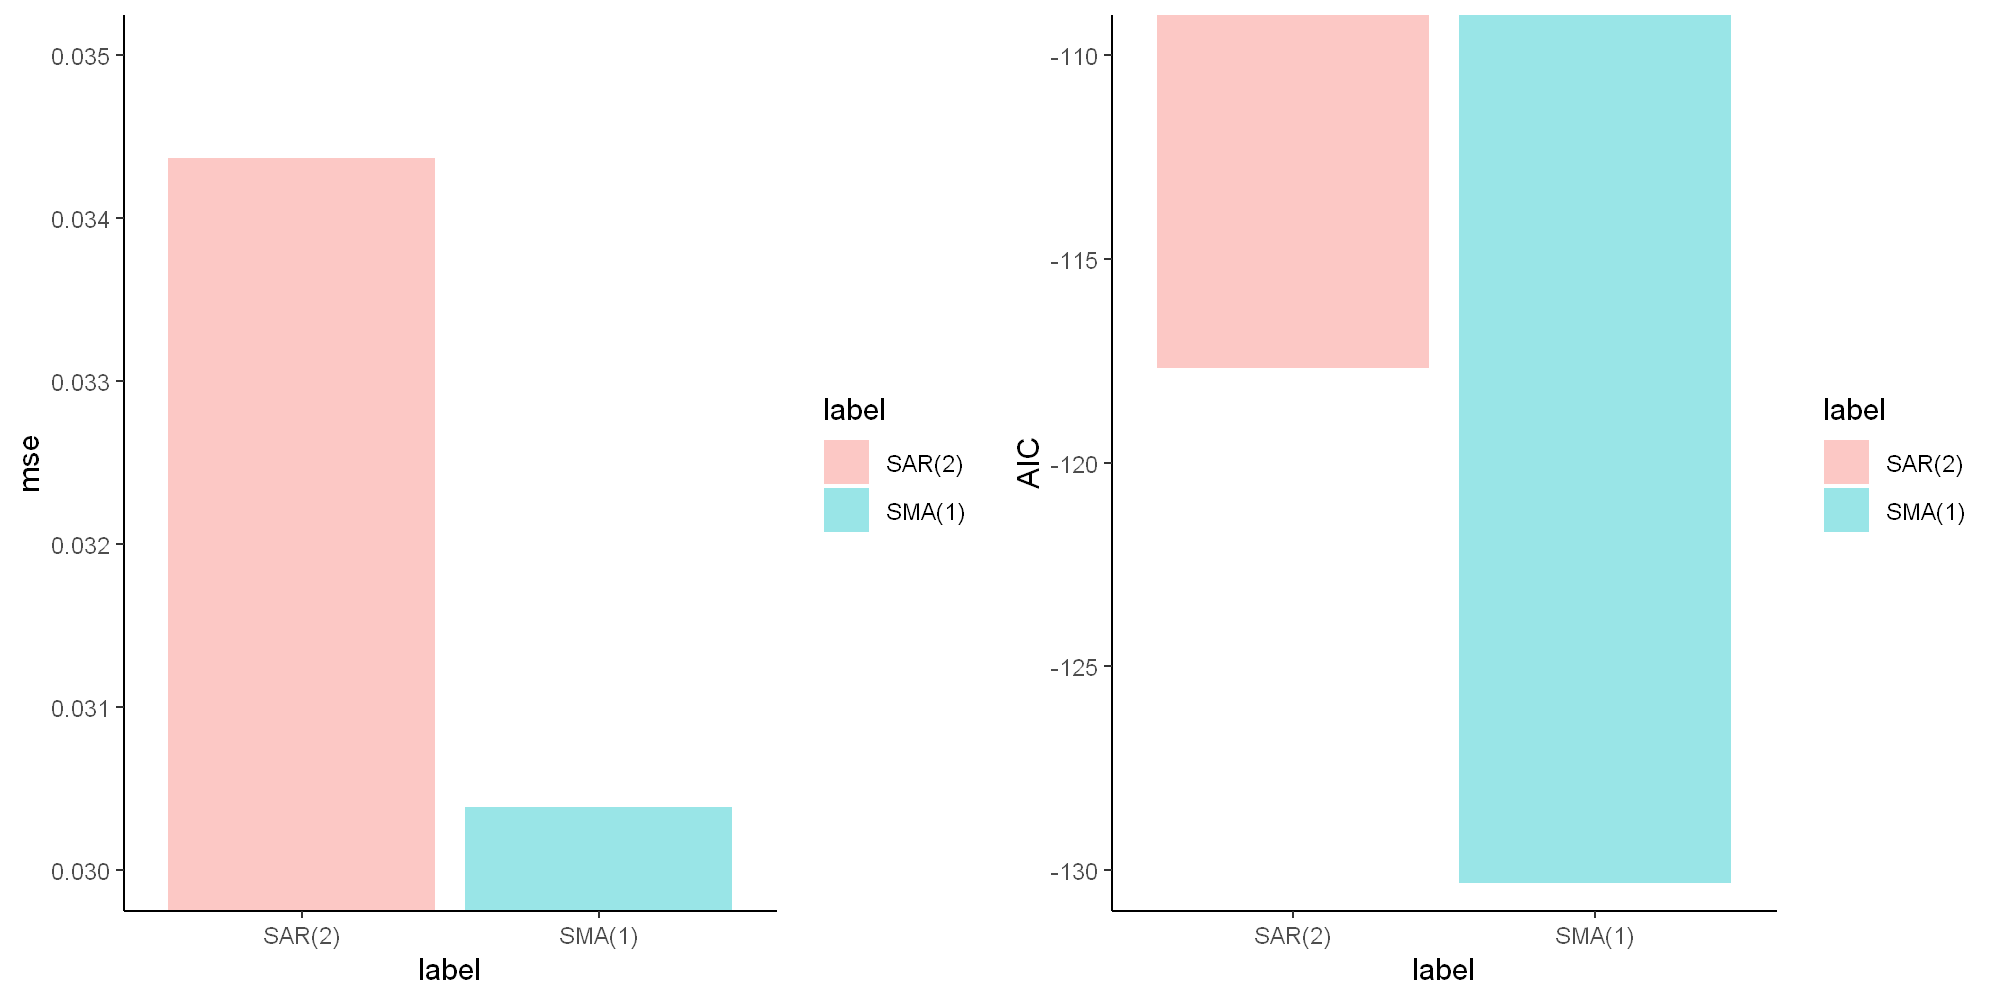

In [328]:
g1 <- summary_table %>% filter(var %in% c("mse"))  %>% 
  ggplot() +
  geom_bar(aes(x=label,y=value,fill=label),stat="identity",alpha=0.4) +
  theme_classic() +
  coord_cartesian(ylim=c(0.03,0.035))+
  labs(y="mse")
g2 <- summary_table %>% filter(var %in% c("aic"))  %>% 
  ggplot() +
  geom_bar(aes(x=label,y=value,fill=label),stat="identity",alpha=0.4) +
  theme_classic() +
  coord_cartesian(ylim=c(-130,-110)) +
  labs(y="AIC")
grid.arrange(g1, g2, ncol=2)

* `mse`와 `aic` 기준으로 보았을 때 `sma(1)` 더 좋은 모형으로 판단된다.

* 따라서 최종 모형으로 **sma(1)** 채택하겠다.

## (6)

(5) 에서 선택한 모형을 이용하여 잔차검정을 시행하여라.

### Solution

#### 잔차 정규성, 등분산성 검증

In [329]:
data2["resid"] <- resid(sma1_fit)

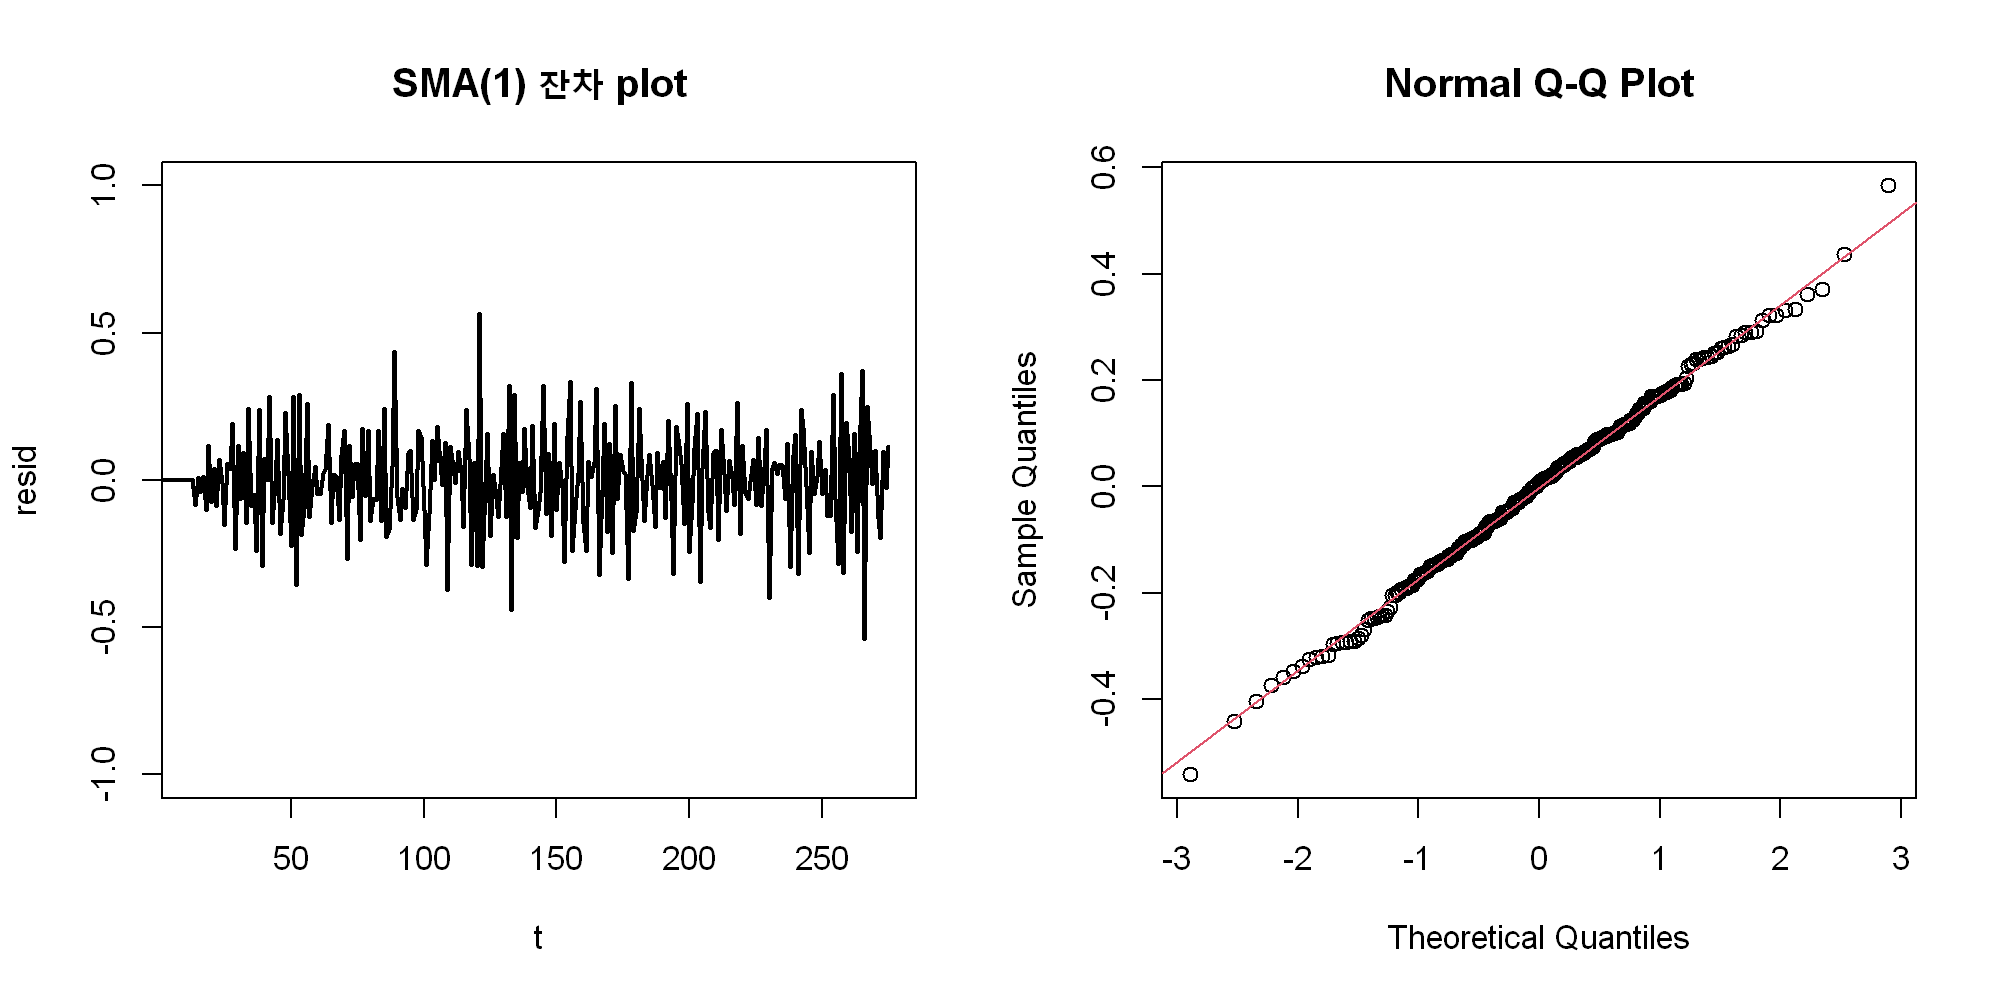

In [330]:
par(mfrow=c(1,2))
plot(data2 %>% select(t,resid),xlim=c(12,nrow(data2)),type="l",lwd=2,ylim=c(-1,1),main="SMA(1) 잔차 plot")
qqnorm(data2$resid[12:nrow(data2)])
qqline(data2$resid[12:nrow(data2)],col=2)

* 잔차plot을 그려본 결과 -1과 1구간에서 등분산성이라고 판단된다.

* qqplot을 그려본 결과 정규성 가정도 만족하는 것 같다.

In [331]:
shapiro.test(data2$resid)  ##H0 : normal distribution
jarque.bera.test(data2$resid)  ##JB test H0: normal


	Shapiro-Wilk normality test

data:  data2$resid
W = 0.99752, p-value = 0.9526



	Jarque Bera Test

data:  data2$resid
X-squared = 0.46596, df = 2, p-value = 0.7922


* 실제 가설검정결과도 정규성 가정을 만족한다.

#### 잔차의 ACF, PACF

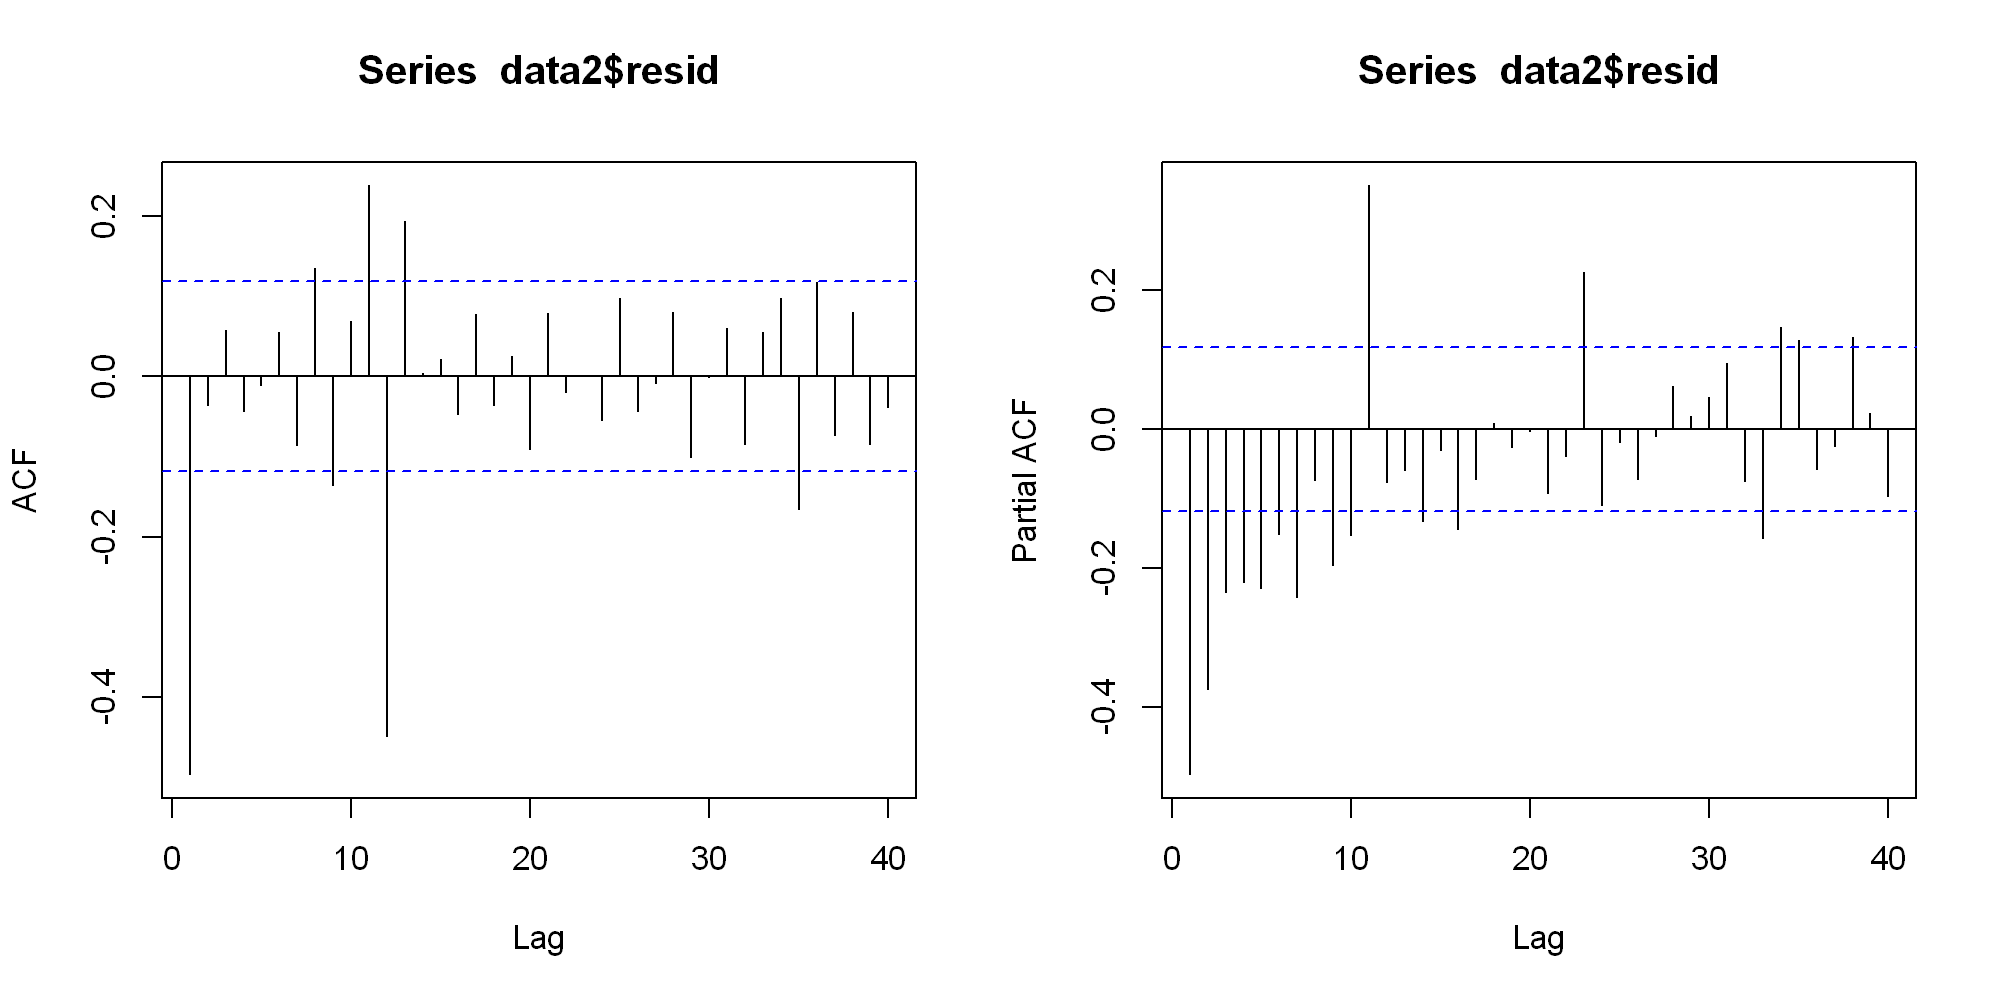

In [332]:
par(mfrow=c(1,2))
Acf(data2$resid,lag.max=40);Pacf(data2$resid,lag.max=40)

In [333]:
LjungBox(sma1_fit)

,lags,statistic,df,p-value
,5,70.28159,4,1.976197e-14
,10,85.07268,9,1.576517e-14
,15,170.76743,14,0.000000e+00
,20,176.25452,19,0.000000e+00
,25,181.99151,24,0.000000e+00
,30,187.72585,29,0.000000e+00


* 잔차의 자기상관성 검정 결과 자기상관성이 존재한다는 결과를 얻었다.

* 따라서 모형의 식별 단계로 돌아가 새로운 모형을 식별해야한다는 결론을 얻었다. (돌아가서 다시 식별하는 단계는 생략하겠습니다....)

## (7)

다음 2년간의 값을 예측하여라.

### Solution

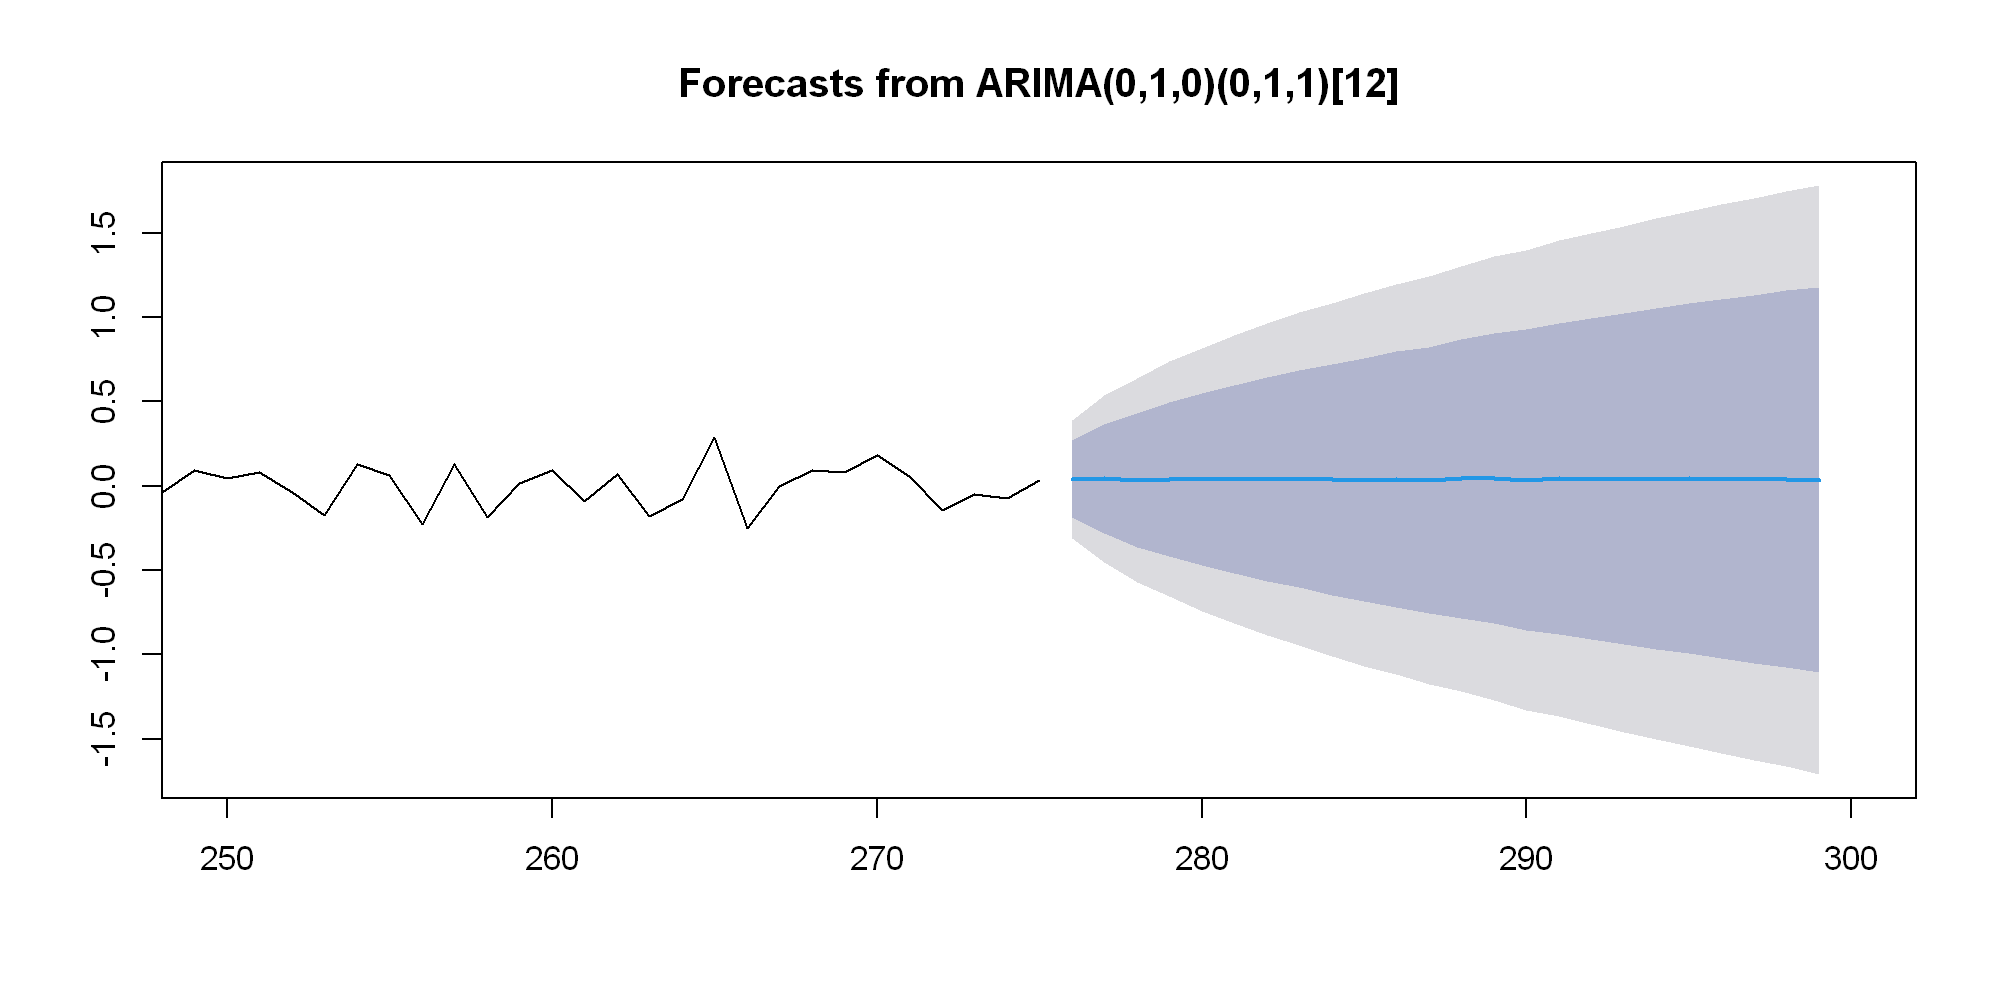

In [334]:
predict <- forecast(sma1_fit,h=24)
plot(predict,xlim=c(250,300))

In [335]:
range(predict$mean)

[1] 0.03311347 0.04581726

* 예측값을 살펴본 결과 0.03 ~ 0.45 사이로 추정된다.

***

# ukcars

## (1)

변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.<br>
(변수변환을 시행하였으면, 아래의 분석을 변환된 값으로 수행함)

### Solution

* 1997년에서 2005년까지 주기가 4인 데이터임을 확인하였다.

In [336]:
glimpse(ukcars)

 Time-Series [1:113] from 1977 to 2005: 330 371 271 344 358 ...


In [337]:
z  <- ukcars
t <- 1:length(z)
data3 <- tibble(t,z)

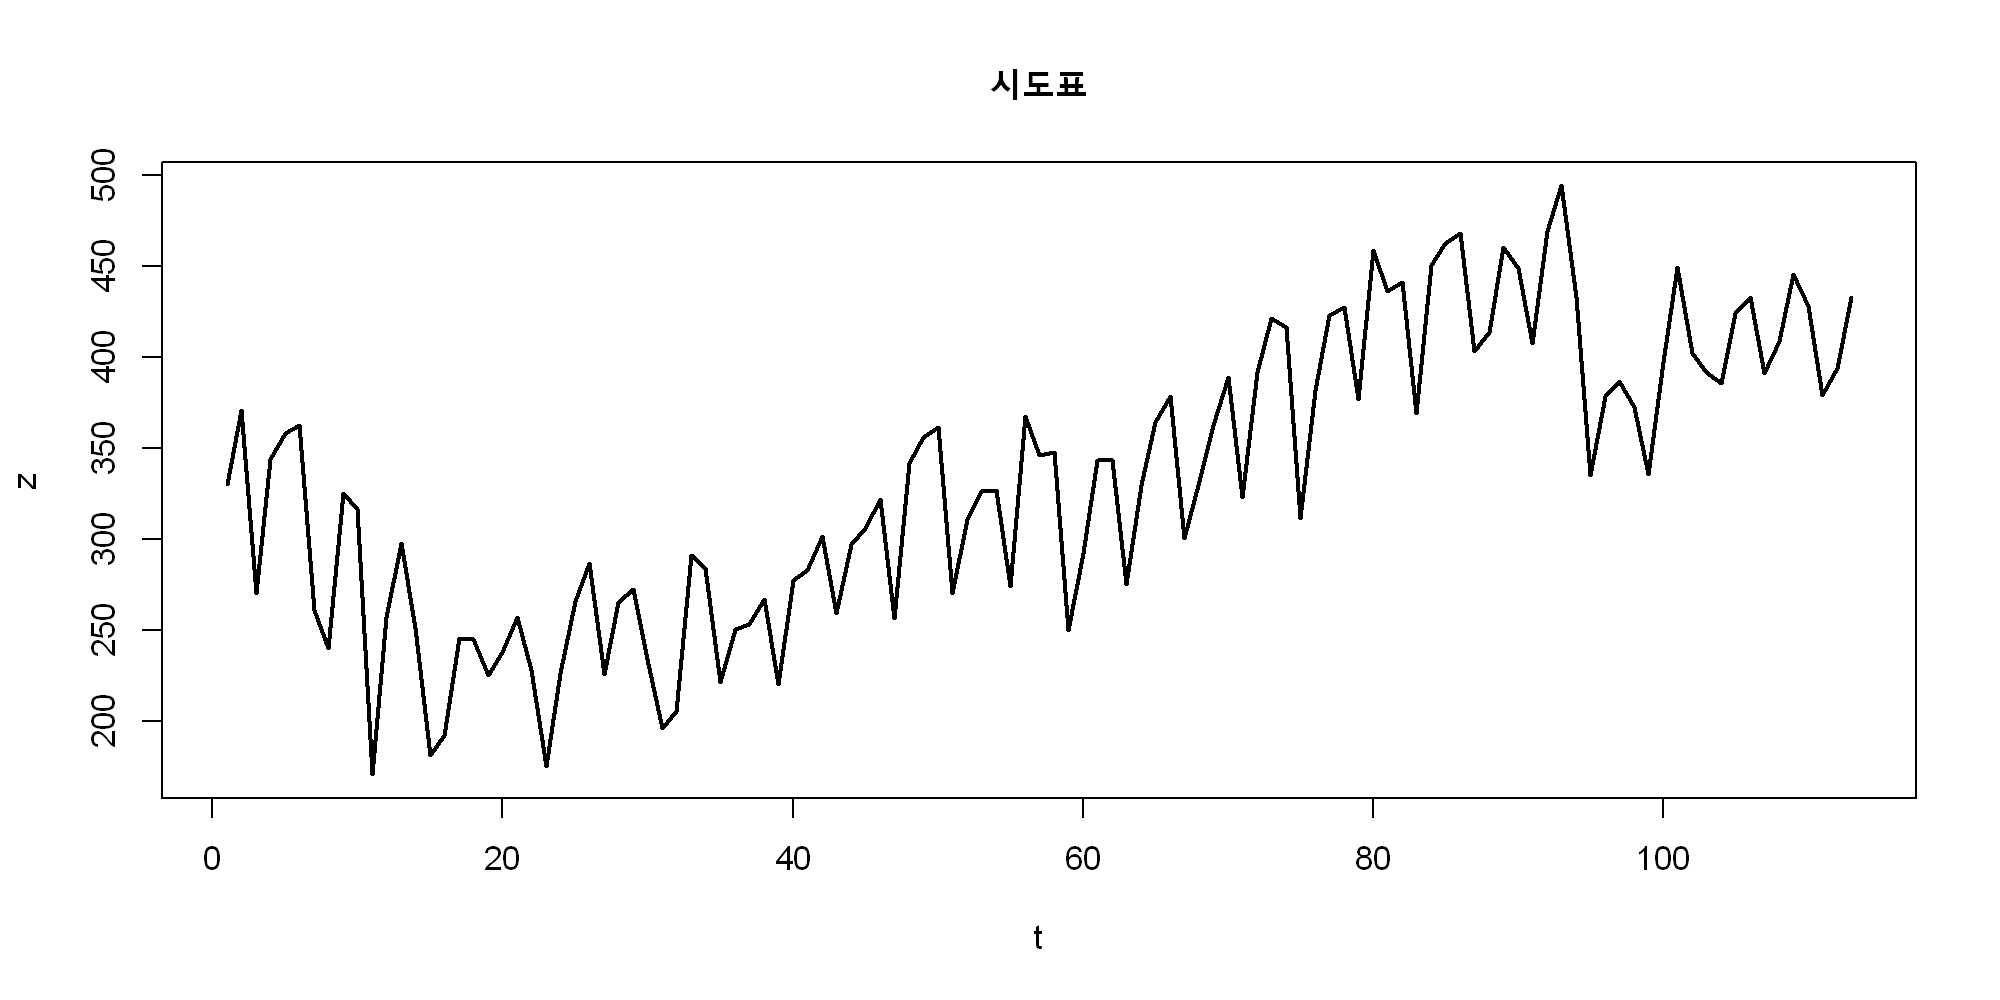

In [338]:
plot(t,z, lwd=2, main="시도표",type="l")

* 추세성분과 계절성분이 관측되었다.

*  `0 ~ 20`, `80 ~ 90` 지점에서 다른구간에 비해 변동폭이 증가하는 것처럼 보인다. 따라서 여러 변환법을 시행한 뒤 가장 적절한 변환을 선택하겠다.

In [339]:
data3 <- data3 %>% mutate(ln_z = log(z),
                 sqrt_z = sqrt(z),
                 boxcox_z = BoxCox(z,lambda= BoxCox.lambda(z)))

In [340]:
gather_d =data3 %>% 
            gather(key="type",value="value",-t) %>% filter(!type %in%  "z")

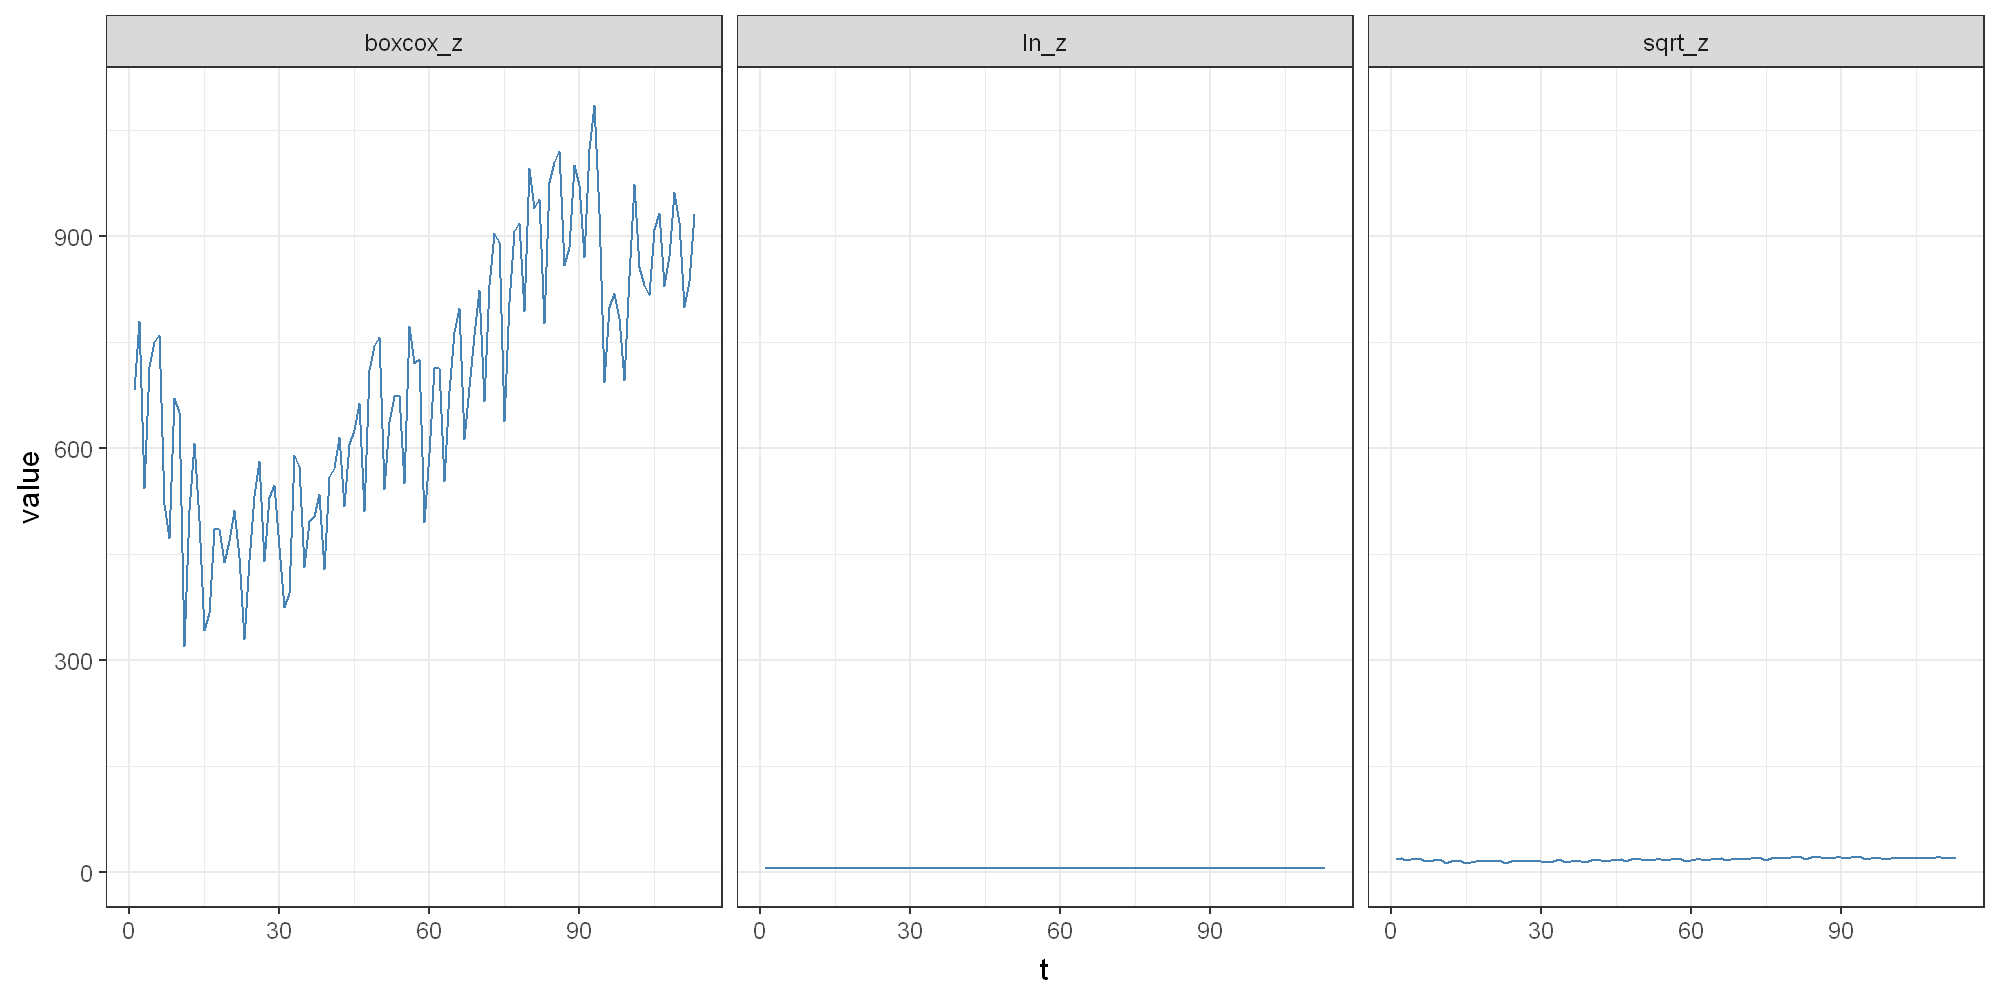

In [341]:
gather_d  %>% ggplot(aes(x=t,y=value)) +
                geom_line(col="steelblue") +
                facet_wrap(type~.) + theme_bw()

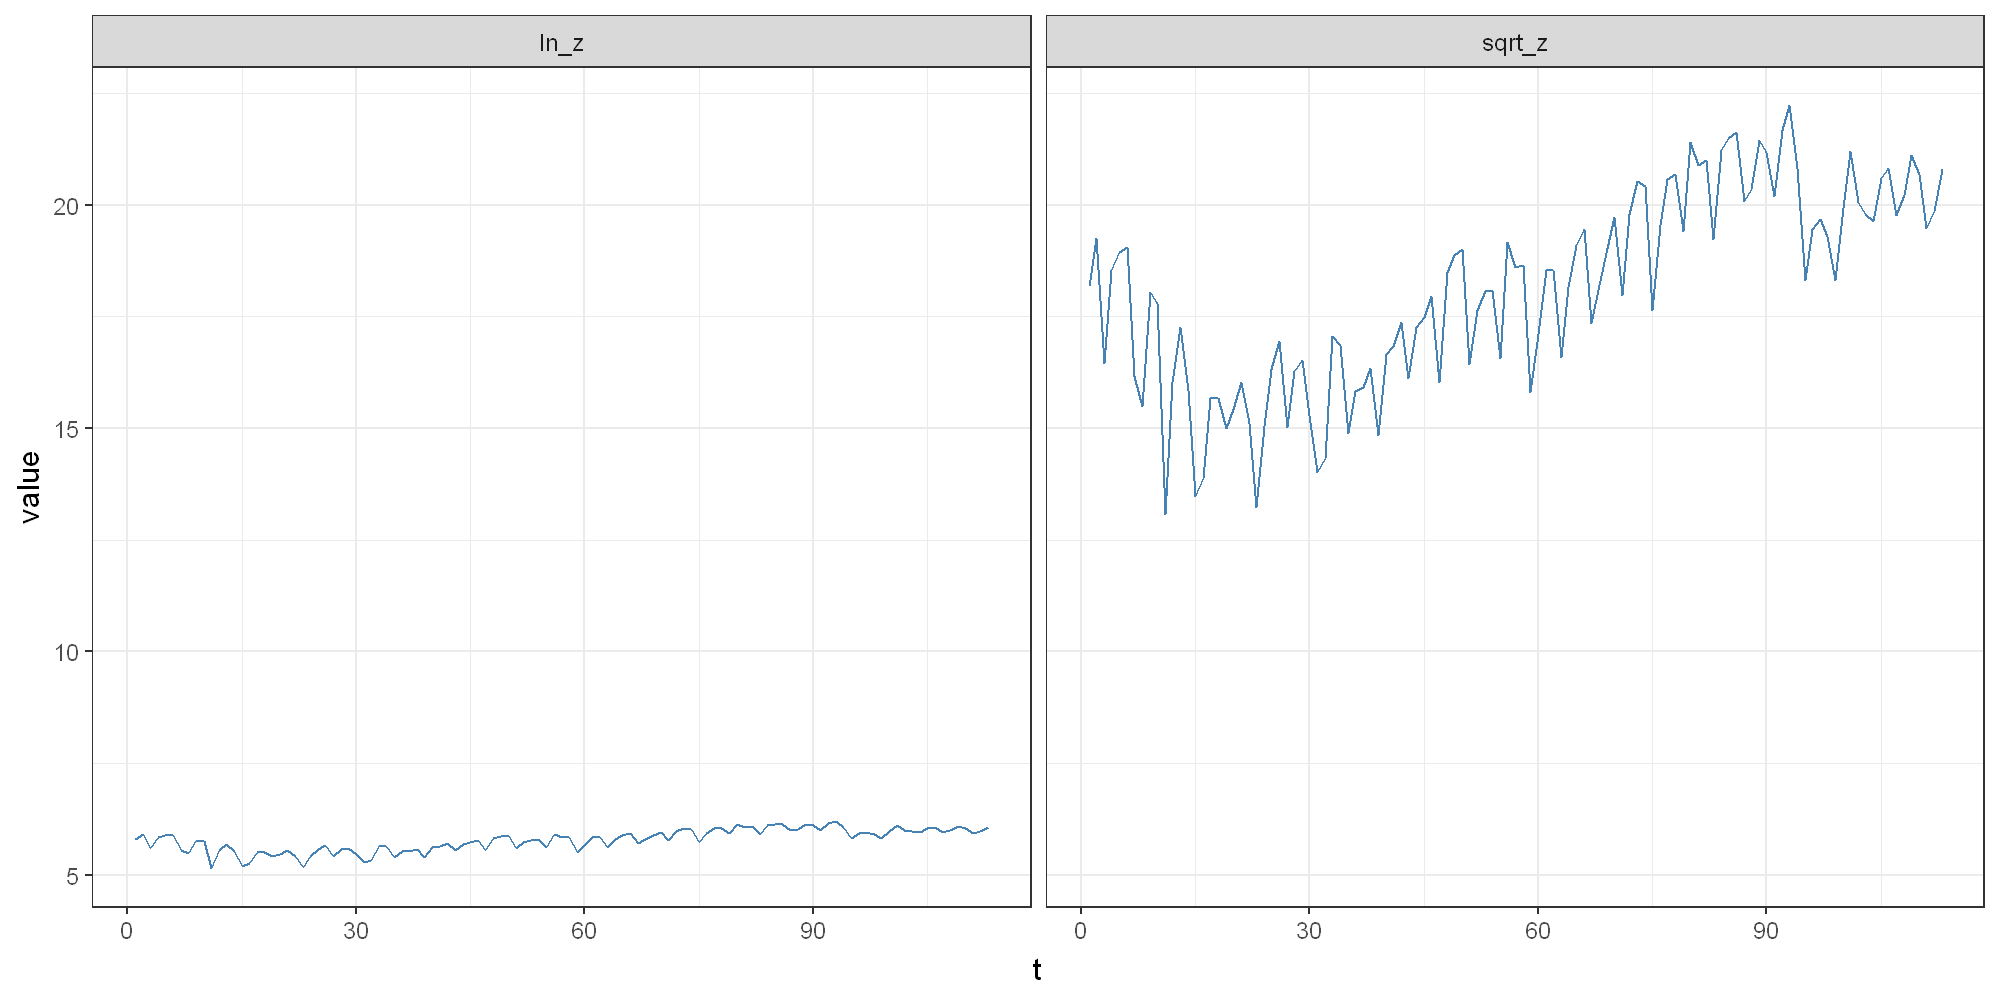

In [342]:
gather_d   %>% 
            filter(!type %in%  "boxcox_z") %>% ggplot(aes(x=t,y=value)) +
                                                    geom_line(col="steelblue") +
                                                        facet_wrap(type~.) + theme_bw()

* 변환 결과로 보아 변동폭이 가장 안정적인 로그변환이 적절하다고 판단된다.

## (2)

마지막 2년동안의 데이터는 test데이터, 나머지는 train 데이터로 분할하여라.

### Solution

* 뒤에서 5개의 데이터가 마지막 2년 데이터이다.

In [343]:
test <- tail(data3,5)
train <- data3  %>% setdiff(test)

In [344]:
nrow(intersect(test,train))

[1] 0

## (3)

이동평균을 이용하여 마지막 2년을 예측하여라

### Solution

In [345]:
library(TTR)

In [346]:
ma_fit <- stl(ts(train$ln_z,start=1977,frequency = 4),s.window = "period")

In [347]:
ma_pred <- forecast(ma_fit)

In [350]:
ma_pred

        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2004 Q1       6.120623 6.004471 6.236776 5.942984 6.298263
2004 Q2       6.108036 5.975532 6.240540 5.905388 6.310684
2004 Q3       5.886378 5.739329 6.033426 5.661486 6.111269
2004 Q4       6.033694 5.873415 6.193973 5.788568 6.278819
2005 Q1       6.120623 5.948126 6.293121 5.856811 6.384435
2005 Q2       6.108036 5.924130 6.291942 5.826776 6.389296
2005 Q3       5.886378 5.691731 6.081024 5.588691 6.184064
2005 Q4       6.033694 5.828869 6.238519 5.720441 6.346947

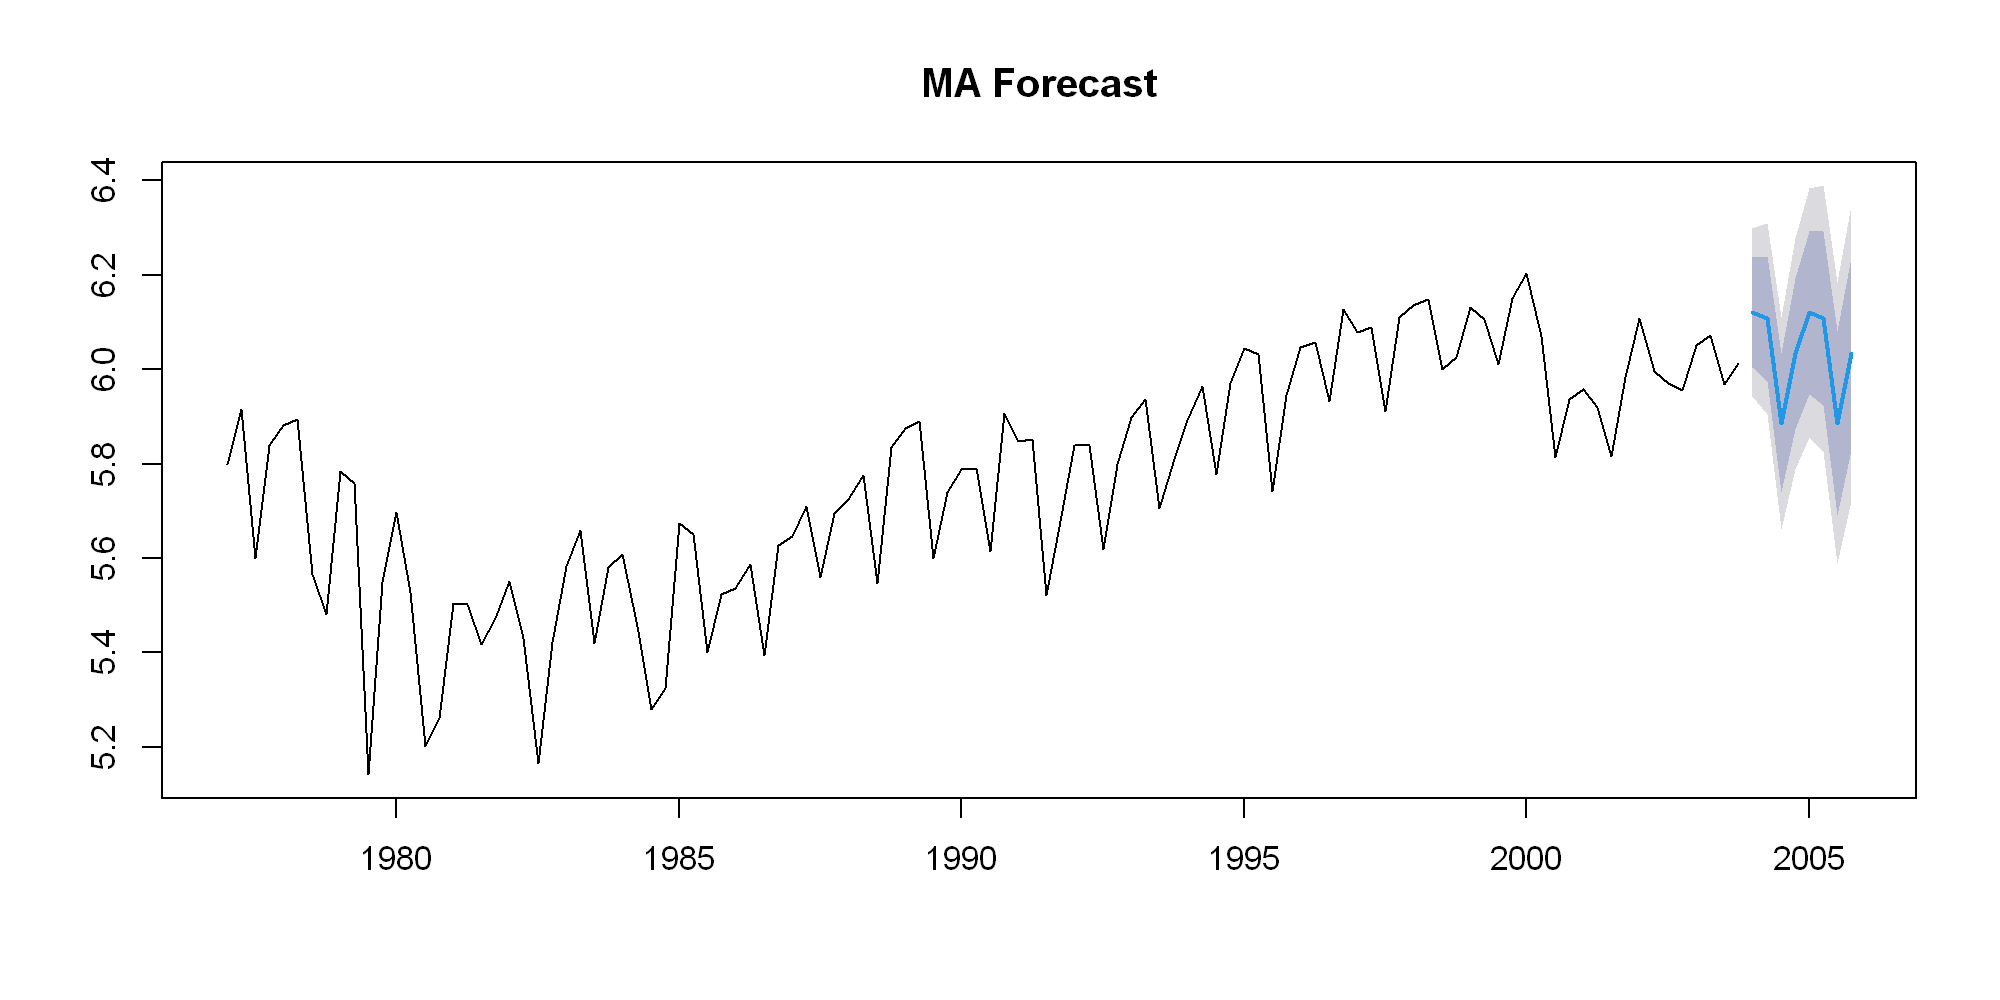

In [351]:
plot(ma_pred,main="MA Forecast")

In [352]:
ma_pred_value <- ma_pred$mean[1:5]

## (4)

지수평활법을 이용하여 마지막 2년을 예측하여라

### Solution

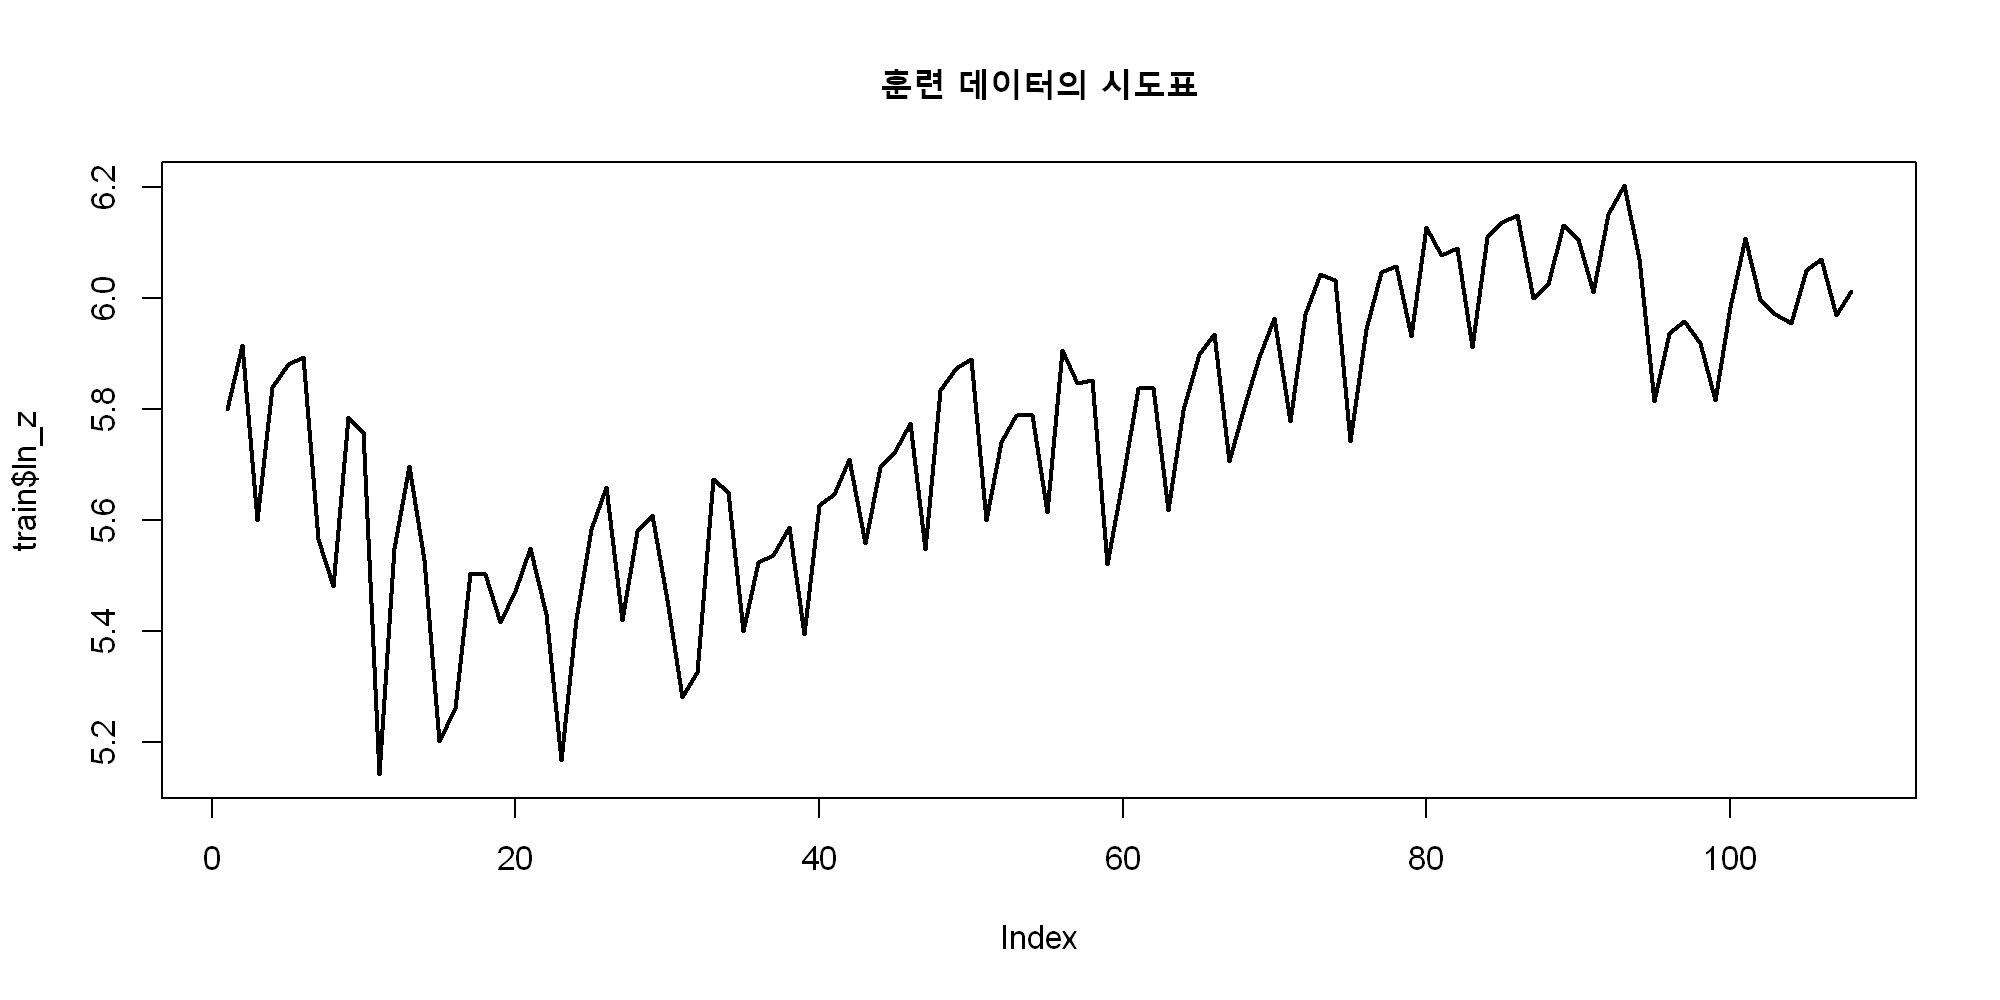

In [216]:
plot(train$ln_z,type="l",main="훈련 데이터의 시도표",lwd=2)

* 시도표를 그려본 결과 추세성분과 계절성분이 모두 관측되므로 계절지수평활법을 사용하여 모형을 적합

In [353]:
library(stats)

In [354]:
holt_fit <- HoltWinters(ts(train$ln_z,start=1977,frequency = 4))

In [355]:
holt_pred <- forecast(holt_fit)

In [356]:
holt_pred

        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2004 Q1       6.106065 5.985429 6.226701 5.921568 6.290562
2004 Q2       6.086447 5.948262 6.224632 5.875112 6.297783
2004 Q3       5.939748 5.784889 6.094608 5.702911 6.176585
2004 Q4       6.038605 5.867652 6.209558 5.777155 6.300055
2005 Q1       6.118939 5.925281 6.312597 5.822765 6.415113
2005 Q2       6.099321 5.890758 6.307884 5.780351 6.418291
2005 Q3       5.952622 5.729264 6.175980 5.611026 6.294218
2005 Q4       6.051479 5.813390 6.289567 5.687354 6.415603

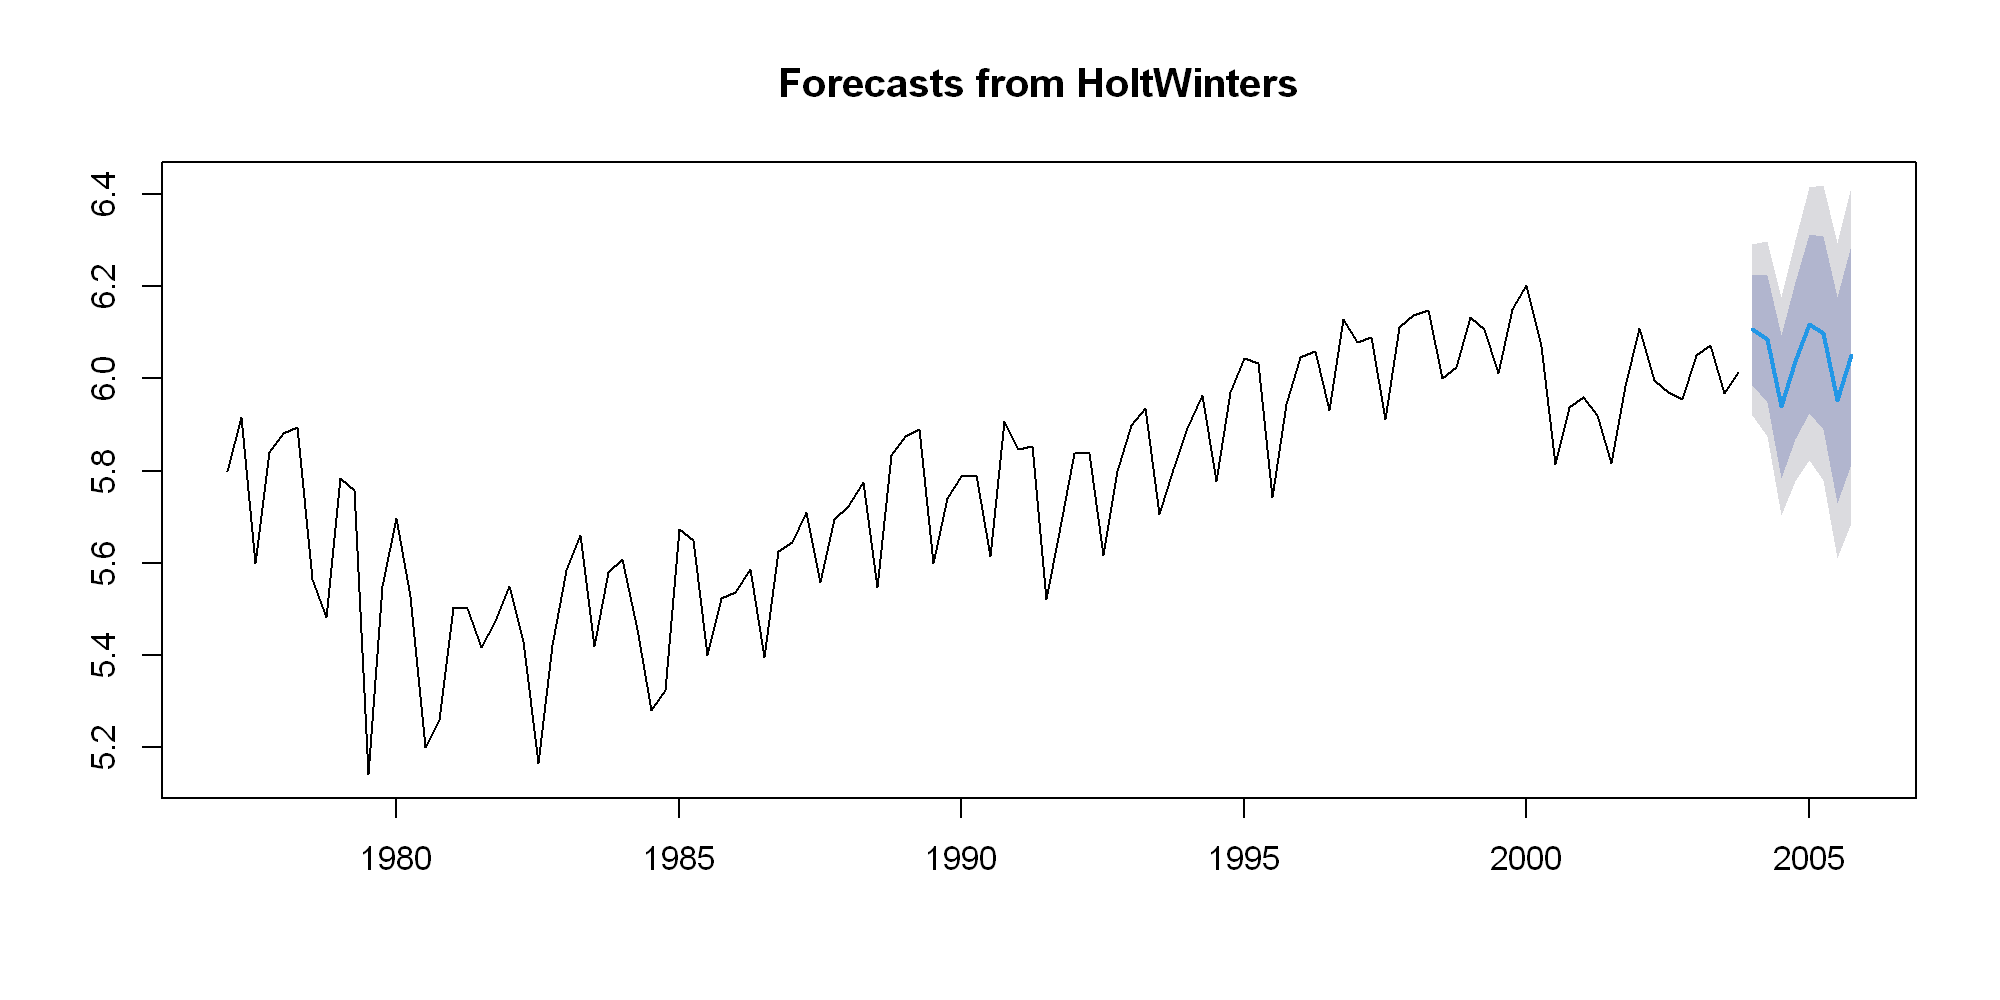

In [357]:
plot(holt_pred)

In [358]:
holt_pred_value <- holt_pred$mean[1:5]

## (5)

계절형 ARIMA 모형을 적합하여 마지막 2년을 예측하여라.

### Solution

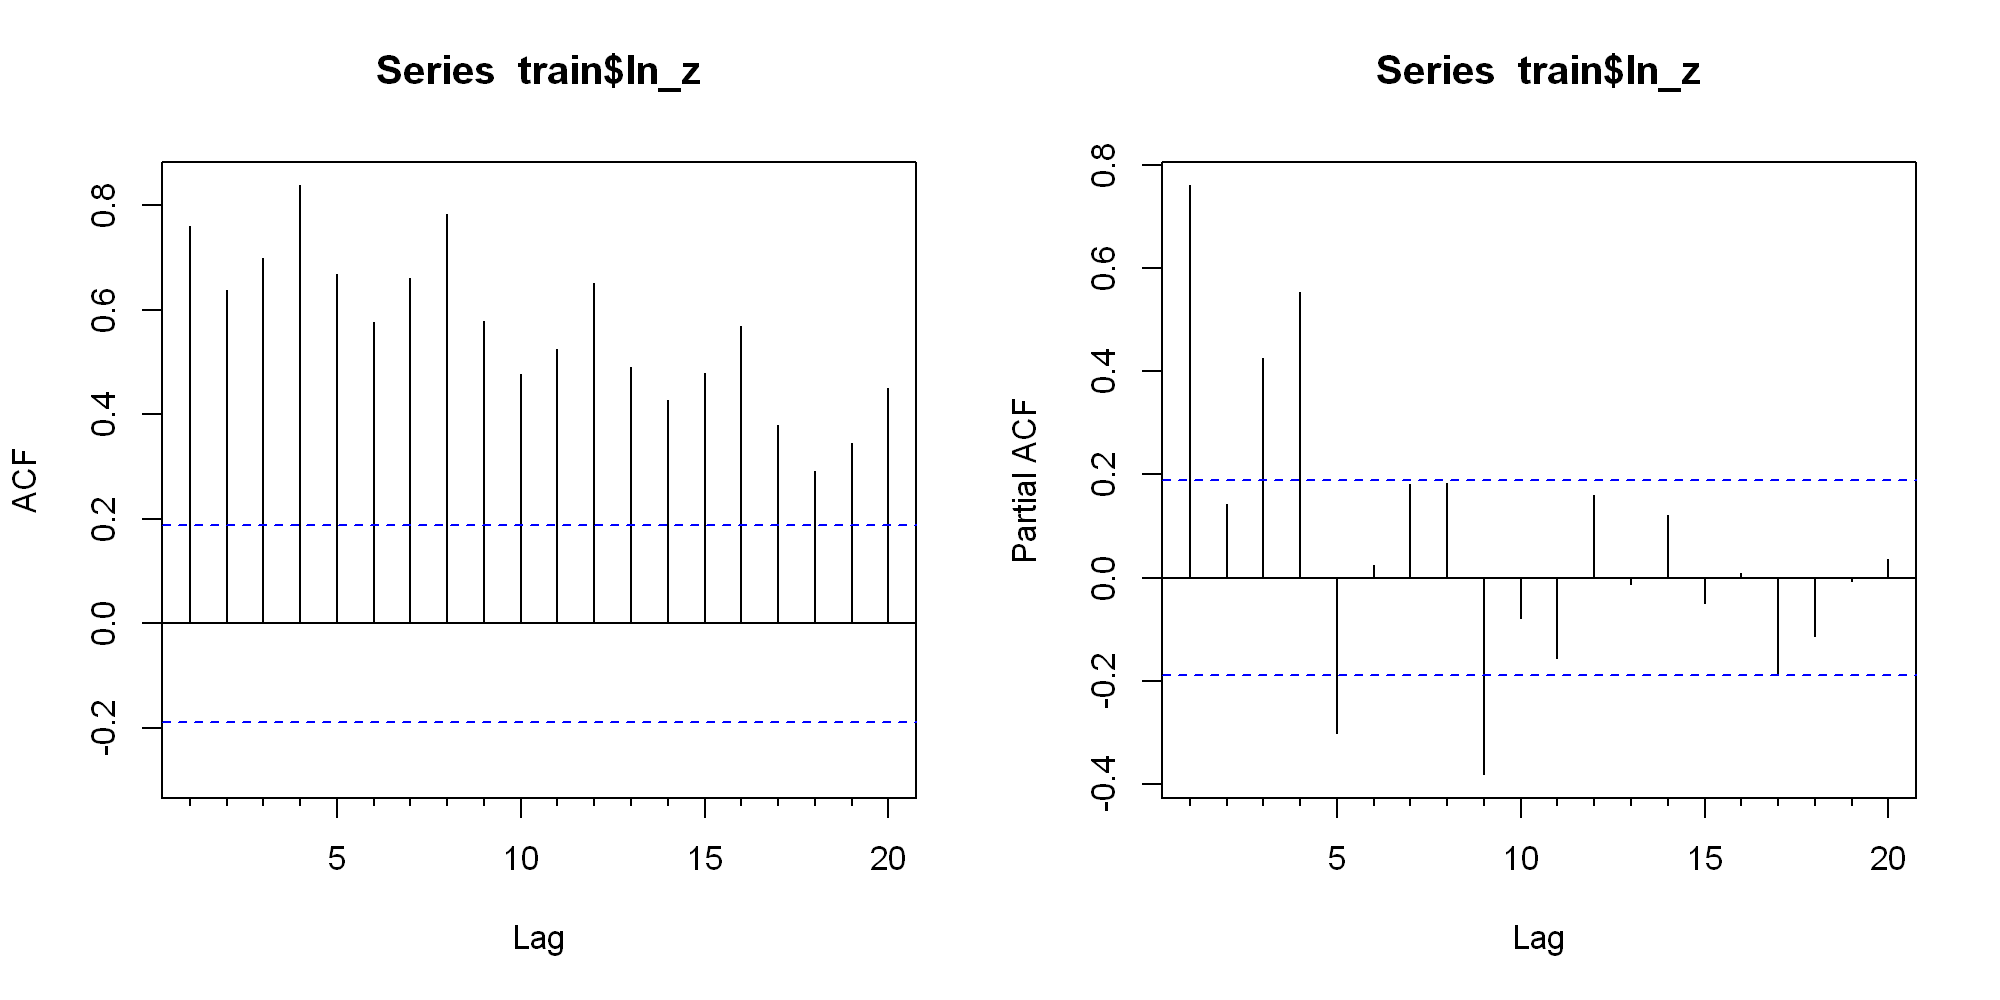

In [359]:
par(mfrow=c(1,2))
Acf(train$ln_z);Pacf(train$ln_z)

* ACF 값을 보아 확실히 확률적 계절 성분이 보여 계절 차분이 필요해보인다.

#### 계절 차분

In [360]:
train <- train %>%    
                mutate(diff_lnz_s =c(rep(0,4),diff(ln_z,4)))

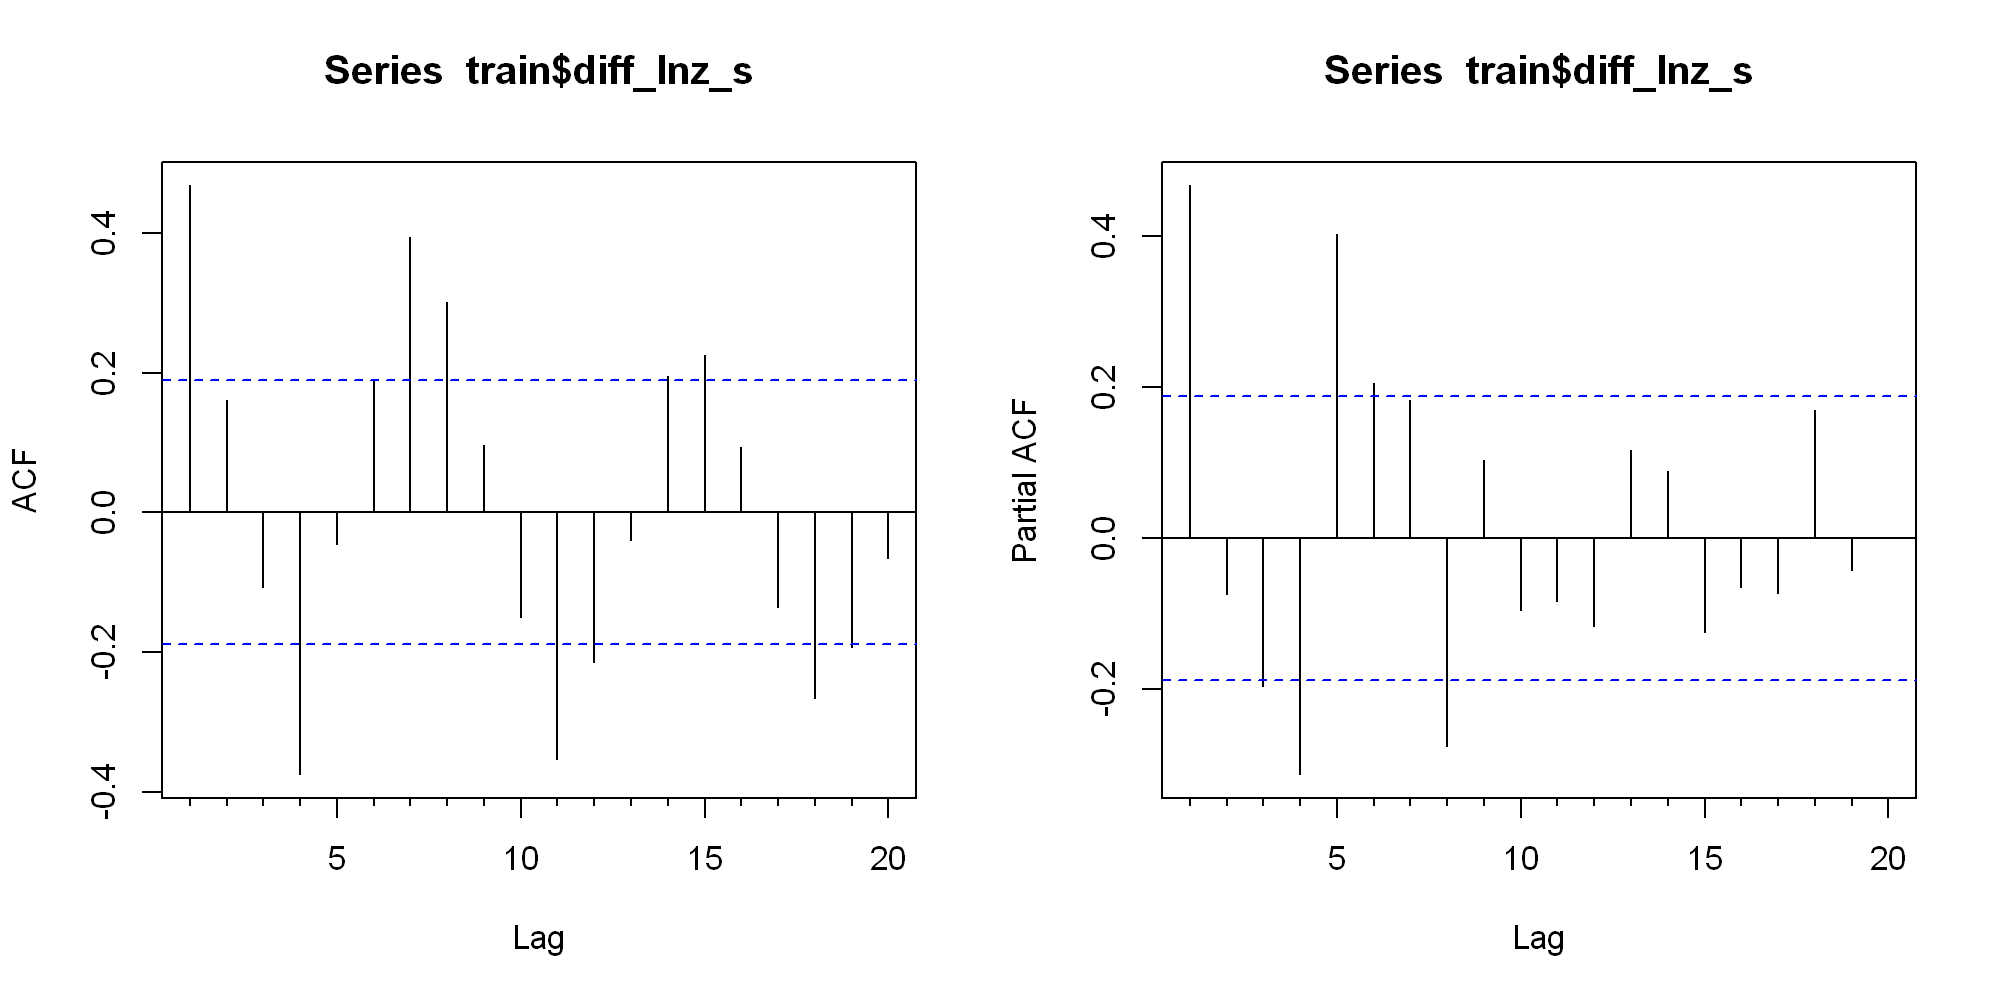

In [361]:
par(mfrow=c(1,2))
Acf(train$diff_lnz_s);Pacf(train$diff_lnz_s)

In [130]:
 #adfTest(train$diff_lnz_s,lags=0)
 #adfTest(train$diff_lnz_s,lags=4)
 #adfTest(train$diff_lnz_s,lags=8)

* acf값을 보았을 때 주기가 4인 ARIMA(0,0,0)(0,1,3) 모형을 고려할 수 있다. (lag 4, lag8, lag 12 에서 기각역을 넘기 때문)

* pacf 값을 보았을 때는 주기가 4인 ARIMA(0,0,0)(2,1,0) 모형을 고려할 수 있다. (lag 4, lag 8에서 기각역을 넘기 때문)

* 모형의 단순성을 위해 주기가 4인 ARIMA(0,0,0)(2,1,0) 모형을 적합시키겠다.

#### 모형적합

In [362]:
sar2_fit <- arima(train$diff_lnz_s,order=c(0,0,0),
                                    seasonal = list(order=c(2,1,0), period=4))

#### 예측

In [363]:
s_pred <- forecast(sar2_fit)

In [364]:
s_pred

    Point Forecast       Lo 80     Hi 80      Lo 95     Hi 95
109    0.028159339 -0.14590958 0.2022283 -0.2380561 0.2943748
110    0.010472781 -0.16359614 0.1845417 -0.2557427 0.2766882
111    0.104809829 -0.06925909 0.2788788 -0.1614056 0.3710253
112   -0.003657333 -0.17772625 0.1704116 -0.2698728 0.2625581
113    0.005332752 -0.16883257 0.1794981 -0.2610301 0.2716956
114    0.073001705 -0.10116362 0.2471670 -0.1933612 0.3393646
115    0.047371980 -0.12679335 0.2215373 -0.2189909 0.3137349
116    0.030403334 -0.14376199 0.2045687 -0.2359595 0.2967662

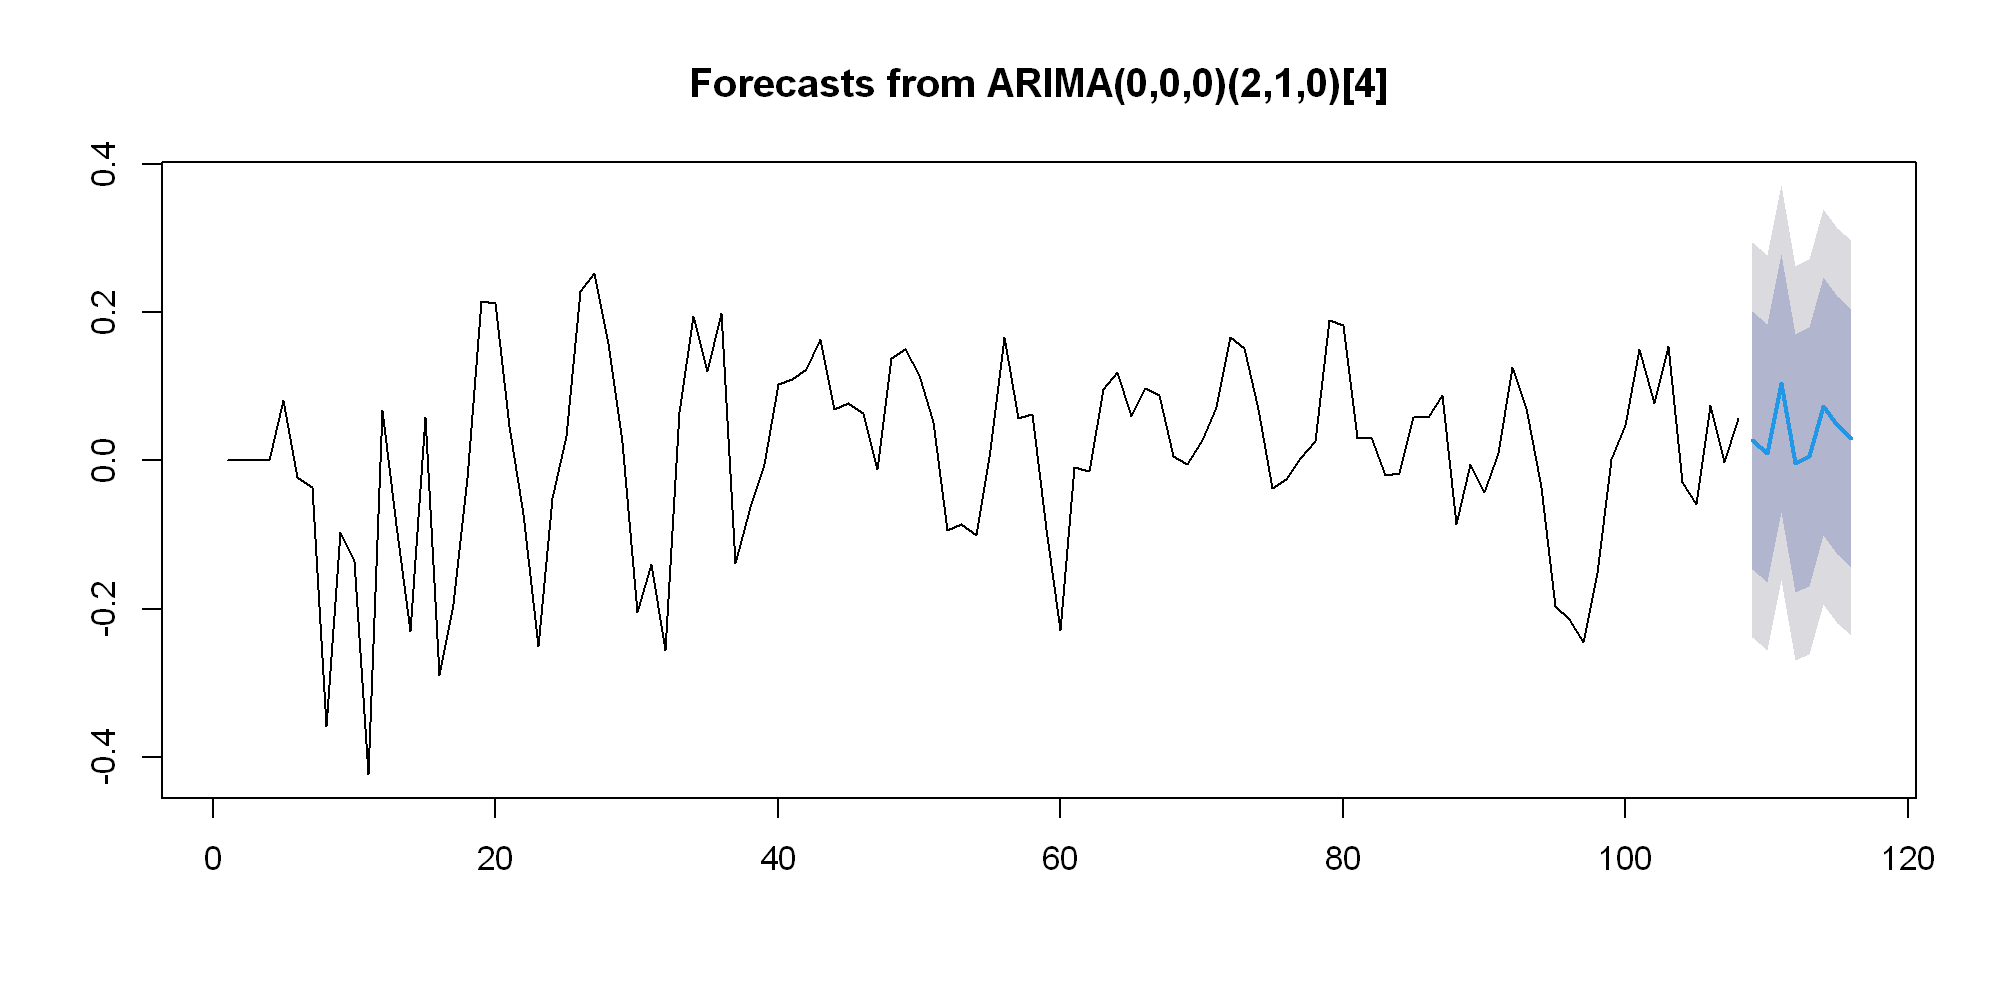

In [365]:
plot(s_pred)

In [366]:
s_pred_value <- s_pred$mean[1:5]

## (6)

### Solution

#### 3가지 예측 모형 시각화

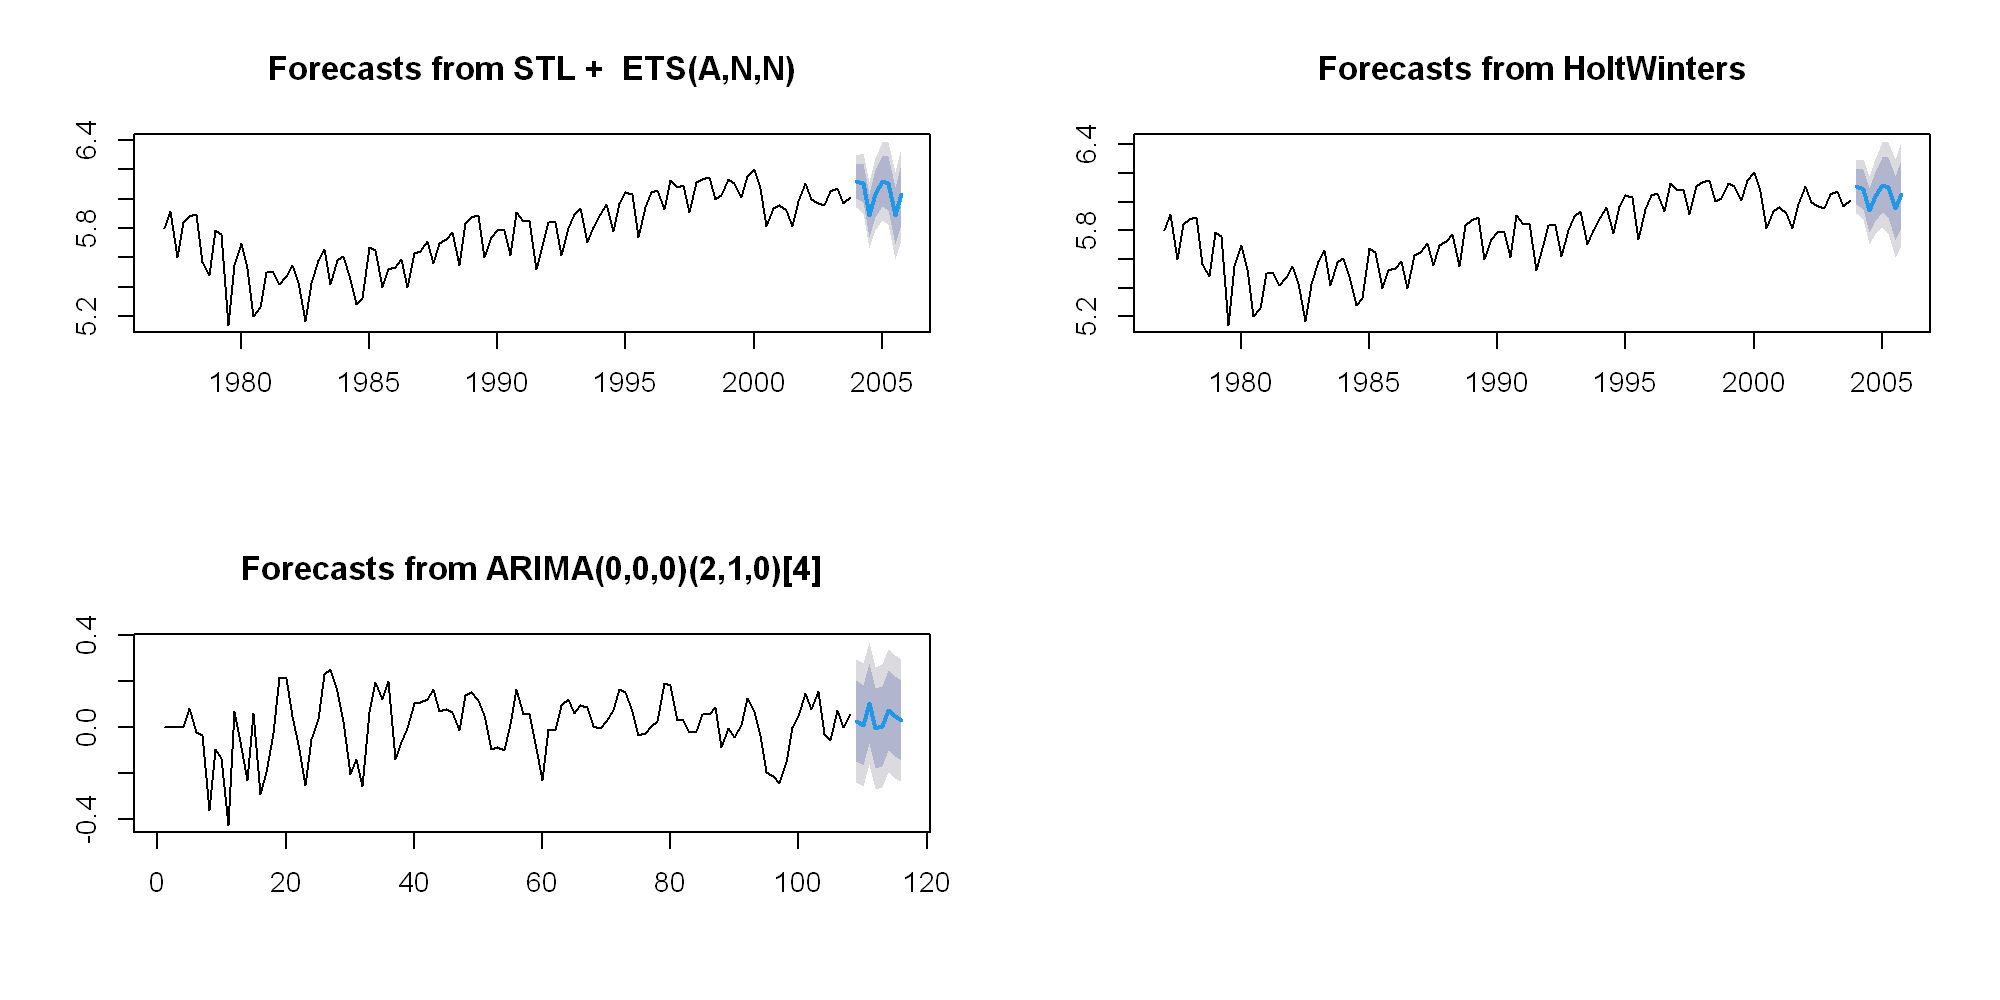

In [367]:
par(mfrow=c(2,2))
plot(ma_pred,maiㅁn="MA Forecast");plot(holt_pred);plot(s_pred)

예측값과 실제값을 이용하여 (3)-(5) 모형 중 가장 좋은 모형을 선택하여라.

In [368]:
test_diff <- tail(c(0,diff(data3$ln_z)),5)

In [369]:
ma_diff <- mean((test$ln_z - ma_pred_value)^2)
holt_diff <-mean((test$ln_z - holt_pred_value)^2)
s_diff <- mean((test_diff - s_pred_value)^2)

In [370]:
test_mse <- c(ma_diff,holt_diff,s_diff)

In [371]:
label <- c("이동평균","계절지수","SAR(2)")

In [372]:
mse_table  <- tibble(test_mse,label)

In [373]:
mse_table

test_mse,label
<dbl>,<chr>
0.002250332,이동평균
0.001401030,계절지수
0.013377704,SAR(2)


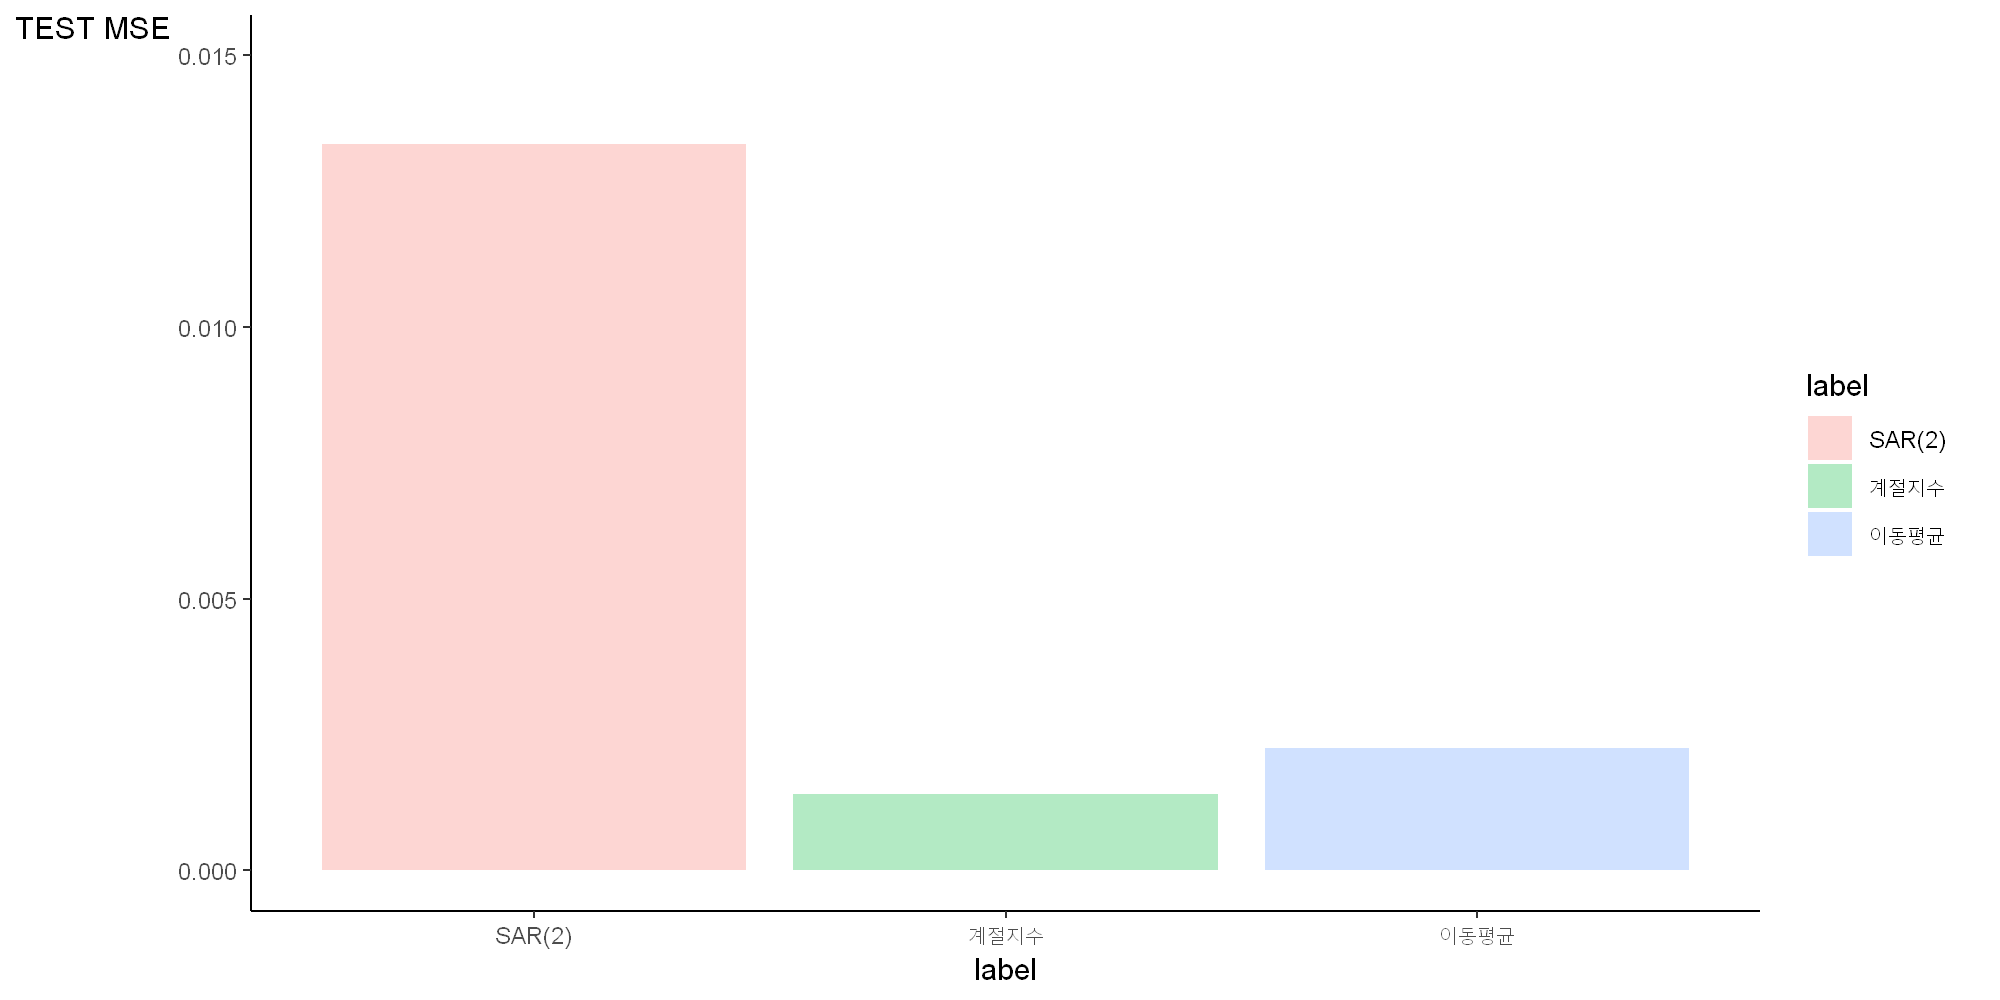

In [374]:
mse_table %>% ggplot(aes(x=label,y=test_mse,fill=label))+
                geom_bar(stat="identity",alpha=0.3) +
                theme_classic() + ylab("TEST MSE") +
                theme(axis.title.y = element_text(angle=0))+
                coord_cartesian(ylim=c(0,0.015))

* TEST MAE 비교결과 계절지수 평활법을 적용한 모형이 가장 TEST MSE가 낮았다.

* TEST MSE 기준으로 모형을 선택한다면 계절지수평활법을 적용한 모형이 가장 적합한 모형이다.

* 허나 위 기준은 overfitting 문제를 고려하지 않았다. 또한 test data가 5개 밖에 안 되어 사실상 어떤 모형이 좋고 그름을 판단하긴 어렵다. 